## Environment Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# hack - https://github.com/googlecolab/colabtools/issues/3409#issuecomment-1446281277
import locale
locale.getpreferredencoding = lambda: "UTF-8"
! pip install -Uq ipdb
import ipdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.5 MB/s eta 0:00:00


In [3]:
# This get the RAPIDS-Colab install files and test check your GPU.  Run this and the next cell only.
# Please read the output of this cell.  If your Colab Instance is not RAPIDS compatible, it will warn you and give you remediation steps.
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
%cd rapidsai-csp-utils
!git checkout 22.12-patch
%cd ..
!python rapidsai-csp-utils/colab/env-check.py
!python rapidsai-csp-utils/colab/pip-install.py

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 390, done.
remote: Counting objects: 100% (121/121), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 390 (delta 89), reused 51 (delta 51), pack-reused 269
Receiving objects: 100% (390/390), 107.11 KiB | 5.64 MiB/s, done.
Resolving deltas: 100% (191/191), done.
/content/rapidsai-csp-utils
Branch '22.12-patch' set up to track remote branch '22.12-patch' from 'origin'.
Switched to a new branch '22.12-patch'
/content
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 860.5 kB/s eta 0:00:00
Traceback (most recent call last):
  File "/content/rapidsai-csp-utils/colab/env-check.py", line 26, in <module>
    gpu_name = pynvml.nvmlDeviceGetName(pynvml.nvmlDeviceGetHandleByIndex(0)).decode('UTF-8')
AttributeError: 'str' object has no attribute 'decode'. Did you mean: 'encode'?
Traceback (most recent call last):
  File "/content/rapidsai-csp-utils/colab/pip-install.py", line 26, in <module>
    gpu_name 

In [4]:
%%bash
# Install the Merlin Framework
pip install -Uq git+https://github.com/NVIDIA-Merlin/models.git@release-23.06
pip install -Uq git+https://github.com/NVIDIA-Merlin/nvtabular.git@release-23.06
pip install -Uq git+https://github.com/NVIDIA-Merlin/core.git@release-23.06
# pip install -Uq git+https://github.com/NVIDIA-Merlin/system.git@release-23.04
# pip install -Uq git+https://github.com/NVIDIA-Merlin/dataloader.git@release-23.04
pip install -Uq git+https://github.com/NVIDIA-Merlin/Transformers4Rec.git@release-23.06
# pip install -Uq xgboost lightfm implicit
# tf 2.13 breaks keras
pip install tensorflow==2.12.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.8/140.8 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.0/122.0 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.5/985.5 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 MB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 763.4/763.4 kB 42.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Load Data
Reference
- https://github.com/NVIDIA-Merlin/models/blob/main/examples/02-Merlin-Models-and-NVTabular-integration.ipynb

In [5]:
import logging
import warnings

# Set the logging level to a higher value (e.g., CRITICAL)
logging.basicConfig(level=logging.ERROR)

warnings.filterwarnings("ignore")

In [6]:
import os
import shutil
import numpy as np
from nvtabular import ops
from merlin.schema.tags import Tags
import merlin.io
import merlin.models.tf as mm

import nvtabular as nvt
import tensorflow as tf


from os import path

# Get dataframe library - cudf or pandas
from merlin.core.dispatch import get_lib
pd = get_lib()

In [7]:
DATA_DIR = os.environ.get(
    "DATA_DIR", os.path.expanduser("/content/drive/MyDrive/ml-twotower-model/data/")
)

GIT_PROJECT = 'kchopra456/ml-model-template'

In [8]:
import glob

USE_AUGMENTED_DATASET= False
DATA_VERSION = 'v4'

_TRAIN,_VALID,_TEST = ('train_aug', 'valid_aug', 'test_aug') if USE_AUGMENTED_DATASET else ('train', 'valid', 'test')

TRAIN_PATHS = sorted(glob.glob(os.path.join(DATA_DIR, _TRAIN + f'_{DATA_VERSION}', "*.parquet")))
VALID_PATHS = sorted(glob.glob(os.path.join(DATA_DIR, _VALID + f'_{DATA_VERSION}', "*.parquet")))
TEST_PATHS = sorted(glob.glob(os.path.join(DATA_DIR, _TEST + f'_{DATA_VERSION}', "*.parquet")))

# TRAIN_PATHS = sorted(glob.glob(os.path.join(DATA_DIR, _TRAIN , "*.parquet")))
# VALID_PATHS = sorted(glob.glob(os.path.join(DATA_DIR, _VALID , "*.parquet")))
# TEST_PATHS = sorted(glob.glob(os.path.join(DATA_DIR, _TEST , "*.parquet")))
TRAIN_PATHS, VALID_PATHS, TEST_PATHS

(['/content/drive/MyDrive/ml-twotower-model/data/train_v4/part_0.parquet'],
 ['/content/drive/MyDrive/ml-twotower-model/data/valid_v4/part_0.parquet'],
 ['/content/drive/MyDrive/ml-twotower-model/data/test_v4/part_0.parquet'])

In [26]:
train = merlin.io.Dataset(
    TRAIN_PATHS, engine="parquet"
)
valid = merlin.io.Dataset(
    VALID_PATHS, engine="parquet"
)
test = merlin.io.Dataset(
    TEST_PATHS, engine="parquet"
)


In [10]:
schema = train.schema.select_by_tag([
    Tags.ITEM_ID,
    Tags.USER_ID,
    Tags.ITEM,
    Tags.USER,
    # Tags.TARGET,
    ])
schema

,name,tags,dtype,is_list,is_ragged,properties.start_index,properties.embedding_sizes.cardinality,properties.embedding_sizes.dimension,properties.max_size,properties.freq_threshold,properties.num_buckets,properties.cat_path,properties.domain.min,properties.domain.max,properties.domain.name,properties.value_count.min,properties.value_count.max
0,movie_id,"(Tags.ITEM, Tags.CATEGORICAL, Tags.ID)","DType(name='int64', element_type=<ElementType....",False,False,0.0,1665.0,102.0,0.0,0.0,None,.//categories/unique.movie_id.parquet,0,1664,movie_id,NaN,NaN
1,user_id,"(Tags.CATEGORICAL, Tags.USER, Tags.ID)","DType(name='int64', element_type=<ElementType....",False,False,0.0,944.0,74.0,0.0,0.0,None,.//categories/unique.user_id.parquet,0,943,user_id,NaN,NaN
2,gender,"(Tags.CATEGORICAL, Tags.USER)","DType(name='int64', element_type=<ElementType....",False,False,0.0,3.0,16.0,0.0,0.0,None,.//categories/unique.gender.parquet,0,2,gender,NaN,NaN
3,occupation,"(Tags.CATEGORICAL, Tags.USER)","DType(name='int64', element_type=<ElementType....",False,False,0.0,22.0,16.0,0.0,0.0,None,.//categories/unique.occupation.parquet,0,21,occupation,NaN,NaN
4,genres,"(Tags.ITEM, Tags.CATEGORICAL)","DType(name='int64', element_type=<ElementType....",True,True,0.0,20.0,16.0,0.0,0.0,None,.//categories/unique.genres.parquet,0,19,genres,0.0,NaN


In [11]:
# schema = schema.excluding_by_name('genres')

In [12]:
train.head()

,movie_id,movie_id_raw,user_id,gender,occupation,genres,rating
0,226,705,149,1,3,"[5, 13]",1
1,74,144,148,1,3,"[4, 3]",1
2,137,203,295,1,5,[15],1
3,9,300,761,1,3,"[4, 3]",1
4,43,25,212,2,7,[2],1


In [13]:
# missing from load
schema['movie_id'].tags._tags.add(Tags.ITEM_ID)
schema['user_id'].tags._tags.add(Tags.USER_ID)

In [14]:
# select only trainable features and exclude the target
train.schema = schema
valid.schema = schema
test.schema = schema

In [15]:
train.schema

,name,tags,dtype,is_list,is_ragged,properties.start_index,properties.embedding_sizes.cardinality,properties.embedding_sizes.dimension,properties.max_size,properties.freq_threshold,properties.num_buckets,properties.cat_path,properties.domain.min,properties.domain.max,properties.domain.name,properties.value_count.min,properties.value_count.max
0,movie_id,"(Tags.ITEM, Tags.CATEGORICAL, Tags.ID, Tags.IT...","DType(name='int64', element_type=<ElementType....",False,False,0.0,1665.0,102.0,0.0,0.0,None,.//categories/unique.movie_id.parquet,0,1664,movie_id,NaN,NaN
1,user_id,"(Tags.CATEGORICAL, Tags.USER_ID, Tags.USER, Ta...","DType(name='int64', element_type=<ElementType....",False,False,0.0,944.0,74.0,0.0,0.0,None,.//categories/unique.user_id.parquet,0,943,user_id,NaN,NaN
2,gender,"(Tags.CATEGORICAL, Tags.USER)","DType(name='int64', element_type=<ElementType....",False,False,0.0,3.0,16.0,0.0,0.0,None,.//categories/unique.gender.parquet,0,2,gender,NaN,NaN
3,occupation,"(Tags.CATEGORICAL, Tags.USER)","DType(name='int64', element_type=<ElementType....",False,False,0.0,22.0,16.0,0.0,0.0,None,.//categories/unique.occupation.parquet,0,21,occupation,NaN,NaN
4,genres,"(Tags.ITEM, Tags.CATEGORICAL)","DType(name='int64', element_type=<ElementType....",True,True,0.0,20.0,16.0,0.0,0.0,None,.//categories/unique.genres.parquet,0,19,genres,0.0,NaN


In [16]:
assert len(train.schema.select_by_tag(Tags.TARGET).column_names) == 0

## Build Model
Reference
- https://github.com/NVIDIA-Merlin/models/blob/main/examples/05-Retrieval-Model.ipynb

### Model definition

In [17]:
# collect model_helper.py
! rm model_helper.py || true
! wget --no-cache https://raw.githubusercontent.com/$GIT_PROJECT/master/model_helper.py #-O model_helper.py

rm: cannot remove 'model_helper.py': No such file or directory
--2023-09-10 10:56:32--  https://raw.githubusercontent.com/kchopra456/ml-model-template/master/model_helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11588 (11K) [text/plain]
Saving to: ‘model_helper.py’

model_helper.py     100%[===================>]  11.32K  --.-KB/s    in 0s      

2023-09-10 10:56:32 (81.4 MB/s) - ‘model_helper.py’ saved [11588/11588]



In [18]:
from model_helper import topk_metrics_aggregator
from model_helper import build_towers
from model_helper import default_plot_metrics
from model_helper import plot_metrics
from model_helper import merge_model_history
from model_helper import EvaluationCallback


In [19]:
# only define one time
if 'models' not in globals():
    models = dict()
    historys = dict()
    train_evaluation_clbks = dict()
    valid_evaluation_clbks = dict()
else:
    print('[INFO] skip redefining static variables')

### model_v1

In [20]:
VERSION = 'v1'

_tower_dim = [128, 128] # @param
# _tower_dim = [256]

_learning_rate = 0.01 # @param
_batch_size = 1024 * 2 # @param
_epochs = 50 # @param
_validation_batch_size = 2048 # @param
_sample_neg = _batch_size * 2 # @param
_validation_freq = 1 # @param
_loss = 'categorical_crossentropy' # @param
# _loss = 'bpr-max' # @param

_logq_sampling_correction = False # @param
_logits_temperature = 1

embedding_dims = {
    'item': {
        'movie_id': 64,
        'genres': 8*2
    },
    'user': {
        'user_id': 64,
        'gender': 8,
        'occupation': 8*2
    }
}

In [21]:
if VERSION in models:
    raise RuntimeError('Reusing model version: ', VERSION)

In [22]:
from merlin.models.tf.outputs.sampling.in_batch import InBatchSamplerV2

sampler = [InBatchSamplerV2(_sample_neg)]

models[VERSION] = model = build_towers(
    train,
    tower_dim=_tower_dim,
    neg_sampler=sampler,
    embedding_dims=embedding_dims,
    logq_sampling_correction=_logq_sampling_correction,
    item_categorical=Tags.CATEGORICAL,
    regularize = {},
    logits_temperature=_logits_temperature
)

train_evaluation_clbks[VERSION] = EvaluationCallback(period=10, topk=100, data=train, type_='Train', schema=train.schema)
valid_evaluation_clbks[VERSION] = EvaluationCallback(period=10, topk=100, data=valid, type_='Validation', schema=train.schema)
historys[VERSION] = []

TOP_K = [100, 10]
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
    run_eagerly=False,
    metrics=topk_metrics_aggregator(TOP_K),
    loss=_loss,
)

#### model

In [23]:
history = historys[VERSION]
model = models[VERSION]
train_evaluation_clbk = train_evaluation_clbks[VERSION]
valid_evaluation_clbk = valid_evaluation_clbks[VERSION]

In [24]:
# %pdb on
history.append(
    model.fit(train, validation_data=valid, batch_size=_batch_size, epochs=_epochs,
                 validation_batch_size=_validation_batch_size, validation_freq=_validation_freq,
                 callbacks=[train_evaluation_clbk,
                            valid_evaluation_clbk],
                  verbose=1)
)

Epoch 1/50
35/35 [==============================] - 38s 496ms/step - loss: 7.4858 - auc: 0.6078 - recall_at_100: 0.0696 - mrr_at_100: 0.0052 - ndcg_at_100: 0.0159 - map_at_100: 0.0052 - precision_at_100: 6.9584e-04 - recall_at_10: 0.0084 - mrr_at_10: 0.0037 - ndcg_at_10: 0.0047 - map_at_10: 0.0037 - precision_at_10: 8.3848e-04 - regularization_loss: 0.0000e+00 - loss_batch: 7.4144 - val_loss: 7.3992 - val_auc: 0.6454 - val_recall_at_100: 0.1324 - val_mrr_at_100: 0.0087 - val_ndcg_at_100: 0.0294 - val_map_at_100: 0.0087 - val_precision_at_100: 0.0013 - val_recall_at_10: 0.0159 - val_mrr_at_10: 0.0056 - val_ndcg_at_10: 0.0080 - val_map_at_10: 0.0056 - val_precision_at_10: 0.0016 - val_regularization_loss: 0.0000e+00 - val_loss_batch: 6.2594
Epoch 2/50
35/35 [==============================] - 9s 260ms/step - loss: 7.1974 - auc: 0.7145 - recall_at_100: 0.1665 - mrr_at_100: 0.0121 - ndcg_at_100: 0.0382 - map_at_100: 0.0121 - precision_at_100: 0.0017 - recall_at_10: 0.0225 - mrr_at_10: 0.008

69/69 [==============================] - 5s 18ms/step - loss: 1.7486 - auc: 0.4503 - recall_at_100: 0.3755 - mrr_at_100: 0.0281 - ndcg_at_100: 0.0879 - map_at_100: 0.0281 - precision_at_100: 0.0038 - recall_at_10: 0.0594 - mrr_at_10: 0.0191 - ndcg_at_10: 0.0283 - map_at_10: 0.0191 - precision_at_10: 0.0059 - regularization_loss: 0.0000e+00 - loss_batch: 1.7613
Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.7485923767089844, 'auc': 0.45028916001319885, 'recall_at_100': 0.37600067257881165, 'mrr_at_100': 0.02845868468284607, 'ndcg_at_100': 0.08828706294298172, 'map_at_100': 0.02845868468284607, 'precision_at_100': 0.0037600076757371426, 'recall_at_10': 0.06012649089097977, 'mrr_at_10': 0.019437886774539948, 'ndcg_at_10': 0.02876720204949379, 'map_at_10': 0.019437886774539948, 'precision_at_10': 0.006012650206685066, 'regularization_loss': 0.0, 'loss_batch': 2.364956855773926, 'coverage': 0.9974375400384369, 'novelty': 0.03356588595429629}
Candidate set rows: 1387


15/15 [==============================] - 5s 32ms/step - loss: 0.9748 - auc: 0.4084 - recall_at_100: 0.1957 - mrr_at_100: 0.0076 - ndcg_at_100: 0.0385 - map_at_100: 0.0076 - precision_at_100: 0.0020 - recall_at_10: 0.0128 - mrr_at_10: 0.0030 - ndcg_at_10: 0.0052 - map_at_10: 0.0030 - precision_at_10: 0.0013 - regularization_loss: 0.0000e+00 - loss_batch: 1.0236
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9747728109359741, 'auc': 0.4083942174911499, 'recall_at_100': 0.19994650781154633, 'mrr_at_100': 0.007622191216796637, 'ndcg_at_100': 0.03930232301354408, 'map_at_100': 0.007622191216796637, 'precision_at_100': 0.0019994648173451424, 'recall_at_10': 0.013574963435530663, 'mrr_at_10': 0.0029749965760856867, 'ndcg_at_10': 0.005360408220440149, 'map_at_10': 0.0029749965760856867, 'precision_at_10': 0.0013574963668361306, 'regularization_loss': 0.0, 'loss_batch': 1.5343589782714844, 'coverage': 1.0, 'novelty': 0.16163866986630102}
35/35 [===========================

69/69 [==============================] - 5s 26ms/step - loss: 1.9950 - auc: 0.5352 - recall_at_100: 0.4243 - mrr_at_100: 0.0361 - ndcg_at_100: 0.1036 - map_at_100: 0.0361 - precision_at_100: 0.0042 - recall_at_10: 0.0780 - mrr_at_10: 0.0258 - ndcg_at_10: 0.0378 - map_at_10: 0.0258 - precision_at_10: 0.0078 - regularization_loss: 0.0000e+00 - loss_batch: 2.0102
Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.9949649572372437, 'auc': 0.5352287888526917, 'recall_at_100': 0.42468875646591187, 'mrr_at_100': 0.03647751361131668, 'ndcg_at_100': 0.10408288240432739, 'map_at_100': 0.03647751361131668, 'precision_at_100': 0.004246886819601059, 'recall_at_10': 0.0792427584528923, 'mrr_at_10': 0.026314733549952507, 'ndcg_at_10': 0.03849397972226143, 'map_at_10': 0.026314733549952507, 'precision_at_10': 0.0079242754727602, 'regularization_loss': 0.0, 'loss_batch': 2.736232280731201, 'coverage': 1.0, 'novelty': 0.03914487339144873}
Candidate set rows: 1387


15/15 [==============================] - 5s 20ms/step - loss: 0.9782 - auc: 0.4830 - recall_at_100: 0.1898 - mrr_at_100: 0.0057 - ndcg_at_100: 0.0356 - map_at_100: 0.0057 - precision_at_100: 0.0019 - recall_at_10: 0.0077 - mrr_at_10: 0.0013 - ndcg_at_10: 0.0028 - map_at_10: 0.0013 - precision_at_10: 7.7165e-04 - regularization_loss: 0.0000e+00 - loss_batch: 1.0176
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9781547784805298, 'auc': 0.48300251364707947, 'recall_at_100': 0.1925906091928482, 'mrr_at_100': 0.006108331028372049, 'ndcg_at_100': 0.03654637560248375, 'map_at_100': 0.006108331028372049, 'precision_at_100': 0.0019259060500189662, 'recall_at_10': 0.008893941529095173, 'mrr_at_10': 0.0016255141235888004, 'ndcg_at_10': 0.0032507572323083878, 'map_at_10': 0.0016255141235888004, 'precision_at_10': 0.0008893941412679851, 'regularization_loss': 0.0, 'loss_batch': 1.4306248426437378, 'coverage': 1.0, 'novelty': 0.17334558823529414}
35/35 [======================

69/69 [==============================] - 7s 28ms/step - loss: 2.1316 - auc: 0.5801 - recall_at_100: 0.4526 - mrr_at_100: 0.0405 - ndcg_at_100: 0.1126 - map_at_100: 0.0405 - precision_at_100: 0.0045 - recall_at_10: 0.0880 - mrr_at_10: 0.0295 - ndcg_at_10: 0.0430 - map_at_10: 0.0295 - precision_at_10: 0.0088 - regularization_loss: 0.0000e+00 - loss_batch: 2.1435
Candidate set rows: 943
Train dataset topk evaluation {'loss': 2.1315951347351074, 'auc': 0.580115020275116, 'recall_at_100': 0.4540611505508423, 'mrr_at_100': 0.0404713936150074, 'ndcg_at_100': 0.1129411980509758, 'map_at_100': 0.0404713936150074, 'precision_at_100': 0.004540611989796162, 'recall_at_10': 0.0891285166144371, 'mrr_at_10': 0.029474327340722084, 'ndcg_at_10': 0.04320219159126282, 'map_at_10': 0.029474327340722084, 'precision_at_10': 0.008912852965295315, 'regularization_loss': 0.0, 'loss_batch': 2.708803415298462, 'coverage': 1.0, 'novelty': 0.040729063188355716}
Candidate set rows: 1387


15/15 [==============================] - 4s 20ms/step - loss: 0.9856 - auc: 0.5588 - recall_at_100: 0.1900 - mrr_at_100: 0.0054 - ndcg_at_100: 0.0353 - map_at_100: 0.0054 - precision_at_100: 0.0019 - recall_at_10: 0.0062 - mrr_at_10: 0.0012 - ndcg_at_10: 0.0023 - map_at_10: 0.0012 - precision_at_10: 6.1888e-04 - regularization_loss: 0.0000e+00 - loss_batch: 1.0171
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9855961799621582, 'auc': 0.5588198304176331, 'recall_at_100': 0.19085194170475006, 'mrr_at_100': 0.005603339988738298, 'ndcg_at_100': 0.035627204924821854, 'map_at_100': 0.005603339988738298, 'precision_at_100': 0.0019085195381194353, 'recall_at_10': 0.0070215328596532345, 'mrr_at_10': 0.001261010067537427, 'ndcg_at_10': 0.002548311837017536, 'map_at_10': 0.001261010067537427, 'precision_at_10': 0.0007021532510407269, 'regularization_loss': 0.0, 'loss_batch': 1.3468106985092163, 'coverage': 1.0, 'novelty': 0.17030883149720064}
35/35 [=======================

69/69 [==============================] - 7s 29ms/step - loss: 2.2099 - auc: 0.6000 - recall_at_100: 0.4645 - mrr_at_100: 0.0412 - ndcg_at_100: 0.1156 - map_at_100: 0.0412 - precision_at_100: 0.0046 - recall_at_10: 0.0911 - mrr_at_10: 0.0298 - ndcg_at_10: 0.0439 - map_at_10: 0.0298 - precision_at_10: 0.0091 - regularization_loss: 0.0000e+00 - loss_batch: 2.2245
Candidate set rows: 943
Train dataset topk evaluation {'loss': 2.209865093231201, 'auc': 0.6000497341156006, 'recall_at_100': 0.46861913800239563, 'mrr_at_100': 0.042356885969638824, 'ndcg_at_100': 0.11729547381401062, 'map_at_100': 0.042356885969638824, 'precision_at_100': 0.00468619167804718, 'recall_at_10': 0.09401441365480423, 'mrr_at_10': 0.03089975193142891, 'ndcg_at_10': 0.04541635885834694, 'map_at_10': 0.03089975193142891, 'precision_at_10': 0.009401441551744938, 'regularization_loss': 0.0, 'loss_batch': 2.917221784591675, 'coverage': 1.0, 'novelty': 0.04011571021397881}
Candidate set rows: 1387


15/15 [==============================] - 5s 31ms/step - loss: 0.9599 - auc: 0.5882 - recall_at_100: 0.1847 - mrr_at_100: 0.0056 - ndcg_at_100: 0.0345 - map_at_100: 0.0056 - precision_at_100: 0.0018 - recall_at_10: 0.0077 - mrr_at_10: 0.0016 - ndcg_at_10: 0.0030 - map_at_10: 0.0016 - precision_at_10: 7.6523e-04 - regularization_loss: 0.0000e+00 - loss_batch: 0.9984
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9598835110664368, 'auc': 0.5881603956222534, 'recall_at_100': 0.1830948293209076, 'mrr_at_100': 0.005445332732051611, 'ndcg_at_100': 0.03420301154255867, 'map_at_100': 0.005445332732051611, 'precision_at_100': 0.0018309480510652065, 'recall_at_10': 0.007355891168117523, 'mrr_at_10': 0.0013533832971006632, 'ndcg_at_10': 0.002701534191146493, 'map_at_10': 0.0013533832971006632, 'precision_at_10': 0.0007355891284532845, 'regularization_loss': 0.0, 'loss_batch': 1.4015341997146606, 'coverage': 1.0, 'novelty': 0.1671689416770076}
35/35 [=========================

69/69 [==============================] - 6s 19ms/step - loss: 2.2689 - auc: 0.6109 - recall_at_100: 0.4780 - mrr_at_100: 0.0428 - ndcg_at_100: 0.1194 - map_at_100: 0.0428 - precision_at_100: 0.0048 - recall_at_10: 0.0960 - mrr_at_10: 0.0311 - ndcg_at_10: 0.0460 - map_at_10: 0.0311 - precision_at_10: 0.0096 - regularization_loss: 0.0000e+00 - loss_batch: 2.2819
Candidate set rows: 943
Train dataset topk evaluation {'loss': 2.2688941955566406, 'auc': 0.6108667254447937, 'recall_at_100': 0.48072704672813416, 'mrr_at_100': 0.0434892363846302, 'ndcg_at_100': 0.12047192454338074, 'map_at_100': 0.0434892363846302, 'precision_at_100': 0.004807270132005215, 'recall_at_10': 0.09790319204330444, 'mrr_at_10': 0.03174688667058945, 'ndcg_at_10': 0.04696135222911835, 'map_at_10': 0.03174688667058945, 'precision_at_10': 0.009790320880711079, 'regularization_loss': 0.0, 'loss_batch': 2.898024082183838, 'coverage': 0.9974375400384369, 'novelty': 0.04216975225829532}
Candidate set rows: 1387


15/15 [==============================] - 4s 21ms/step - loss: 0.9760 - auc: 0.6116 - recall_at_100: 0.1805 - mrr_at_100: 0.0051 - ndcg_at_100: 0.0333 - map_at_100: 0.0051 - precision_at_100: 0.0018 - recall_at_10: 0.0059 - mrr_at_10: 0.0012 - ndcg_at_10: 0.0022 - map_at_10: 0.0012 - precision_at_10: 5.8775e-04 - regularization_loss: 0.0000e+00 - loss_batch: 1.0136
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9760176539421082, 'auc': 0.6115685701370239, 'recall_at_100': 0.18456600606441498, 'mrr_at_100': 0.005266956519335508, 'ndcg_at_100': 0.03421175107359886, 'map_at_100': 0.005266956519335508, 'precision_at_100': 0.0018456599209457636, 'recall_at_10': 0.0066871740855276585, 'mrr_at_10': 0.001192705356515944, 'ndcg_at_10': 0.002412942936643958, 'map_at_10': 0.001192705356515944, 'precision_at_10': 0.0006687173736281693, 'regularization_loss': 0.0, 'loss_batch': 1.4065221548080444, 'coverage': 0.9992790194664743, 'novelty': 0.17006311992786294}
35/35 [=========

#### analysis

In [65]:
history = historys[VERSION]
model = models[VERSION]
train_evaluation_clbk = train_evaluation_clbks[VERSION]
valid_evaluation_clbk = valid_evaluation_clbks[VERSION]

Plot for model v1


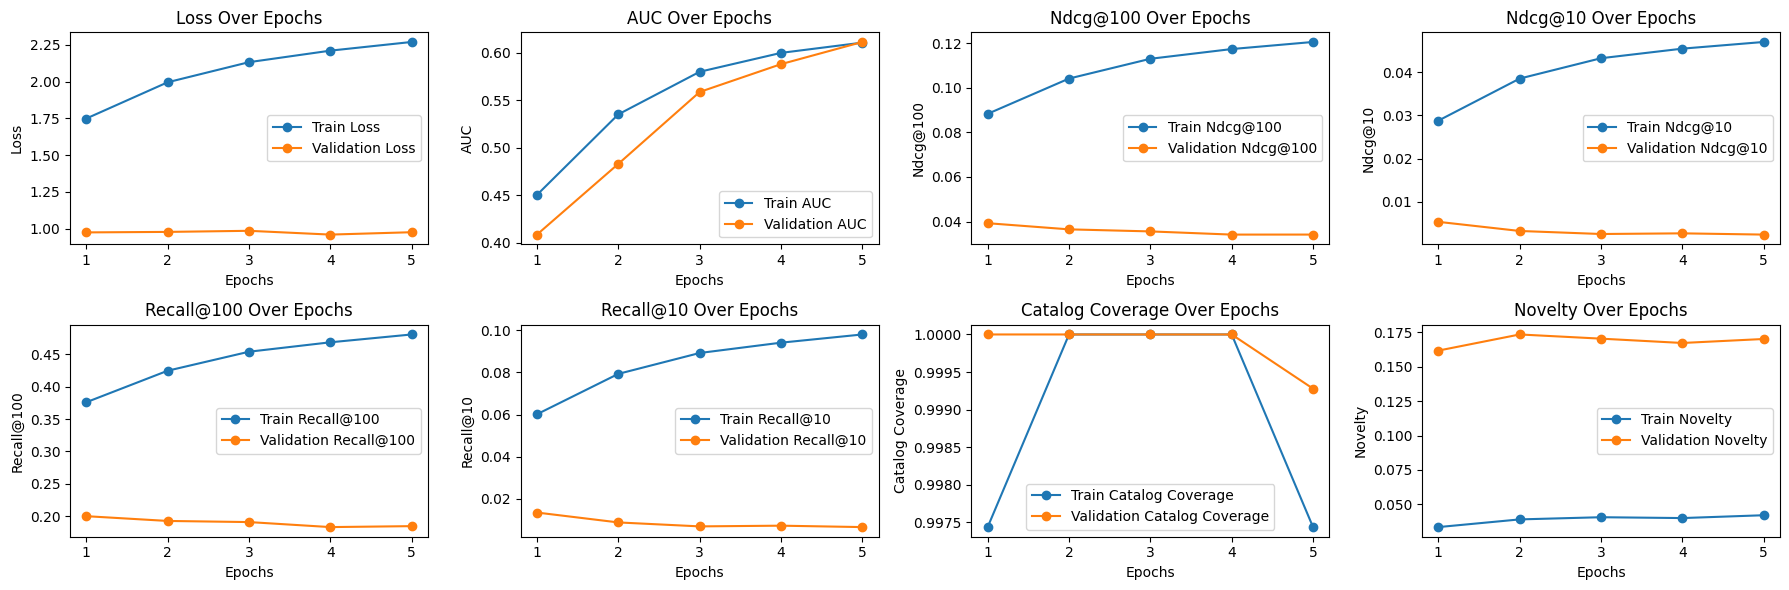

In [66]:
_history = train_evaluation_clbk.get_records()
_history_val = valid_evaluation_clbk.get_records()
AUC_TERM = [k for k in _history if k.startswith('auc')][0]
_metrics  = {
    'Loss': 'loss',
    'AUC': AUC_TERM,
    'Ndcg@100': 'ndcg_at_100',
    'Ndcg@10': 'ndcg_at_10',
    'Recall@100': 'recall_at_100',
    'Recall@10': 'recall_at_10',
    # 'MAP@100':'map_at_100',
    'Catalog Coverage': 'coverage',
    'Novelty':'novelty'
}
print('Plot for model', VERSION)
plot_metrics(_history, _history_val, _metrics)


Plot for model v1


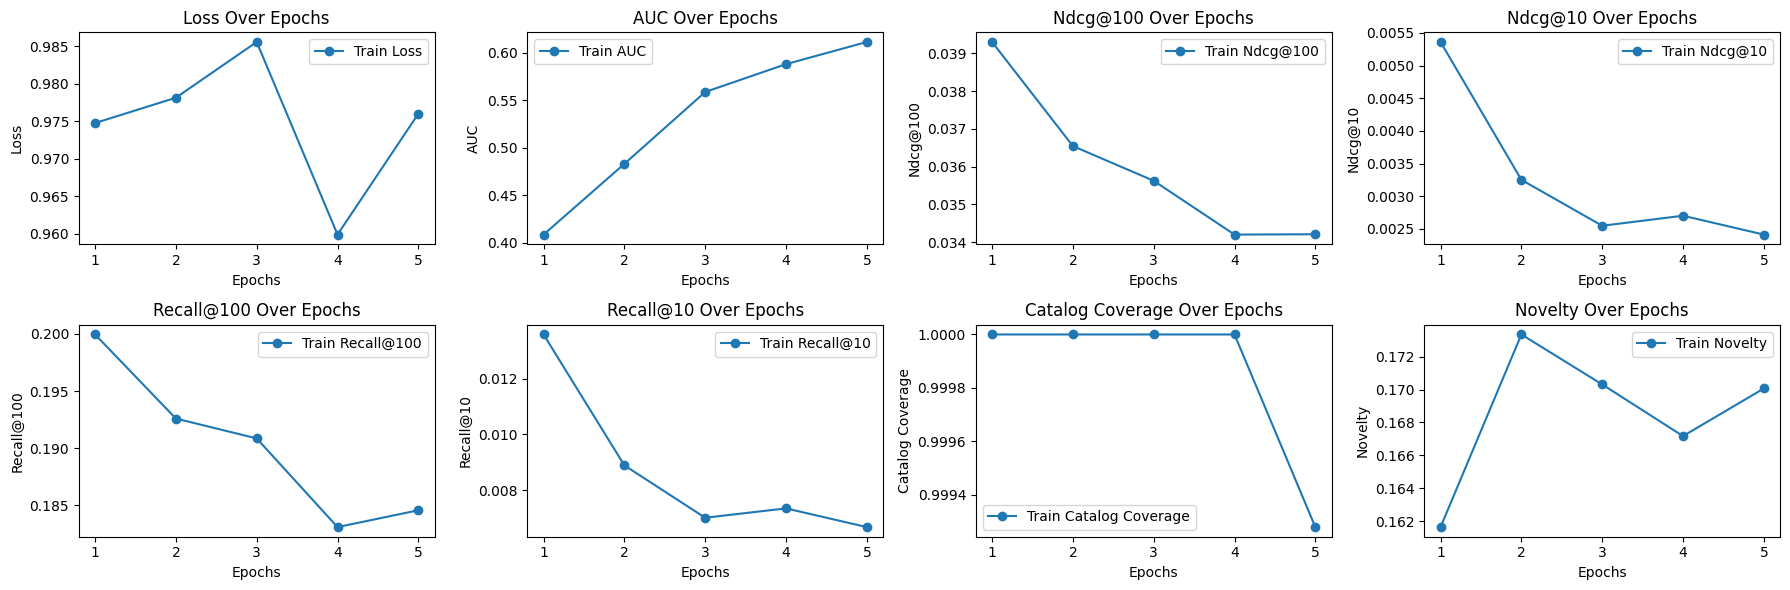

In [67]:
_history = train_evaluation_clbk.get_records()
_history_val = valid_evaluation_clbk.get_records()
AUC_TERM = [k for k in _history if k.startswith('auc')][0]
_metrics  = {
    'Loss': 'loss',
    'AUC': AUC_TERM,
    'Ndcg@100': 'ndcg_at_100',
    'Ndcg@10': 'ndcg_at_10',
    'Recall@100': 'recall_at_100',
    'Recall@10': 'recall_at_10',
    # 'MAP@100':'map_at_100',
    'Catalog Coverage': 'coverage',
    'Novelty':'novelty'
}
print('Plot for model', VERSION)
plot_metrics(_history_val, None, _metrics)


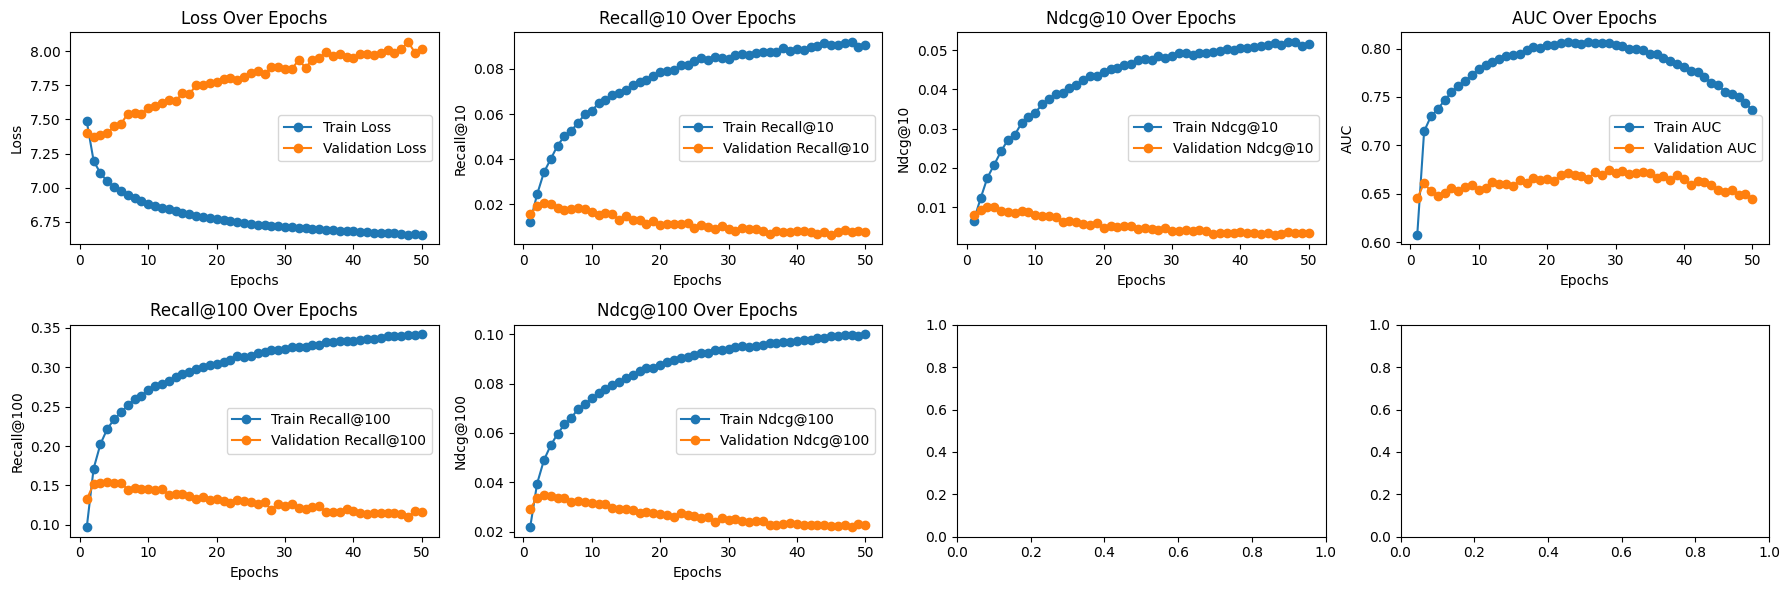

In [68]:
_history = merge_model_history(*history)
# AUC_TERM = [k for k in _history if k.startswith('auc')][0]
METRIC_AT = {'@'.join([k.split('_')[0].title(), k.split('_')[-1]]):k for k in _history if k.startswith('recall') or k.startswith('ndcg')}
val_history = { k[4:]:v for k,v in _history.items() if k.startswith('val')}
plot_metrics(_history, val_history, default_plot_metrics | {'AUC': 'auc', **METRIC_AT,})
# {'AUC': AUC_TERM, 'Recall@100': 'recall_at_100','NDCG@10': 'ndcg_at_10',}

### model_v2

In [ ]:
VERSION = 'v2'

_tower_dim = [256, 128] # @param

_learning_rate = 0.01 # @param
_batch_size = 1024 * 2 # @param
_epochs = 50 # @param
_validation_batch_size = 2048 # @param
_sample_neg = _batch_size * 2 # @param
_validation_freq = 5 # @param
_loss = 'categorical_crossentropy' # @param
# _loss = 'bpr-max' # @param

_logq_sampling_correction = False # @param

embedding_dims = {
    'item': {
        'movie_id': 64,
        'genres': 8*2
    },
    'user': {
        'user_id': 64,
        'gender': 8,
        'occupation': 8*2
    }
}

In [ ]:
if VERSION in models:
    raise RuntimeError('Reusing model version: ', VERSION)

In [ ]:
from merlin.models.tf.outputs.sampling.in_batch import InBatchSamplerV2

sampler = [InBatchSamplerV2(_sample_neg)]

models[VERSION] = model = build_towers(
    train,
    tower_dim=_tower_dim,
    neg_sampler=sampler,
    embedding_dims=embedding_dims,
    logq_sampling_correction=_logq_sampling_correction,
    item_categorical=Tags.CATEGORICAL
)

train_evaluation_clbks[VERSION] = EvaluationCallback(period=5, topk=100, data=train, type_='Train', schema=train.schema)
valid_evaluation_clbks[VERSION] = EvaluationCallback(period=5, topk=100, data=valid, type_='Validation', schema=train.schema)
historys[VERSION] = []

TOP_K = [100, 50, 10]
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
    run_eagerly=False,
    metrics=topk_metrics_aggregator(TOP_K),
    loss=_loss,
)

#### model

In [ ]:
history = historys[VERSION]
model = models[VERSION]
train_evaluation_clbk = train_evaluation_clbks[VERSION]
valid_evaluation_clbk = valid_evaluation_clbks[VERSION]

In [ ]:
# %pdb on
history.append(
    model.fit(train, validation_data=valid, batch_size=_batch_size, epochs=_epochs,
                 validation_batch_size=_validation_batch_size, validation_freq=_validation_freq,
                 callbacks=[train_evaluation_clbk,
                            valid_evaluation_clbk],
                  verbose=1)
)

Epoch 1/50
35/35 [==============================] - 23s 306ms/step - loss: 7.4517 - auc: 0.6313 - recall_at_100: 0.0766 - mrr_at_100: 0.0057 - ndcg_at_100: 0.0175 - map_at_100: 0.0057 - precision_at_100: 7.6571e-04 - recall_at_50: 0.0395 - mrr_at_50: 0.0051 - ndcg_at_50: 0.0115 - map_at_50: 0.0051 - precision_at_50: 7.8982e-04 - recall_at_10: 0.0093 - mrr_at_10: 0.0039 - ndcg_at_10: 0.0052 - map_at_10: 0.0039 - precision_at_10: 9.3371e-04 - regularization_loss: 0.0000e+00 - loss_batch: 7.3834
Epoch 2/50
35/35 [==============================] - 5s 121ms/step - loss: 7.2022 - auc: 0.7072 - recall_at_100: 0.1650 - mrr_at_100: 0.0122 - ndcg_at_100: 0.0380 - map_at_100: 0.0122 - precision_at_100: 0.0016 - recall_at_50: 0.0909 - mrr_at_50: 0.0112 - ndcg_at_50: 0.0260 - map_at_50: 0.0112 - precision_at_50: 0.0018 - recall_at_10: 0.0224 - mrr_at_10: 0.0084 - ndcg_at_10: 0.0116 - map_at_10: 0.0084 - precision_at_10: 0.0022 - regularization_loss: 0.0000e+00 - loss_batch: 7.1369
Epoch 3/50
35/35 

69/69 [==============================] - 5s 17ms/step - loss: 1.4507 - auc: 0.4344 - recall_at_100: 0.3137 - mrr_at_100: 0.0204 - ndcg_at_100: 0.0703 - map_at_100: 0.0204 - precision_at_100: 0.0031 - recall_at_10: 0.0414 - mrr_at_10: 0.0128 - ndcg_at_10: 0.0193 - map_at_10: 0.0128 - precision_at_10: 0.0041 - regularization_loss: 0.0000e+00 - loss_batch: 1.4570
Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.450700283050537, 'auc': 0.43444398045539856, 'recall_at_100': 0.31433576345443726, 'mrr_at_100': 0.0207695122808218, 'ndcg_at_100': 0.07076311111450195, 'map_at_100': 0.0207695122808218, 'precision_at_100': 0.0031433573458343744, 'recall_at_10': 0.04277655854821205, 'mrr_at_10': 0.013233664445579052, 'ndcg_at_10': 0.01998930796980858, 'map_at_10': 0.013233664445579052, 'precision_at_10': 0.0042776563204824924, 'regularization_loss': 0.0, 'loss_batch': 1.7555452585220337, 'coverage': 1.0, 'novelty': 0.022699918155120118}
Candidate set rows: 1387


15/15 [==============================] - 4s 20ms/step - loss: 0.9246 - auc: 0.4292 - recall_at_100: 0.1947 - mrr_at_100: 0.0087 - ndcg_at_100: 0.0394 - map_at_100: 0.0087 - precision_at_100: 0.0019 - recall_at_10: 0.0154 - mrr_at_10: 0.0042 - ndcg_at_10: 0.0068 - map_at_10: 0.0042 - precision_at_10: 0.0015 - regularization_loss: 0.0000e+00 - loss_batch: 0.9862
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9245553612709045, 'auc': 0.4292261302471161, 'recall_at_100': 0.19593419134616852, 'mrr_at_100': 0.009524035267531872, 'ndcg_at_100': 0.040457285940647125, 'map_at_100': 0.009524035267531872, 'precision_at_100': 0.001959341811016202, 'recall_at_10': 0.017520396038889885, 'mrr_at_10': 0.005000042263418436, 'ndcg_at_10': 0.007850210182368755, 'map_at_10': 0.005000042263418436, 'precision_at_10': 0.0017520396504551172, 'regularization_loss': 0.0, 'loss_batch': 1.630541205406189, 'coverage': 1.0, 'novelty': 0.12573333333333334}
35/35 [==============================

69/69 [==============================] - 4s 18ms/step - loss: 1.6729 - auc: 0.4487 - recall_at_100: 0.3586 - mrr_at_100: 0.0256 - ndcg_at_100: 0.0827 - map_at_100: 0.0256 - precision_at_100: 0.0036 - recall_at_10: 0.0530 - mrr_at_10: 0.0170 - ndcg_at_10: 0.0253 - map_at_10: 0.0170 - precision_at_10: 0.0053 - regularization_loss: 0.0000e+00 - loss_batch: 1.6825
Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.6728544235229492, 'auc': 0.44870725274086, 'recall_at_100': 0.3584086000919342, 'mrr_at_100': 0.026279762387275696, 'ndcg_at_100': 0.08320248126983643, 'map_at_100': 0.026279762387275696, 'precision_at_100': 0.0035840854980051517, 'recall_at_10': 0.054656561464071274, 'mrr_at_10': 0.01773594319820404, 'ndcg_at_10': 0.026210462674498558, 'map_at_10': 0.01773594319820404, 'precision_at_10': 0.005465656518936157, 'regularization_loss': 0.0, 'loss_batch': 2.1417653560638428, 'coverage': 0.9993593850096092, 'novelty': 0.04061329083939877}
Candidate set rows: 1387


15/15 [==============================] - 5s 32ms/step - loss: 0.9159 - auc: 0.4032 - recall_at_100: 0.1833 - mrr_at_100: 0.0073 - ndcg_at_100: 0.0362 - map_at_100: 0.0073 - precision_at_100: 0.0018 - recall_at_10: 0.0124 - mrr_at_10: 0.0031 - ndcg_at_10: 0.0052 - map_at_10: 0.0031 - precision_at_10: 0.0012 - regularization_loss: 0.0000e+00 - loss_batch: 0.9811
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9158834218978882, 'auc': 0.4032352566719055, 'recall_at_100': 0.1878427118062973, 'mrr_at_100': 0.007594686467200518, 'ndcg_at_100': 0.03722952678799629, 'map_at_100': 0.007594686467200518, 'precision_at_100': 0.001878427225165069, 'recall_at_10': 0.013374348171055317, 'mrr_at_10': 0.0033344055991619825, 'ndcg_at_10': 0.005608723033219576, 'map_at_10': 0.0033344055991619825, 'precision_at_10': 0.0013374347472563386, 'regularization_loss': 0.0, 'loss_batch': 1.6625498533248901, 'coverage': 1.0, 'novelty': 0.19062057812815847}
35/35 [=============================

69/69 [==============================] - 5s 18ms/step - loss: 1.8795 - auc: 0.5062 - recall_at_100: 0.3992 - mrr_at_100: 0.0309 - ndcg_at_100: 0.0943 - map_at_100: 0.0309 - precision_at_100: 0.0040 - recall_at_10: 0.0655 - mrr_at_10: 0.0214 - ndcg_at_10: 0.0315 - map_at_10: 0.0214 - precision_at_10: 0.0066 - regularization_loss: 0.0000e+00 - loss_batch: 1.8904
Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.8794608116149902, 'auc': 0.5061850547790527, 'recall_at_100': 0.4013561010360718, 'mrr_at_100': 0.0323757641017437, 'ndcg_at_100': 0.09608624875545502, 'map_at_100': 0.0323757641017437, 'precision_at_100': 0.004013560246676207, 'recall_at_10': 0.06861627846956253, 'mrr_at_10': 0.02285512536764145, 'ndcg_at_10': 0.033364225178956985, 'map_at_10': 0.02285512536764145, 'precision_at_10': 0.006861627567559481, 'regularization_loss': 0.0, 'loss_batch': 2.412325620651245, 'coverage': 0.9993593850096092, 'novelty': 0.041123370110330994}
Candidate set rows: 1387


15/15 [==============================] - 4s 32ms/step - loss: 0.9345 - auc: 0.4520 - recall_at_100: 0.1789 - mrr_at_100: 0.0062 - ndcg_at_100: 0.0344 - map_at_100: 0.0062 - precision_at_100: 0.0018 - recall_at_10: 0.0101 - mrr_at_10: 0.0021 - ndcg_at_10: 0.0039 - map_at_10: 0.0021 - precision_at_10: 0.0010 - regularization_loss: 0.0000e+00 - loss_batch: 0.9940
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9345437288284302, 'auc': 0.45196041464805603, 'recall_at_100': 0.18704025447368622, 'mrr_at_100': 0.006452036090195179, 'ndcg_at_100': 0.03593546524643898, 'map_at_100': 0.006452036090195179, 'precision_at_100': 0.0018704024842008948, 'recall_at_10': 0.010030761361122131, 'mrr_at_10': 0.0021426023449748755, 'ndcg_at_10': 0.003915715496987104, 'map_at_10': 0.0021426023449748755, 'precision_at_10': 0.0010030760895460844, 'regularization_loss': 0.0, 'loss_batch': 1.6155928373336792, 'coverage': 1.0, 'novelty': 0.17456497593483894}
35/35 [==========================

69/69 [==============================] - 5s 17ms/step - loss: 2.0096 - auc: 0.5184 - recall_at_100: 0.4251 - mrr_at_100: 0.0364 - ndcg_at_100: 0.1042 - map_at_100: 0.0364 - precision_at_100: 0.0043 - recall_at_10: 0.0789 - mrr_at_10: 0.0262 - ndcg_at_10: 0.0383 - map_at_10: 0.0262 - precision_at_10: 0.0079 - regularization_loss: 0.0000e+00 - loss_batch: 2.0228
Candidate set rows: 943
Train dataset topk evaluation {'loss': 2.0096468925476074, 'auc': 0.5183697938919067, 'recall_at_100': 0.42772287130355835, 'mrr_at_100': 0.036867912858724594, 'ndcg_at_100': 0.10496245324611664, 'map_at_100': 0.036867912858724594, 'precision_at_100': 0.004277228843420744, 'recall_at_10': 0.07910031080245972, 'mrr_at_10': 0.026545757427811623, 'ndcg_at_10': 0.0386384017765522, 'map_at_10': 0.026545757427811623, 'precision_at_10': 0.007910029962658882, 'regularization_loss': 0.0, 'loss_batch': 2.6494081020355225, 'coverage': 1.0, 'novelty': 0.037933947463695245}
Candidate set rows: 1387


15/15 [==============================] - 3s 20ms/step - loss: 0.9382 - auc: 0.4633 - recall_at_100: 0.1798 - mrr_at_100: 0.0056 - ndcg_at_100: 0.0339 - map_at_100: 0.0056 - precision_at_100: 0.0018 - recall_at_10: 0.0078 - mrr_at_10: 0.0016 - ndcg_at_10: 0.0029 - map_at_10: 0.0016 - precision_at_10: 7.8152e-04 - regularization_loss: 0.0000e+00 - loss_batch: 0.9922
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9381605982780457, 'auc': 0.46327170729637146, 'recall_at_100': 0.1838304102420807, 'mrr_at_100': 0.006125845015048981, 'ndcg_at_100': 0.03505486622452736, 'map_at_100': 0.006125845015048981, 'precision_at_100': 0.0018383038695901632, 'recall_at_10': 0.009428915567696095, 'mrr_at_10': 0.001962898066267371, 'ndcg_at_10': 0.003631420899182558, 'map_at_10': 0.001962898066267371, 'precision_at_10': 0.0009428916382603347, 'regularization_loss': 0.0, 'loss_batch': 1.557369351387024, 'coverage': 1.0, 'novelty': 0.16939105442787855}
35/35 [==========================

69/69 [==============================] - 6s 22ms/step - loss: 2.0985 - auc: 0.5587 - recall_at_100: 0.4393 - mrr_at_100: 0.0383 - ndcg_at_100: 0.1084 - map_at_100: 0.0383 - precision_at_100: 0.0044 - recall_at_10: 0.0838 - mrr_at_10: 0.0276 - ndcg_at_10: 0.0406 - map_at_10: 0.0276 - precision_at_10: 0.0084 - regularization_loss: 0.0000e+00 - loss_batch: 2.1121
Candidate set rows: 943
Train dataset topk evaluation {'loss': 2.0984621047973633, 'auc': 0.5587150454521179, 'recall_at_100': 0.44374802708625793, 'mrr_at_100': 0.039011452347040176, 'ndcg_at_100': 0.10979478061199188, 'map_at_100': 0.039011452347040176, 'precision_at_100': 0.00443747965618968, 'recall_at_10': 0.08556736260652542, 'mrr_at_10': 0.028279220685362816, 'ndcg_at_10': 0.04145564138889313, 'map_at_10': 0.028279220685362816, 'precision_at_10': 0.008556736633181572, 'regularization_loss': 0.0, 'loss_batch': 2.7586615085601807, 'coverage': 1.0, 'novelty': 0.04278390272673654}
Candidate set rows: 1387


15/15 [==============================] - 3s 21ms/step - loss: 0.9322 - auc: 0.4904 - recall_at_100: 0.1787 - mrr_at_100: 0.0054 - ndcg_at_100: 0.0335 - map_at_100: 0.0054 - precision_at_100: 0.0018 - recall_at_10: 0.0059 - mrr_at_10: 0.0012 - ndcg_at_10: 0.0022 - map_at_10: 0.0012 - precision_at_10: 5.9455e-04 - regularization_loss: 0.0000e+00 - loss_batch: 0.9808
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9322301149368286, 'auc': 0.49041640758514404, 'recall_at_100': 0.18008559942245483, 'mrr_at_100': 0.005593716632574797, 'ndcg_at_100': 0.033974967896938324, 'map_at_100': 0.005593716632574797, 'precision_at_100': 0.001800855970941484, 'recall_at_10': 0.006887789350003004, 'mrr_at_10': 0.0013730201171711087, 'ndcg_at_10': 0.0026167191099375486, 'map_at_10': 0.0013730201171711087, 'precision_at_10': 0.0006887789350003004, 'regularization_loss': 0.0, 'loss_batch': 1.488382339477539, 'coverage': 1.0, 'novelty': 0.18371322813169688}
35/35 [======================

69/69 [==============================] - 5s 28ms/step - loss: 2.2053 - auc: 0.5926 - recall_at_100: 0.4667 - mrr_at_100: 0.0411 - ndcg_at_100: 0.1157 - map_at_100: 0.0411 - precision_at_100: 0.0047 - recall_at_10: 0.0904 - mrr_at_10: 0.0298 - ndcg_at_10: 0.0438 - map_at_10: 0.0298 - precision_at_10: 0.0090 - regularization_loss: 0.0000e+00 - loss_batch: 2.2176
Candidate set rows: 943
Train dataset topk evaluation {'loss': 2.205334424972534, 'auc': 0.5925614833831787, 'recall_at_100': 0.4677644371986389, 'mrr_at_100': 0.041662801057100296, 'ndcg_at_100': 0.11641126871109009, 'map_at_100': 0.041662801057100296, 'precision_at_100': 0.004677643533796072, 'recall_at_10': 0.09240477532148361, 'mrr_at_10': 0.030305031687021255, 'ndcg_at_10': 0.04459192976355553, 'map_at_10': 0.030305031687021255, 'precision_at_10': 0.009240476414561272, 'regularization_loss': 0.0, 'loss_batch': 2.798342227935791, 'coverage': 1.0, 'novelty': 0.039747102212855635}
Candidate set rows: 1387


15/15 [==============================] - 3s 22ms/step - loss: 0.9320 - auc: 0.5471 - recall_at_100: 0.1700 - mrr_at_100: 0.0051 - ndcg_at_100: 0.0317 - map_at_100: 0.0051 - precision_at_100: 0.0017 - recall_at_10: 0.0078 - mrr_at_10: 0.0014 - ndcg_at_10: 0.0029 - map_at_10: 0.0014 - precision_at_10: 7.8164e-04 - regularization_loss: 0.0000e+00 - loss_batch: 0.9870
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9319728016853333, 'auc': 0.5471240282058716, 'recall_at_100': 0.17787882685661316, 'mrr_at_100': 0.0054692490957677364, 'ndcg_at_100': 0.03338274359703064, 'map_at_100': 0.0054692490957677364, 'precision_at_100': 0.0017787881661206484, 'recall_at_10': 0.008559582754969597, 'mrr_at_10': 0.0016015779692679644, 'ndcg_at_10': 0.0031499324832111597, 'map_at_10': 0.0016015779692679644, 'precision_at_10': 0.0008559582638554275, 'regularization_loss': 0.0, 'loss_batch': 1.5627264976501465, 'coverage': 1.0, 'novelty': 0.17309104258443464}
35/35 [====================

69/69 [==============================] - 5s 18ms/step - loss: 2.2520 - auc: 0.6172 - recall_at_100: 0.4744 - mrr_at_100: 0.0425 - ndcg_at_100: 0.1185 - map_at_100: 0.0425 - precision_at_100: 0.0047 - recall_at_10: 0.0953 - mrr_at_10: 0.0309 - ndcg_at_10: 0.0457 - map_at_10: 0.0309 - precision_at_10: 0.0095 - regularization_loss: 0.0000e+00 - loss_batch: 2.2659
Candidate set rows: 943
Train dataset topk evaluation {'loss': 2.251980781555176, 'auc': 0.6171804666519165, 'recall_at_100': 0.4770946800708771, 'mrr_at_100': 0.04295465350151062, 'ndcg_at_100': 0.1193406879901886, 'map_at_100': 0.04295465350151062, 'precision_at_100': 0.004770947620272636, 'recall_at_10': 0.09652146697044373, 'mrr_at_10': 0.03131059184670448, 'ndcg_at_10': 0.046305228024721146, 'map_at_10': 0.03131059184670448, 'precision_at_10': 0.009652147069573402, 'regularization_loss': 0.0, 'loss_batch': 2.92571759223938, 'coverage': 0.9993593850096092, 'novelty': 0.04092526690391459}
Candidate set rows: 1387


15/15 [==============================] - 4s 27ms/step - loss: 0.9319 - auc: 0.5881 - recall_at_100: 0.1730 - mrr_at_100: 0.0049 - ndcg_at_100: 0.0320 - map_at_100: 0.0049 - precision_at_100: 0.0017 - recall_at_10: 0.0059 - mrr_at_10: 0.0010 - ndcg_at_10: 0.0021 - map_at_10: 0.0010 - precision_at_10: 5.8843e-04 - regularization_loss: 0.0000e+00 - loss_batch: 0.9852
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.931909441947937, 'auc': 0.5881393551826477, 'recall_at_100': 0.17667514085769653, 'mrr_at_100': 0.005196542013436556, 'ndcg_at_100': 0.032921675592660904, 'map_at_100': 0.005196542013436556, 'precision_at_100': 0.0017667512875050306, 'recall_at_10': 0.006553430575877428, 'mrr_at_10': 0.0012283436954021454, 'ndcg_at_10': 0.002415504539385438, 'map_at_10': 0.0012283436954021454, 'precision_at_10': 0.0006553430575877428, 'regularization_loss': 0.0, 'loss_batch': 1.5421251058578491, 'coverage': 1.0, 'novelty': 0.17372881355932204}
35/35 [=======================

69/69 [==============================] - 6s 29ms/step - loss: 2.3061 - auc: 0.6269 - recall_at_100: 0.4859 - mrr_at_100: 0.0439 - ndcg_at_100: 0.1218 - map_at_100: 0.0439 - precision_at_100: 0.0049 - recall_at_10: 0.0984 - mrr_at_10: 0.0320 - ndcg_at_10: 0.0473 - map_at_10: 0.0320 - precision_at_10: 0.0098 - regularization_loss: 0.0000e+00 - loss_batch: 2.3191
Candidate set rows: 943
Train dataset topk evaluation {'loss': 2.3060572147369385, 'auc': 0.6268781423568726, 'recall_at_100': 0.4870801270008087, 'mrr_at_100': 0.04374483600258827, 'ndcg_at_100': 0.12179314345121384, 'map_at_100': 0.04374483600258827, 'precision_at_100': 0.004870801232755184, 'recall_at_10': 0.0981026217341423, 'mrr_at_10': 0.03178185597062111, 'ndcg_at_10': 0.04703488200902939, 'map_at_10': 0.03178185597062111, 'precision_at_10': 0.00981026142835617, 'regularization_loss': 0.0, 'loss_batch': 2.936901092529297, 'coverage': 1.0, 'novelty': 0.04214525139664804}
Candidate set rows: 1387


15/15 [==============================] - 3s 20ms/step - loss: 0.9370 - auc: 0.6216 - recall_at_100: 0.1730 - mrr_at_100: 0.0053 - ndcg_at_100: 0.0325 - map_at_100: 0.0053 - precision_at_100: 0.0017 - recall_at_10: 0.0082 - mrr_at_10: 0.0015 - ndcg_at_10: 0.0030 - map_at_10: 0.0015 - precision_at_10: 8.2329e-04 - regularization_loss: 0.0000e+00 - loss_batch: 0.9932
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9369809627532959, 'auc': 0.6215956211090088, 'recall_at_100': 0.1768757551908493, 'mrr_at_100': 0.005282972939312458, 'ndcg_at_100': 0.03310109302401543, 'map_at_100': 0.005282972939312458, 'precision_at_100': 0.0017687574727460742, 'recall_at_10': 0.007155276369303465, 'mrr_at_10': 0.001272951252758503, 'ndcg_at_10': 0.0025813544634729624, 'map_at_10': 0.001272951252758503, 'precision_at_10': 0.0007155276834964752, 'regularization_loss': 0.0, 'loss_batch': 1.5810022354125977, 'coverage': 1.0, 'novelty': 0.17401734637386973}
35/35 [=========================

69/69 [==============================] - 5s 22ms/step - loss: 2.3572 - auc: 0.6335 - recall_at_100: 0.5037 - mrr_at_100: 0.0464 - ndcg_at_100: 0.1272 - map_at_100: 0.0464 - precision_at_100: 0.0050 - recall_at_10: 0.1053 - mrr_at_10: 0.0339 - ndcg_at_10: 0.0503 - map_at_10: 0.0339 - precision_at_10: 0.0105 - regularization_loss: 0.0000e+00 - loss_batch: 2.3711
Candidate set rows: 943
Train dataset topk evaluation {'loss': 2.3571925163269043, 'auc': 0.6334918737411499, 'recall_at_100': 0.5024073123931885, 'mrr_at_100': 0.0459333136677742, 'ndcg_at_100': 0.12666277587413788, 'map_at_100': 0.0459333136677742, 'precision_at_100': 0.005024073179811239, 'recall_at_10': 0.10489729791879654, 'mrr_at_10': 0.03347828611731529, 'ndcg_at_10': 0.04987850412726402, 'map_at_10': 0.03347828611731529, 'precision_at_10': 0.010489730164408684, 'regularization_loss': 0.0, 'loss_batch': 3.0332484245300293, 'coverage': 0.9993593850096092, 'novelty': 0.03834112624517178}
Candidate set rows: 1387


15/15 [==============================] - 4s 21ms/step - loss: 0.9222 - auc: 0.6392 - recall_at_100: 0.1691 - mrr_at_100: 0.0045 - ndcg_at_100: 0.0309 - map_at_100: 0.0045 - precision_at_100: 0.0017 - recall_at_10: 0.0046 - mrr_at_10: 7.2284e-04 - ndcg_at_10: 0.0016 - map_at_10: 7.2284e-04 - precision_at_10: 4.5946e-04 - regularization_loss: 0.0000e+00 - loss_batch: 0.9646
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.922177255153656, 'auc': 0.6392099857330322, 'recall_at_100': 0.17326468229293823, 'mrr_at_100': 0.0048625050112605095, 'ndcg_at_100': 0.03196272999048233, 'map_at_100': 0.0048625050112605095, 'precision_at_100': 0.0017326467204838991, 'recall_at_10': 0.005349738989025354, 'mrr_at_10': 0.0010010063415393233, 'ndcg_at_10': 0.0019729326013475657, 'map_at_10': 0.0010010063415393233, 'precision_at_10': 0.0005349739221855998, 'regularization_loss': 0.0, 'loss_batch': 1.4082874059677124, 'coverage': 1.0, 'novelty': 0.16643134486410166}
35/35 [=============

69/69 [==============================] - 7s 19ms/step - loss: 2.3662 - auc: 0.6286 - recall_at_100: 0.4959 - mrr_at_100: 0.0450 - ndcg_at_100: 0.1246 - map_at_100: 0.0450 - precision_at_100: 0.0050 - recall_at_10: 0.1022 - mrr_at_10: 0.0327 - ndcg_at_10: 0.0487 - map_at_10: 0.0327 - precision_at_10: 0.0102 - regularization_loss: 0.0000e+00 - loss_batch: 2.3801
Candidate set rows: 943
Train dataset topk evaluation {'loss': 2.366194248199463, 'auc': 0.6286464929580688, 'recall_at_100': 0.4997008740901947, 'mrr_at_100': 0.045407574623823166, 'ndcg_at_100': 0.12562337517738342, 'map_at_100': 0.045407574623823166, 'precision_at_100': 0.004997008480131626, 'recall_at_10': 0.1030455008149147, 'mrr_at_10': 0.0330708883702755, 'ndcg_at_10': 0.04914490133523941, 'map_at_10': 0.0330708883702755, 'precision_at_10': 0.01030454970896244, 'regularization_loss': 0.0, 'loss_batch': 3.042048215866089, 'coverage': 0.9993593850096092, 'novelty': 0.044921875}
Candidate set rows: 1387


15/15 [==============================] - 3s 20ms/step - loss: 0.9445 - auc: 0.6491 - recall_at_100: 0.1691 - mrr_at_100: 0.0048 - ndcg_at_100: 0.0313 - map_at_100: 0.0048 - precision_at_100: 0.0017 - recall_at_10: 0.0053 - mrr_at_10: 0.0010 - ndcg_at_10: 0.0020 - map_at_10: 0.0010 - precision_at_10: 5.3061e-04 - regularization_loss: 0.0000e+00 - loss_batch: 0.9892
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.944548487663269, 'auc': 0.649059534072876, 'recall_at_100': 0.17634077370166779, 'mrr_at_100': 0.00501843448728323, 'ndcg_at_100': 0.032658763229846954, 'map_at_100': 0.00501843448728323, 'precision_at_100': 0.0017634077230468392, 'recall_at_10': 0.0055503542535007, 'mrr_at_10': 0.0010818627197295427, 'ndcg_at_10': 0.002081438433378935, 'map_at_10': 0.0010818627197295427, 'precision_at_10': 0.0005550354835577309, 'regularization_loss': 0.0, 'loss_batch': 1.4558539390563965, 'coverage': 1.0, 'novelty': 0.17795810530288733}
35/35 [============================

#### analysis

In [ ]:
history = historys[VERSION]
model = models[VERSION]
train_evaluation_clbk = train_evaluation_clbks[VERSION]
valid_evaluation_clbk = valid_evaluation_clbks[VERSION]

Plot for model v2


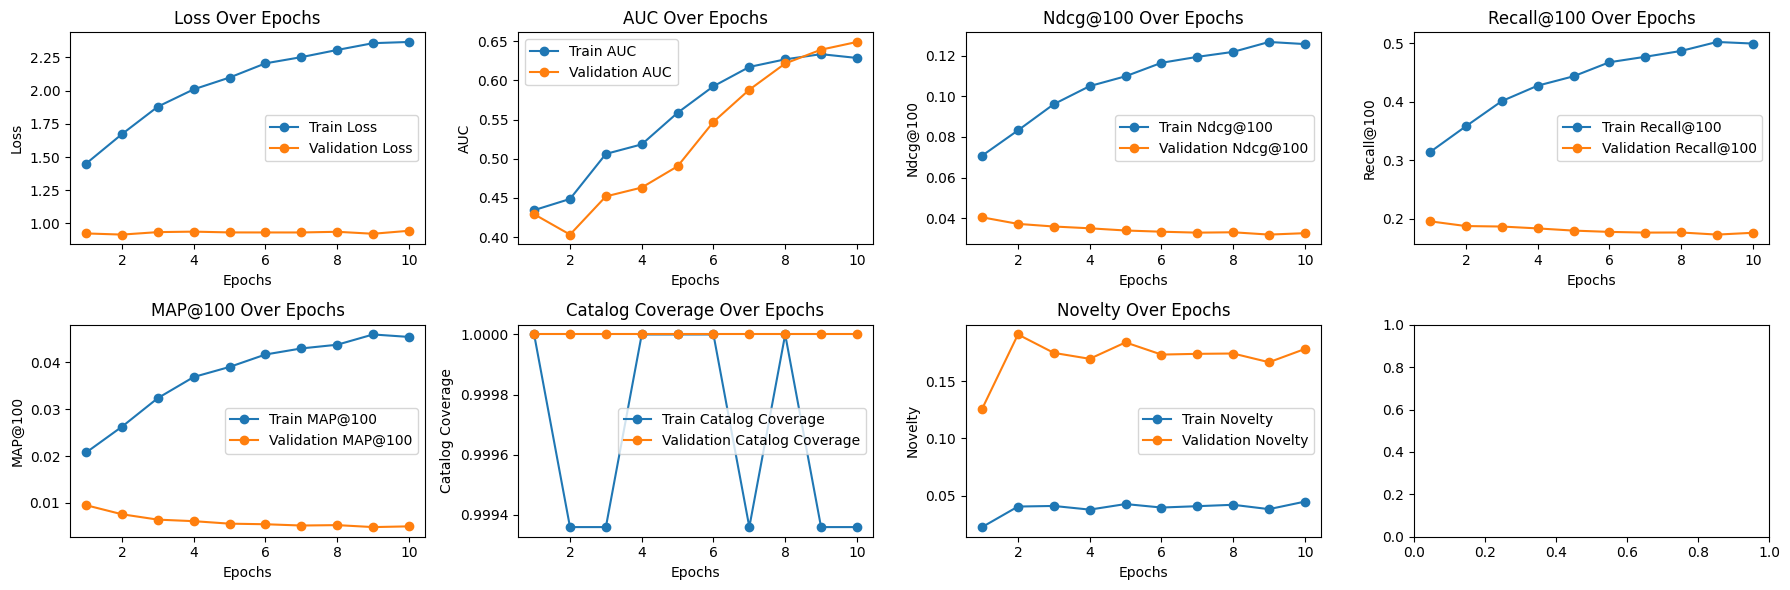

In [ ]:
_history = train_evaluation_clbk.get_records()
_history_val = valid_evaluation_clbk.get_records()
AUC_TERM = [k for k in _history if k.startswith('auc')][0]
_metrics  = {
    'Loss': 'loss',
    'AUC': AUC_TERM,
    'Ndcg@100': 'ndcg_at_100',
    'Recall@100': 'recall_at_100',
    'MAP@100':'map_at_100',
    'Catalog Coverage': 'coverage',
    'Novelty':'novelty'
}
print('Plot for model', VERSION)
plot_metrics(_history, _history_val, _metrics)


Plot for model v10


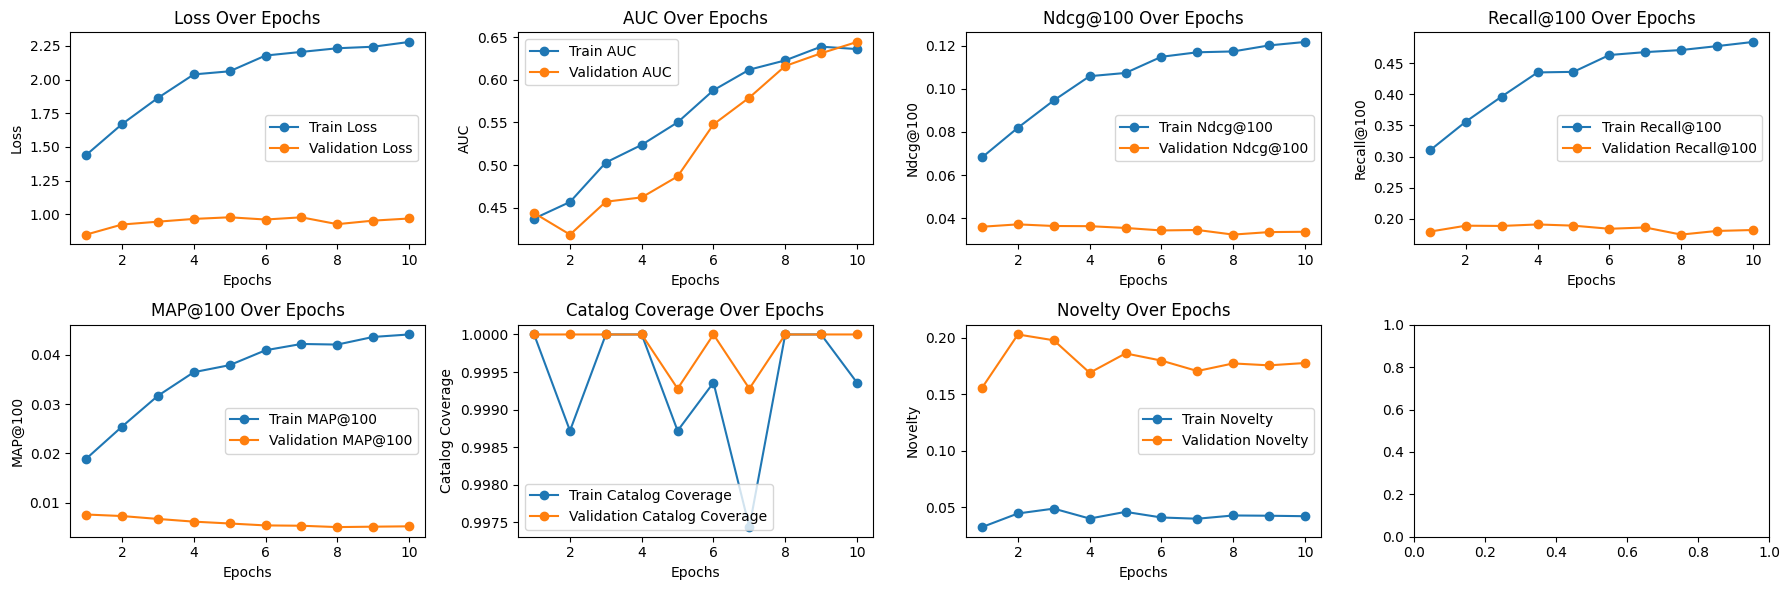

In [ ]:
_history = train_evaluation_clbk.get_records()
_history_val = valid_evaluation_clbk.get_records()
AUC_TERM = [k for k in _history if k.startswith('auc')][0]
_metrics  = {
    'Loss': 'loss',
    'AUC': AUC_TERM,
    'Ndcg@100': 'ndcg_at_100',
    'Recall@100': 'recall_at_100',
    'MAP@100':'map_at_100',
    'Catalog Coverage': 'coverage',
    'Novelty':'novelty'
}
print('Plot for model', VERSION)
plot_metrics(_history, _history_val, _metrics)


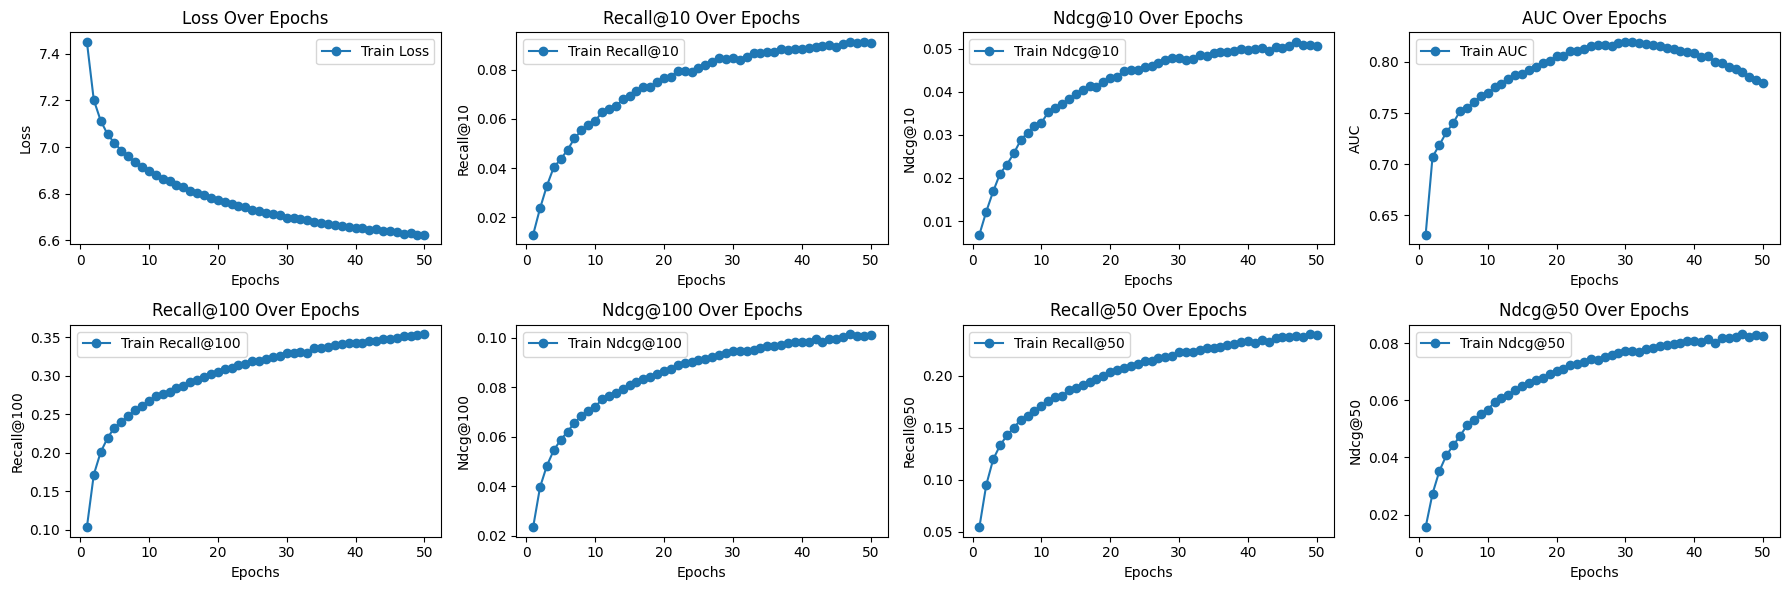

In [ ]:
_history = merge_model_history(*history)
# AUC_TERM = [k for k in _history if k.startswith('auc')][0]
METRIC_AT = {'@'.join([k.split('_')[0].title(), k.split('_')[-1]]):k for k in _history if k.startswith('recall') or k.startswith('ndcg')}
val_history = { k[4:]:v for k,v in _history.items() if k.startswith('val')}
plot_metrics(_history, None, default_plot_metrics | {'AUC': 'auc', **METRIC_AT,})
# {'AUC': AUC_TERM, 'Recall@100': 'recall_at_100','NDCG@10': 'ndcg_at_10',}

### model_v3

In [ ]:
VERSION = 'v3'

_tower_dim = [256, 128] # @param

_learning_rate = 0.01 # @param
_batch_size = 1024 * 4 # @param
_epochs = 50 # @param
_validation_batch_size = 2048 # @param
_sample_neg = _batch_size * 2 # @param
_validation_freq = 5 # @param
_loss = 'categorical_crossentropy' # @param
# _loss = 'bpr-max' # @param

_logq_sampling_correction = False # @param

embedding_dims = {
    'item': {
        'movie_id': 64,
        'genres': 8*2
    },
    'user': {
        'user_id': 64,
        'gender': 8,
        'occupation': 8*2
    }
}

In [ ]:
if VERSION in models:
    raise RuntimeError('Reusing model version: ', VERSION)

In [ ]:
from merlin.models.tf.outputs.sampling.in_batch import InBatchSamplerV2

sampler = [InBatchSamplerV2(_sample_neg)]

models[VERSION] = model = build_towers(
    train,
    tower_dim=_tower_dim,
    neg_sampler=sampler,
    embedding_dims=embedding_dims,
    logq_sampling_correction=_logq_sampling_correction,
    item_categorical=Tags.CATEGORICAL
)

train_evaluation_clbks[VERSION] = EvaluationCallback(period=5, topk=100, data=train, type_='Train', schema=train.schema)
valid_evaluation_clbks[VERSION] = EvaluationCallback(period=5, topk=100, data=valid, type_='Validation', schema=train.schema)
historys[VERSION] = []

TOP_K = [100, 50, 10]
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
    run_eagerly=False,
    metrics=topk_metrics_aggregator(TOP_K),
    loss=_loss,
)

#### model

In [ ]:
history = historys[VERSION]
model = models[VERSION]
train_evaluation_clbk = train_evaluation_clbks[VERSION]
valid_evaluation_clbk = valid_evaluation_clbks[VERSION]

In [ ]:
# %pdb on
history.append(
    model.fit(train, validation_data=valid, batch_size=_batch_size, epochs=_epochs,
                 validation_batch_size=_validation_batch_size, validation_freq=_validation_freq,
                 callbacks=[train_evaluation_clbk,
                            valid_evaluation_clbk],
                  verbose=1)
)

Epoch 1/50
18/18 [==============================] - 22s 467ms/step - loss: 8.2338 - auc: 0.5748 - recall_at_100: 0.0330 - mrr_at_100: 0.0028 - ndcg_at_100: 0.0079 - map_at_100: 0.0028 - precision_at_100: 3.3031e-04 - recall_at_50: 0.0171 - mrr_at_50: 0.0026 - ndcg_at_50: 0.0053 - map_at_50: 0.0026 - precision_at_50: 3.4155e-04 - recall_at_10: 0.0045 - mrr_at_10: 0.0021 - ndcg_at_10: 0.0027 - map_at_10: 0.0021 - precision_at_10: 4.5351e-04 - regularization_loss: 0.0000e+00 - loss_batch: 8.0263
Epoch 2/50
18/18 [==============================] - 5s 206ms/step - loss: 7.9641 - auc: 0.7039 - recall_at_100: 0.0778 - mrr_at_100: 0.0066 - ndcg_at_100: 0.0186 - map_at_100: 0.0066 - precision_at_100: 7.7775e-04 - recall_at_50: 0.0425 - mrr_at_50: 0.0061 - ndcg_at_50: 0.0129 - map_at_50: 0.0061 - precision_at_50: 8.5075e-04 - recall_at_10: 0.0114 - mrr_at_10: 0.0048 - ndcg_at_10: 0.0063 - map_at_10: 0.0048 - precision_at_10: 0.0011 - regularization_loss: 0.0000e+00 - loss_batch: 7.7577
Epoch 3/5

69/69 [==============================] - 6s 29ms/step - loss: 1.2540 - auc: 0.4601 - recall_at_100: 0.2681 - mrr_at_100: 0.0160 - ndcg_at_100: 0.0585 - map_at_100: 0.0160 - precision_at_100: 0.0027 - recall_at_10: 0.0331 - mrr_at_10: 0.0098 - ndcg_at_10: 0.0151 - map_at_10: 0.0098 - precision_at_10: 0.0033 - regularization_loss: 0.0000e+00 - loss_batch: 1.2694
Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.2540326118469238, 'auc': 0.460082083940506, 'recall_at_100': 0.26848238706588745, 'mrr_at_100': 0.016158150508999825, 'ndcg_at_100': 0.058669716119766235, 'map_at_100': 0.016158150508999825, 'precision_at_100': 0.0026848234701901674, 'recall_at_10': 0.032848067581653595, 'mrr_at_10': 0.009943155571818352, 'ndcg_at_10': 0.01518954522907734, 'map_at_10': 0.009943155571818352, 'precision_at_10': 0.0032848073169589043, 'regularization_loss': 0.0, 'loss_batch': 1.9979944229125977, 'coverage': 1.0, 'novelty': 0.03607636099315199}
Candidate set rows: 1387


15/15 [==============================] - 3s 20ms/step - loss: 0.8486 - auc: 0.4653 - recall_at_100: 0.1696 - mrr_at_100: 0.0075 - ndcg_at_100: 0.0343 - map_at_100: 0.0075 - precision_at_100: 0.0017 - recall_at_10: 0.0146 - mrr_at_10: 0.0037 - ndcg_at_10: 0.0062 - map_at_10: 0.0037 - precision_at_10: 0.0015 - regularization_loss: 0.0000e+00 - loss_batch: 0.9237
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.8485943078994751, 'auc': 0.46530160307884216, 'recall_at_100': 0.17814631760120392, 'mrr_at_100': 0.008358575403690338, 'ndcg_at_100': 0.03637535497546196, 'map_at_100': 0.008358575403690338, 'precision_at_100': 0.0017814630409702659, 'recall_at_10': 0.01584860309958458, 'mrr_at_10': 0.004373014438897371, 'ndcg_at_10': 0.0069615901447832584, 'map_at_10': 0.004373014438897371, 'precision_at_10': 0.0015848602633923292, 'regularization_loss': 0.0, 'loss_batch': 1.7085343599319458, 'coverage': 1.0, 'novelty': 0.16994052982519373}
18/18 [============================

69/69 [==============================] - 6s 28ms/step - loss: 1.7205 - auc: 0.4748 - recall_at_100: 0.3623 - mrr_at_100: 0.0250 - ndcg_at_100: 0.0826 - map_at_100: 0.0250 - precision_at_100: 0.0036 - recall_at_10: 0.0528 - mrr_at_10: 0.0165 - ndcg_at_10: 0.0248 - map_at_10: 0.0165 - precision_at_10: 0.0053 - regularization_loss: 0.0000e+00 - loss_batch: 1.7399
Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.7205226421356201, 'auc': 0.4747985601425171, 'recall_at_100': 0.3660579323768616, 'mrr_at_100': 0.026326337829232216, 'ndcg_at_100': 0.08444422483444214, 'map_at_100': 0.026326337829232216, 'precision_at_100': 0.0036605792120099068, 'recall_at_10': 0.054884474724531174, 'mrr_at_10': 0.017661230638623238, 'ndcg_at_10': 0.026200098916888237, 'map_at_10': 0.017661230638623238, 'precision_at_10': 0.0054884483106434345, 'regularization_loss': 0.0, 'loss_batch': 2.6599318981170654, 'coverage': 1.0, 'novelty': 0.03731845344097511}
Candidate set rows: 1387


15/15 [==============================] - 3s 20ms/step - loss: 0.9371 - auc: 0.4671 - recall_at_100: 0.1860 - mrr_at_100: 0.0068 - ndcg_at_100: 0.0362 - map_at_100: 0.0068 - precision_at_100: 0.0019 - recall_at_10: 0.0114 - mrr_at_10: 0.0025 - ndcg_at_10: 0.0045 - map_at_10: 0.0025 - precision_at_10: 0.0011 - regularization_loss: 0.0000e+00 - loss_batch: 0.9976
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9371123313903809, 'auc': 0.4671098589897156, 'recall_at_100': 0.1906513273715973, 'mrr_at_100': 0.007313276641070843, 'ndcg_at_100': 0.03743205964565277, 'map_at_100': 0.007313276641070843, 'precision_at_100': 0.00190651323646307, 'recall_at_10': 0.012571887113153934, 'mrr_at_10': 0.0029044358525425196, 'ndcg_at_10': 0.005085775163024664, 'map_at_10': 0.0029044358525425196, 'precision_at_10': 0.001257188618183136, 'regularization_loss': 0.0, 'loss_batch': 1.6300443410873413, 'coverage': 1.0, 'novelty': 0.16923905240488155}
18/18 [==============================]

69/69 [==============================] - 4s 18ms/step - loss: 1.8726 - auc: 0.4871 - recall_at_100: 0.3945 - mrr_at_100: 0.0317 - ndcg_at_100: 0.0944 - map_at_100: 0.0317 - precision_at_100: 0.0039 - recall_at_10: 0.0669 - mrr_at_10: 0.0223 - ndcg_at_10: 0.0325 - map_at_10: 0.0223 - precision_at_10: 0.0067 - regularization_loss: 0.0000e+00 - loss_batch: 1.8924
Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.8726227283477783, 'auc': 0.487107515335083, 'recall_at_100': 0.39897724986076355, 'mrr_at_100': 0.032806482166051865, 'ndcg_at_100': 0.09610913693904877, 'map_at_100': 0.032806482166051865, 'precision_at_100': 0.003989771939814091, 'recall_at_10': 0.0691290870308876, 'mrr_at_10': 0.023325230926275253, 'ndcg_at_10': 0.03385855257511139, 'map_at_10': 0.023325230926275253, 'precision_at_10': 0.006912908982485533, 'regularization_loss': 0.0, 'loss_batch': 2.8296115398406982, 'coverage': 0.9993593850096092, 'novelty': 0.03563869992441421}
Candidate set rows: 1387


15/15 [==============================] - 5s 29ms/step - loss: 0.9736 - auc: 0.4523 - recall_at_100: 0.1884 - mrr_at_100: 0.0066 - ndcg_at_100: 0.0363 - map_at_100: 0.0066 - precision_at_100: 0.0019 - recall_at_10: 0.0103 - mrr_at_10: 0.0023 - ndcg_at_10: 0.0041 - map_at_10: 0.0023 - precision_at_10: 0.0010 - regularization_loss: 0.0000e+00 - loss_batch: 1.0228
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9736402034759521, 'auc': 0.45230576395988464, 'recall_at_100': 0.1939949244260788, 'mrr_at_100': 0.0071121398359537125, 'ndcg_at_100': 0.03769390657544136, 'map_at_100': 0.0071121398359537125, 'precision_at_100': 0.0019399492302909493, 'recall_at_10': 0.011501939035952091, 'mrr_at_10': 0.0026699071750044823, 'ndcg_at_10': 0.004661167040467262, 'map_at_10': 0.0026699071750044823, 'precision_at_10': 0.0011501939734444022, 'regularization_loss': 0.0, 'loss_batch': 1.5369559526443481, 'coverage': 1.0, 'novelty': 0.15706195869420386}
18/18 [=========================

69/69 [==============================] - 5s 18ms/step - loss: 2.0520 - auc: 0.5001 - recall_at_100: 0.4321 - mrr_at_100: 0.0364 - ndcg_at_100: 0.1053 - map_at_100: 0.0364 - precision_at_100: 0.0043 - recall_at_10: 0.0792 - mrr_at_10: 0.0259 - ndcg_at_10: 0.0382 - map_at_10: 0.0259 - precision_at_10: 0.0079 - regularization_loss: 0.0000e+00 - loss_batch: 2.0724
Candidate set rows: 943
Train dataset topk evaluation {'loss': 2.0520477294921875, 'auc': 0.5000914931297302, 'recall_at_100': 0.4339050054550171, 'mrr_at_100': 0.037677403539419174, 'ndcg_at_100': 0.10678587853908539, 'map_at_100': 0.037677403539419174, 'precision_at_100': 0.004339050035923719, 'recall_at_10': 0.08118002116680145, 'mrr_at_10': 0.027178799733519554, 'ndcg_at_10': 0.0396139957010746, 'map_at_10': 0.027178799733519554, 'precision_at_10': 0.008118003606796265, 'regularization_loss': 0.0, 'loss_batch': 3.037290334701538, 'coverage': 0.9987187700192185, 'novelty': 0.03876988858282284}
Candidate set rows: 1387


15/15 [==============================] - 3s 21ms/step - loss: 0.9594 - auc: 0.4355 - recall_at_100: 0.1781 - mrr_at_100: 0.0053 - ndcg_at_100: 0.0332 - map_at_100: 0.0053 - precision_at_100: 0.0018 - recall_at_10: 0.0063 - mrr_at_10: 0.0014 - ndcg_at_10: 0.0025 - map_at_10: 0.0014 - precision_at_10: 6.3160e-04 - regularization_loss: 0.0000e+00 - loss_batch: 1.0140
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9593762755393982, 'auc': 0.43554237484931946, 'recall_at_100': 0.18389728665351868, 'mrr_at_100': 0.005826929584145546, 'ndcg_at_100': 0.03469298034906387, 'map_at_100': 0.005826929584145546, 'precision_at_100': 0.0018389730248600245, 'recall_at_10': 0.007289019878953695, 'mrr_at_10': 0.001643134281039238, 'ndcg_at_10': 0.0029178368858993053, 'map_at_10': 0.001643134281039238, 'precision_at_10': 0.0007289020577445626, 'regularization_loss': 0.0, 'loss_batch': 1.5850950479507446, 'coverage': 1.0, 'novelty': 0.16529360210341806}
18/18 [=======================

69/69 [==============================] - 6s 21ms/step - loss: 2.1429 - auc: 0.5142 - recall_at_100: 0.4531 - mrr_at_100: 0.0394 - ndcg_at_100: 0.1118 - map_at_100: 0.0394 - precision_at_100: 0.0045 - recall_at_10: 0.0866 - mrr_at_10: 0.0283 - ndcg_at_10: 0.0417 - map_at_10: 0.0283 - precision_at_10: 0.0087 - regularization_loss: 0.0000e+00 - loss_batch: 2.1653
Candidate set rows: 943
Train dataset topk evaluation {'loss': 2.142930746078491, 'auc': 0.5142402052879333, 'recall_at_100': 0.4536053240299225, 'mrr_at_100': 0.040524356067180634, 'ndcg_at_100': 0.1129583939909935, 'map_at_100': 0.040524356067180634, 'precision_at_100': 0.004536052234470844, 'recall_at_10': 0.08915700763463974, 'mrr_at_10': 0.029505915939807892, 'ndcg_at_10': 0.0432254895567894, 'map_at_10': 0.029505915939807892, 'precision_at_10': 0.008915700949728489, 'regularization_loss': 0.0, 'loss_batch': 3.226247787475586, 'coverage': 0.9987187700192185, 'novelty': 0.04192788226401672}
Candidate set rows: 1387


15/15 [==============================] - 3s 21ms/step - loss: 0.9076 - auc: 0.4248 - recall_at_100: 0.1681 - mrr_at_100: 0.0047 - ndcg_at_100: 0.0310 - map_at_100: 0.0047 - precision_at_100: 0.0017 - recall_at_10: 0.0055 - mrr_at_10: 9.7304e-04 - ndcg_at_10: 0.0020 - map_at_10: 9.7304e-04 - precision_at_10: 5.4953e-04 - regularization_loss: 0.0000e+00 - loss_batch: 0.9597
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9076355695724487, 'auc': 0.4247729778289795, 'recall_at_100': 0.17192724347114563, 'mrr_at_100': 0.004966572858393192, 'ndcg_at_100': 0.031931810081005096, 'map_at_100': 0.004966572858393192, 'precision_at_100': 0.0017192725790664554, 'recall_at_10': 0.006754045840352774, 'mrr_at_10': 0.0011527945753186941, 'ndcg_at_10': 0.0023965181317180395, 'map_at_10': 0.0011527945753186941, 'precision_at_10': 0.0006754046771675348, 'regularization_loss': 0.0, 'loss_batch': 1.5045801401138306, 'coverage': 0.9992790194664743, 'novelty': 0.17264738191138776}
18/18

69/69 [==============================] - 5s 28ms/step - loss: 2.2973 - auc: 0.5191 - recall_at_100: 0.4892 - mrr_at_100: 0.0435 - ndcg_at_100: 0.1222 - map_at_100: 0.0435 - precision_at_100: 0.0049 - recall_at_10: 0.0996 - mrr_at_10: 0.0314 - ndcg_at_10: 0.0471 - map_at_10: 0.0314 - precision_at_10: 0.0100 - regularization_loss: 0.0000e+00 - loss_batch: 2.3158
Candidate set rows: 943
Train dataset topk evaluation {'loss': 2.29726243019104, 'auc': 0.5190882086753845, 'recall_at_100': 0.4892738163471222, 'mrr_at_100': 0.04488224908709526, 'ndcg_at_100': 0.12340493500232697, 'map_at_100': 0.04488224908709526, 'precision_at_100': 0.0048927380703389645, 'recall_at_10': 0.10166376829147339, 'mrr_at_10': 0.03279272839426994, 'ndcg_at_10': 0.04863143712282181, 'map_at_10': 0.03279272839426994, 'precision_at_10': 0.010166377760469913, 'regularization_loss': 0.0, 'loss_batch': 3.198376178741455, 'coverage': 1.0, 'novelty': 0.03715963273830634}
Candidate set rows: 1387


15/15 [==============================] - 3s 21ms/step - loss: 0.8937 - auc: 0.3926 - recall_at_100: 0.1623 - mrr_at_100: 0.0043 - ndcg_at_100: 0.0297 - map_at_100: 0.0043 - precision_at_100: 0.0016 - recall_at_10: 0.0049 - mrr_at_10: 8.1233e-04 - ndcg_at_10: 0.0017 - map_at_10: 8.1233e-04 - precision_at_10: 4.8846e-04 - regularization_loss: 0.0000e+00 - loss_batch: 0.9376
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.8936988711357117, 'auc': 0.3925538957118988, 'recall_at_100': 0.16764745116233826, 'mrr_at_100': 0.004467897582799196, 'ndcg_at_100': 0.030646905303001404, 'map_at_100': 0.004467897582799196, 'precision_at_100': 0.0016764744650572538, 'recall_at_10': 0.004747893661260605, 'mrr_at_10': 0.0008158352575264871, 'ndcg_at_10': 0.001693759928457439, 'map_at_10': 0.0008158352575264871, 'precision_at_10': 0.0004747893544845283, 'regularization_loss': 0.0, 'loss_batch': 1.3966937065124512, 'coverage': 1.0, 'novelty': 0.16360166551006244}
18/18 [==============

69/69 [==============================] - 6s 28ms/step - loss: 2.3783 - auc: 0.5494 - recall_at_100: 0.5000 - mrr_at_100: 0.0444 - ndcg_at_100: 0.1248 - map_at_100: 0.0444 - precision_at_100: 0.0050 - recall_at_10: 0.1007 - mrr_at_10: 0.0318 - ndcg_at_10: 0.0477 - map_at_10: 0.0318 - precision_at_10: 0.0101 - regularization_loss: 0.0000e+00 - loss_batch: 2.3968
Candidate set rows: 943
Train dataset topk evaluation {'loss': 2.3782968521118164, 'auc': 0.5494202375411987, 'recall_at_100': 0.5036893486976624, 'mrr_at_100': 0.045687235891819, 'ndcg_at_100': 0.1266041249036789, 'map_at_100': 0.045687235891819, 'precision_at_100': 0.005036893766373396, 'recall_at_10': 0.10390017181634903, 'mrr_at_10': 0.03318535163998604, 'ndcg_at_10': 0.049422167241573334, 'map_at_10': 0.03318535163998604, 'precision_at_10': 0.010390017181634903, 'regularization_loss': 0.0, 'loss_batch': 3.2761175632476807, 'coverage': 1.0, 'novelty': 0.039977954892318125}
Candidate set rows: 1387


15/15 [==============================] - 3s 22ms/step - loss: 0.8500 - auc: 0.4381 - recall_at_100: 0.1519 - mrr_at_100: 0.0039 - ndcg_at_100: 0.0276 - map_at_100: 0.0039 - precision_at_100: 0.0015 - recall_at_10: 0.0035 - mrr_at_10: 6.4538e-04 - ndcg_at_10: 0.0013 - map_at_10: 6.4538e-04 - precision_at_10: 3.4723e-04 - regularization_loss: 0.0000e+00 - loss_batch: 0.9078
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.8499851822853088, 'auc': 0.4380994141101837, 'recall_at_100': 0.15668047964572906, 'mrr_at_100': 0.004115920513868332, 'ndcg_at_100': 0.02850589156150818, 'map_at_100': 0.004115920513868332, 'precision_at_100': 0.0015668049454689026, 'recall_at_10': 0.003811689093708992, 'mrr_at_10': 0.0007398350280709565, 'ndcg_at_10': 0.0014283392811194062, 'map_at_10': 0.0007398350280709565, 'precision_at_10': 0.00038116893847472966, 'regularization_loss': 0.0, 'loss_batch': 1.5123406648635864, 'coverage': 1.0, 'novelty': 0.16997116077865898}
18/18 [=============

69/69 [==============================] - 4s 18ms/step - loss: 2.5036 - auc: 0.5649 - recall_at_100: 0.5320 - mrr_at_100: 0.0473 - ndcg_at_100: 0.1331 - map_at_100: 0.0473 - precision_at_100: 0.0053 - recall_at_10: 0.1096 - mrr_at_10: 0.0339 - ndcg_at_10: 0.0513 - map_at_10: 0.0339 - precision_at_10: 0.0110 - regularization_loss: 0.0000e+00 - loss_batch: 2.5229
Candidate set rows: 943
Train dataset topk evaluation {'loss': 2.5035781860351562, 'auc': 0.5649489164352417, 'recall_at_100': 0.530853807926178, 'mrr_at_100': 0.04850323498249054, 'ndcg_at_100': 0.13398662209510803, 'map_at_100': 0.04850323498249054, 'precision_at_100': 0.005308537278324366, 'recall_at_10': 0.11144981533288956, 'mrr_at_10': 0.03521297872066498, 'ndcg_at_10': 0.052721843123435974, 'map_at_10': 0.03521297872066498, 'precision_at_10': 0.011144982650876045, 'regularization_loss': 0.0, 'loss_batch': 3.440194606781006, 'coverage': 0.9993593850096092, 'novelty': 0.040463419866981334}
Candidate set rows: 1387


15/15 [==============================] - 4s 21ms/step - loss: 0.8114 - auc: 0.4360 - recall_at_100: 0.1436 - mrr_at_100: 0.0036 - ndcg_at_100: 0.0259 - map_at_100: 0.0036 - precision_at_100: 0.0014 - recall_at_10: 0.0030 - mrr_at_10: 5.9788e-04 - ndcg_at_10: 0.0011 - map_at_10: 5.9788e-04 - precision_at_10: 2.9706e-04 - regularization_loss: 0.0000e+00 - loss_batch: 0.8644
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.8114013075828552, 'auc': 0.43603837490081787, 'recall_at_100': 0.1482546478509903, 'mrr_at_100': 0.0037334111984819174, 'ndcg_at_100': 0.0268144179135561, 'map_at_100': 0.0037334111984819174, 'precision_at_100': 0.0014825464459136128, 'recall_at_10': 0.0030761000234633684, 'mrr_at_10': 0.0005267742089927197, 'ndcg_at_10': 0.0010911925928667188, 'map_at_10': 0.0005267742089927197, 'precision_at_10': 0.0003076100256294012, 'regularization_loss': 0.0, 'loss_batch': 1.418939232826233, 'coverage': 1.0, 'novelty': 0.17037037037037037}
18/18 [=============

69/69 [==============================] - 7s 29ms/step - loss: 2.5631 - auc: 0.5762 - recall_at_100: 0.5434 - mrr_at_100: 0.0482 - ndcg_at_100: 0.1361 - map_at_100: 0.0482 - precision_at_100: 0.0054 - recall_at_10: 0.1122 - mrr_at_10: 0.0343 - ndcg_at_10: 0.0522 - map_at_10: 0.0343 - precision_at_10: 0.0112 - regularization_loss: 0.0000e+00 - loss_batch: 2.5809
Candidate set rows: 943
Train dataset topk evaluation {'loss': 2.563093662261963, 'auc': 0.5762189626693726, 'recall_at_100': 0.5455257892608643, 'mrr_at_100': 0.04957983270287514, 'ndcg_at_100': 0.13772639632225037, 'map_at_100': 0.04957983270287514, 'precision_at_100': 0.005455257836729288, 'recall_at_10': 0.11502521485090256, 'mrr_at_10': 0.03570263087749481, 'ndcg_at_10': 0.053901948034763336, 'map_at_10': 0.03570263087749481, 'precision_at_10': 0.011502521112561226, 'regularization_loss': 0.0, 'loss_batch': 3.425182580947876, 'coverage': 0.9987187700192185, 'novelty': 0.0368705035971223}
Candidate set rows: 1387


15/15 [==============================] - 3s 21ms/step - loss: 0.8516 - auc: 0.4500 - recall_at_100: 0.1552 - mrr_at_100: 0.0039 - ndcg_at_100: 0.0280 - map_at_100: 0.0039 - precision_at_100: 0.0016 - recall_at_10: 0.0033 - mrr_at_10: 5.9964e-04 - ndcg_at_10: 0.0012 - map_at_10: 5.9964e-04 - precision_at_10: 3.3133e-04 - regularization_loss: 0.0000e+00 - loss_batch: 0.8922
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.8516452312469482, 'auc': 0.45002567768096924, 'recall_at_100': 0.15520930290222168, 'mrr_at_100': 0.0038798735477030277, 'ndcg_at_100': 0.0280012134462595, 'map_at_100': 0.0038798735477030277, 'precision_at_100': 0.0015520928427577019, 'recall_at_10': 0.0027417412493377924, 'mrr_at_10': 0.0005284725339151919, 'ndcg_at_10': 0.0010218381648883224, 'map_at_10': 0.0005284725339151919, 'precision_at_10': 0.00027417411911301315, 'regularization_loss': 0.0, 'loss_batch': 1.3159438371658325, 'coverage': 0.9992790194664743, 'novelty': 0.15926363789900355}
18

69/69 [==============================] - 5s 28ms/step - loss: 2.6459 - auc: 0.5918 - recall_at_100: 0.5539 - mrr_at_100: 0.0487 - ndcg_at_100: 0.1383 - map_at_100: 0.0487 - precision_at_100: 0.0055 - recall_at_10: 0.1146 - mrr_at_10: 0.0347 - ndcg_at_10: 0.0530 - map_at_10: 0.0347 - precision_at_10: 0.0115 - regularization_loss: 0.0000e+00 - loss_batch: 2.6647
Candidate set rows: 943
Train dataset topk evaluation {'loss': 2.645890712738037, 'auc': 0.5917659997940063, 'recall_at_100': 0.5581607222557068, 'mrr_at_100': 0.05058038607239723, 'ndcg_at_100': 0.14078068733215332, 'map_at_100': 0.05058038607239723, 'precision_at_100': 0.005581606179475784, 'recall_at_10': 0.11818751692771912, 'mrr_at_10': 0.036450885236263275, 'ndcg_at_10': 0.05519326403737068, 'map_at_10': 0.036450885236263275, 'precision_at_10': 0.011818750761449337, 'regularization_loss': 0.0, 'loss_batch': 3.5592947006225586, 'coverage': 1.0, 'novelty': 0.039265489673550966}
Candidate set rows: 1387


15/15 [==============================] - 3s 20ms/step - loss: 0.8320 - auc: 0.4818 - recall_at_100: 0.1444 - mrr_at_100: 0.0032 - ndcg_at_100: 0.0255 - map_at_100: 0.0032 - precision_at_100: 0.0014 - recall_at_10: 0.0015 - mrr_at_10: 2.3936e-04 - ndcg_at_10: 5.2265e-04 - map_at_10: 2.3936e-04 - precision_at_10: 1.5266e-04 - regularization_loss: 0.0000e+00 - loss_batch: 0.8845
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.8320378065109253, 'auc': 0.4818480908870697, 'recall_at_100': 0.1481209099292755, 'mrr_at_100': 0.003392402082681656, 'ndcg_at_100': 0.026313582435250282, 'map_at_100': 0.003392402082681656, 'precision_at_100': 0.0014812088338658214, 'recall_at_10': 0.0016049217665567994, 'mrr_at_10': 0.0002954032679554075, 'ndcg_at_10': 0.0005832077004015446, 'map_at_10': 0.0002954032679554075, 'precision_at_10': 0.0001604921999387443, 'regularization_loss': 0.0, 'loss_batch': 1.4331295490264893, 'coverage': 1.0, 'novelty': 0.16836279235850743}
18/18 [=========

#### analysis

In [ ]:
history = historys[VERSION]
model = models[VERSION]
train_evaluation_clbk = train_evaluation_clbks[VERSION]
valid_evaluation_clbk = valid_evaluation_clbks[VERSION]

Plot for model v3


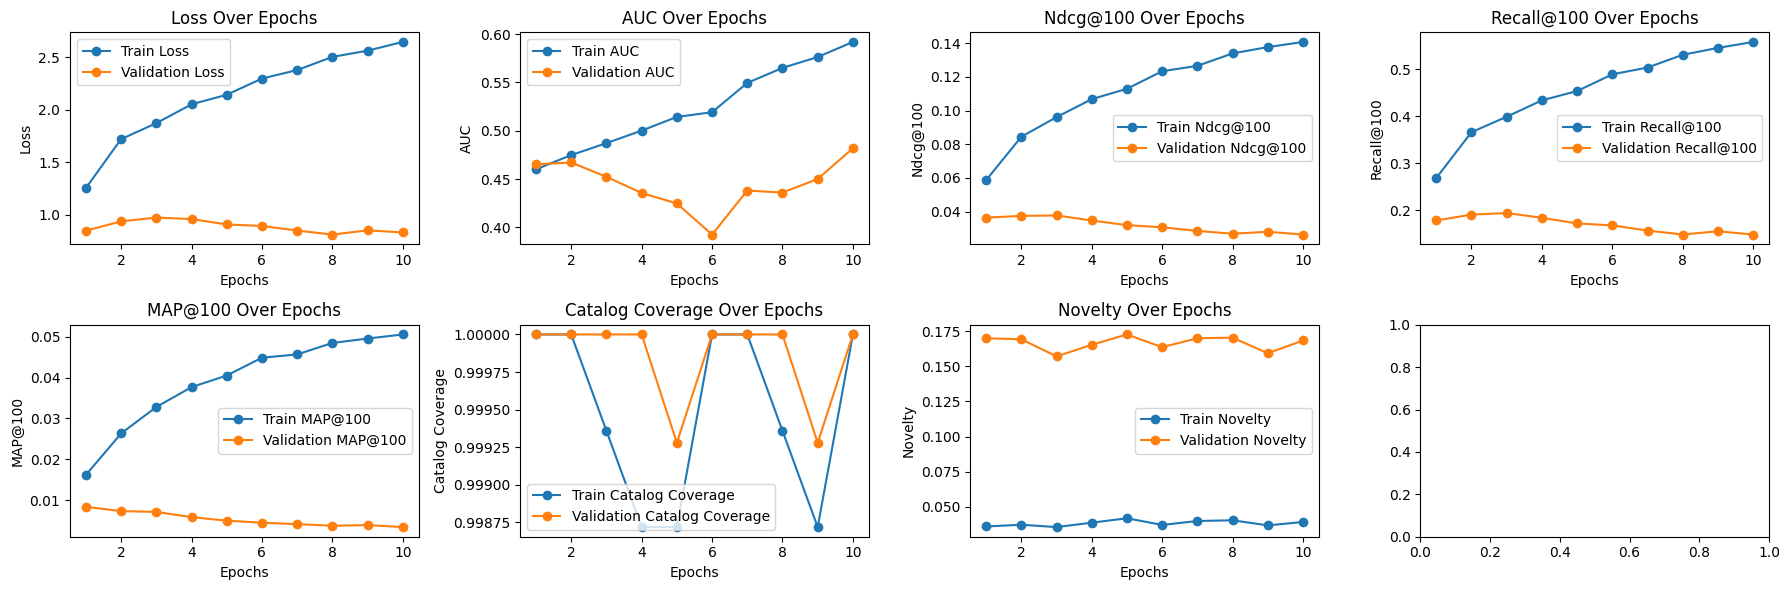

In [ ]:
_history = train_evaluation_clbk.get_records()
_history_val = valid_evaluation_clbk.get_records()
AUC_TERM = [k for k in _history if k.startswith('auc')][0]
_metrics  = {
    'Loss': 'loss',
    'AUC': AUC_TERM,
    'Ndcg@100': 'ndcg_at_100',
    'Recall@100': 'recall_at_100',
    'MAP@100':'map_at_100',
    'Catalog Coverage': 'coverage',
    'Novelty':'novelty'
}
print('Plot for model', VERSION)
plot_metrics(_history, _history_val, _metrics)


Plot for model v10


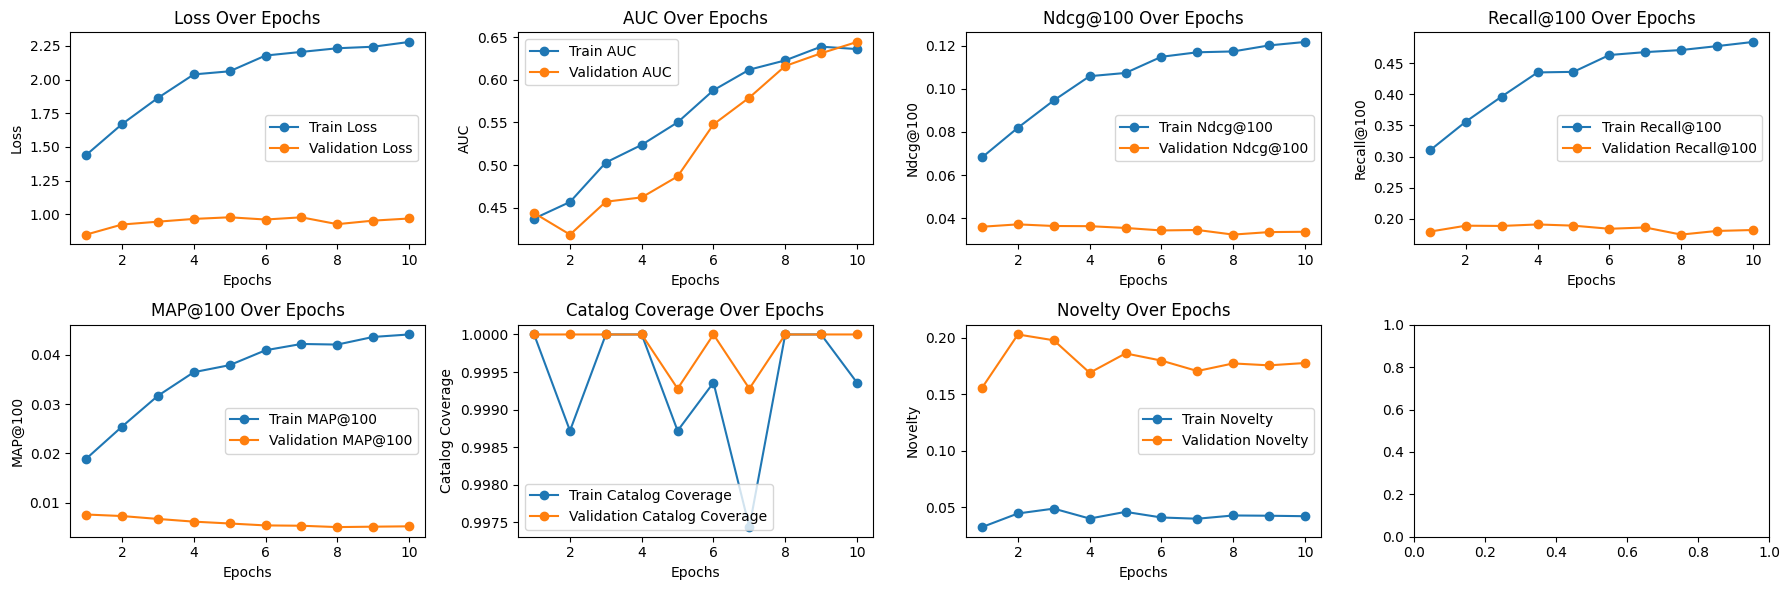

In [ ]:
_history = train_evaluation_clbk.get_records()
_history_val = valid_evaluation_clbk.get_records()
AUC_TERM = [k for k in _history if k.startswith('auc')][0]
_metrics  = {
    'Loss': 'loss',
    'AUC': AUC_TERM,
    'Ndcg@100': 'ndcg_at_100',
    'Recall@100': 'recall_at_100',
    'MAP@100':'map_at_100',
    'Catalog Coverage': 'coverage',
    'Novelty':'novelty'
}
print('Plot for model', VERSION)
plot_metrics(_history, _history_val, _metrics)


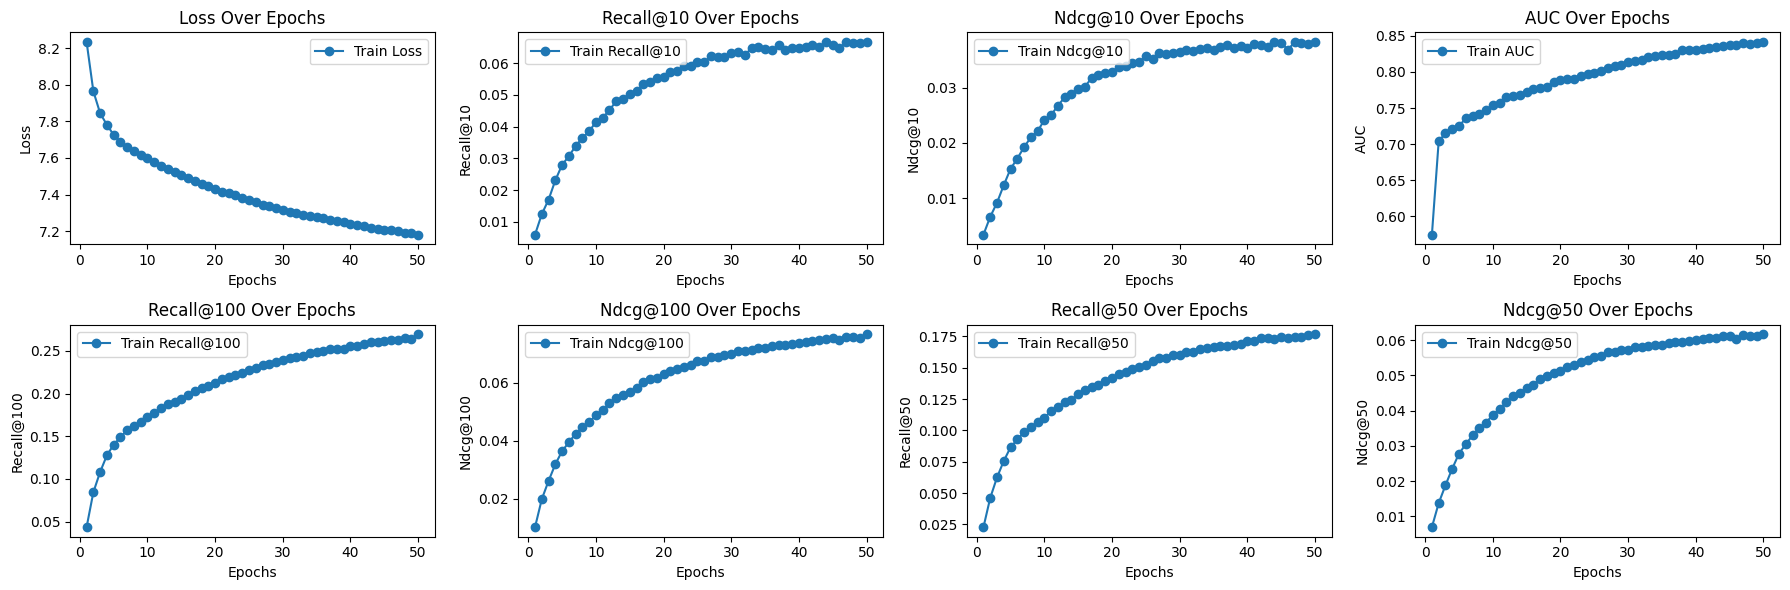

In [ ]:
_history = merge_model_history(*history)
# AUC_TERM = [k for k in _history if k.startswith('auc')][0]
METRIC_AT = {'@'.join([k.split('_')[0].title(), k.split('_')[-1]]):k for k in _history if k.startswith('recall') or k.startswith('ndcg')}
val_history = { k[4:]:v for k,v in _history.items() if k.startswith('val')}
plot_metrics(_history, None, default_plot_metrics | {'AUC': 'auc', **METRIC_AT,})
# {'AUC': AUC_TERM, 'Recall@100': 'recall_at_100','NDCG@10': 'ndcg_at_10',}

### model_v4

In [ ]:
VERSION = 'v4'

_tower_dim = [256, 256] # @param

_learning_rate = 0.01 # @param
_batch_size = 1024 * 2 # @param
_epochs = 50 # @param
_validation_batch_size = 2048 # @param
_sample_neg = _batch_size * 2 # @param
_validation_freq = 5 # @param
_loss = 'categorical_crossentropy' # @param
# _loss = 'bpr-max' # @param

_logq_sampling_correction = False # @param

embedding_dims = {
    'item': {
        'movie_id': 64,
        'genres': 8*2
    },
    'user': {
        'user_id': 64,
        'gender': 8,
        'occupation': 8*2
    }
}

In [ ]:
if VERSION in models:
    raise RuntimeError('Reusing model version: ', VERSION)

In [ ]:
from merlin.models.tf.outputs.sampling.in_batch import InBatchSamplerV2

sampler = [InBatchSamplerV2(_sample_neg)]

models[VERSION] = model = build_towers(
    train,
    tower_dim=_tower_dim,
    neg_sampler=sampler,
    embedding_dims=embedding_dims,
    logq_sampling_correction=_logq_sampling_correction,
    item_categorical=Tags.CATEGORICAL
)

train_evaluation_clbks[VERSION] = EvaluationCallback(period=5, topk=100, data=train, type_='Train', schema=train.schema)
valid_evaluation_clbks[VERSION] = EvaluationCallback(period=5, topk=100, data=valid, type_='Validation', schema=train.schema)
historys[VERSION] = []

TOP_K = [100, 50, 10]
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
    run_eagerly=False,
    metrics=topk_metrics_aggregator(TOP_K),
    loss=_loss,
)

#### model

In [ ]:
history = historys[VERSION]
model = models[VERSION]
train_evaluation_clbk = train_evaluation_clbks[VERSION]
valid_evaluation_clbk = valid_evaluation_clbks[VERSION]

In [ ]:
# %pdb on
history.append(
    model.fit(train, validation_data=valid, batch_size=_batch_size, epochs=_epochs,
                 validation_batch_size=_validation_batch_size, validation_freq=_validation_freq,
                 callbacks=[train_evaluation_clbk,
                            valid_evaluation_clbk],
                  verbose=1)
)

Epoch 1/50
35/35 [==============================] - 20s 241ms/step - loss: 7.4924 - auc: 0.6086 - recall_at_100: 0.0722 - mrr_at_100: 0.0051 - ndcg_at_100: 0.0163 - map_at_100: 0.0051 - precision_at_100: 7.2176e-04 - recall_at_50: 0.0372 - mrr_at_50: 0.0046 - ndcg_at_50: 0.0107 - map_at_50: 0.0046 - precision_at_50: 7.4355e-04 - recall_at_10: 0.0086 - mrr_at_10: 0.0035 - ndcg_at_10: 0.0046 - map_at_10: 0.0035 - precision_at_10: 8.5606e-04 - regularization_loss: 0.0000e+00 - loss_batch: 7.4232
Epoch 2/50
35/35 [==============================] - 6s 166ms/step - loss: 7.2058 - auc: 0.7082 - recall_at_100: 0.1636 - mrr_at_100: 0.0127 - ndcg_at_100: 0.0383 - map_at_100: 0.0127 - precision_at_100: 0.0016 - recall_at_50: 0.0944 - mrr_at_50: 0.0117 - ndcg_at_50: 0.0272 - map_at_50: 0.0117 - precision_at_50: 0.0019 - recall_at_10: 0.0236 - mrr_at_10: 0.0089 - ndcg_at_10: 0.0122 - map_at_10: 0.0089 - precision_at_10: 0.0024 - regularization_loss: 0.0000e+00 - loss_batch: 7.1395
Epoch 3/50
35/35 

69/69 [==============================] - 4s 17ms/step - loss: 1.3677 - auc: 0.4554 - recall_at_100: 0.2912 - mrr_at_100: 0.0176 - ndcg_at_100: 0.0638 - map_at_100: 0.0176 - precision_at_100: 0.0029 - recall_at_10: 0.0347 - mrr_at_10: 0.0107 - ndcg_at_10: 0.0162 - map_at_10: 0.0107 - precision_at_10: 0.0035 - regularization_loss: 0.0000e+00 - loss_batch: 1.3750
Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.3676549196243286, 'auc': 0.4553963243961334, 'recall_at_100': 0.2933962047100067, 'mrr_at_100': 0.0176954735070467, 'ndcg_at_100': 0.06425714492797852, 'map_at_100': 0.0176954735070467, 'precision_at_100': 0.002933961572125554, 'recall_at_10': 0.03581094741821289, 'mrr_at_10': 0.01078240480273962, 'ndcg_at_10': 0.016510674729943275, 'map_at_10': 0.01078240480273962, 'precision_at_10': 0.003581094555556774, 'regularization_loss': 0.0, 'loss_batch': 1.7238532304763794, 'coverage': 1.0, 'novelty': 0.04153453136011275}
Candidate set rows: 1387


15/15 [==============================] - 4s 21ms/step - loss: 0.8872 - auc: 0.4613 - recall_at_100: 0.1826 - mrr_at_100: 0.0074 - ndcg_at_100: 0.0363 - map_at_100: 0.0074 - precision_at_100: 0.0018 - recall_at_10: 0.0138 - mrr_at_10: 0.0033 - ndcg_at_10: 0.0056 - map_at_10: 0.0033 - precision_at_10: 0.0014 - regularization_loss: 0.0000e+00 - loss_batch: 0.9488
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.8871564269065857, 'auc': 0.4612625539302826, 'recall_at_100': 0.18617092072963715, 'mrr_at_100': 0.00814694631844759, 'ndcg_at_100': 0.03749559447169304, 'map_at_100': 0.00814694631844759, 'precision_at_100': 0.0018617092864587903, 'recall_at_10': 0.01444429624825716, 'mrr_at_10': 0.0038603036664426327, 'ndcg_at_10': 0.006259877700358629, 'map_at_10': 0.0038603036664426327, 'precision_at_10': 0.0014444297412410378, 'regularization_loss': 0.0, 'loss_batch': 1.593597173690796, 'coverage': 1.0, 'novelty': 0.18349873516248297}
35/35 [==============================]

69/69 [==============================] - 4s 17ms/step - loss: 1.6611 - auc: 0.4634 - recall_at_100: 0.3530 - mrr_at_100: 0.0241 - ndcg_at_100: 0.0801 - map_at_100: 0.0241 - precision_at_100: 0.0035 - recall_at_10: 0.0490 - mrr_at_10: 0.0156 - ndcg_at_10: 0.0232 - map_at_10: 0.0156 - precision_at_10: 0.0049 - regularization_loss: 0.0000e+00 - loss_batch: 1.6708
Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.6611015796661377, 'auc': 0.4634109139442444, 'recall_at_100': 0.3522549271583557, 'mrr_at_100': 0.02415752038359642, 'ndcg_at_100': 0.08012908697128296, 'map_at_100': 0.02415752038359642, 'precision_at_100': 0.0035225492902100086, 'recall_at_10': 0.050027064979076385, 'mrr_at_10': 0.015753095969557762, 'ndcg_at_10': 0.023596877232193947, 'map_at_10': 0.015753095969557762, 'precision_at_10': 0.005002705845981836, 'regularization_loss': 0.0, 'loss_batch': 2.1319491863250732, 'coverage': 1.0, 'novelty': 0.0441438067596667}
Candidate set rows: 1387


15/15 [==============================] - 4s 29ms/step - loss: 0.9275 - auc: 0.4430 - recall_at_100: 0.1862 - mrr_at_100: 0.0075 - ndcg_at_100: 0.0369 - map_at_100: 0.0075 - precision_at_100: 0.0019 - recall_at_10: 0.0122 - mrr_at_10: 0.0031 - ndcg_at_10: 0.0052 - map_at_10: 0.0031 - precision_at_10: 0.0012 - regularization_loss: 0.0000e+00 - loss_batch: 0.9823
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9275317788124084, 'auc': 0.4430190622806549, 'recall_at_100': 0.18897953629493713, 'mrr_at_100': 0.00755222188308835, 'ndcg_at_100': 0.03735506907105446, 'map_at_100': 0.00755222188308835, 'precision_at_100': 0.0018897952977567911, 'recall_at_10': 0.012170656584203243, 'mrr_at_10': 0.003163086250424385, 'ndcg_at_10': 0.005217577330768108, 'map_at_10': 0.003163086250424385, 'precision_at_10': 0.0012170658446848392, 'regularization_loss': 0.0, 'loss_batch': 1.5548113584518433, 'coverage': 1.0, 'novelty': 0.19560257208048124}
35/35 [==============================]

69/69 [==============================] - 5s 19ms/step - loss: 1.7591 - auc: 0.4638 - recall_at_100: 0.3701 - mrr_at_100: 0.0285 - ndcg_at_100: 0.0873 - map_at_100: 0.0285 - precision_at_100: 0.0037 - recall_at_10: 0.0593 - mrr_at_10: 0.0196 - ndcg_at_10: 0.0287 - map_at_10: 0.0196 - precision_at_10: 0.0059 - regularization_loss: 0.0000e+00 - loss_batch: 1.7712
Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.7590522766113281, 'auc': 0.46383172273635864, 'recall_at_100': 0.37305206060409546, 'mrr_at_100': 0.02901538833975792, 'ndcg_at_100': 0.08827412128448486, 'map_at_100': 0.02901538833975792, 'precision_at_100': 0.003730520373210311, 'recall_at_10': 0.06085296720266342, 'mrr_at_10': 0.02011130563914776, 'ndcg_at_10': 0.029467705637216568, 'map_at_10': 0.02011130563914776, 'precision_at_10': 0.006085297092795372, 'regularization_loss': 0.0, 'loss_batch': 2.3481497764587402, 'coverage': 0.9987187700192185, 'novelty': 0.04366953783458368}
Candidate set rows: 1387


15/15 [==============================] - 3s 21ms/step - loss: 0.9826 - auc: 0.4157 - recall_at_100: 0.1904 - mrr_at_100: 0.0065 - ndcg_at_100: 0.0364 - map_at_100: 0.0065 - precision_at_100: 0.0019 - recall_at_10: 0.0100 - mrr_at_10: 0.0022 - ndcg_at_10: 0.0040 - map_at_10: 0.0022 - precision_at_10: 0.0010 - regularization_loss: 0.0000e+00 - loss_batch: 1.0502
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9826272130012512, 'auc': 0.41569411754608154, 'recall_at_100': 0.19566671550273895, 'mrr_at_100': 0.006936739664524794, 'ndcg_at_100': 0.037784263491630554, 'map_at_100': 0.006936739664524794, 'precision_at_100': 0.0019566668197512627, 'recall_at_10': 0.011769426055252552, 'mrr_at_10': 0.0025342267472296953, 'ndcg_at_10': 0.0046195643953979015, 'map_at_10': 0.0025342267472296953, 'precision_at_10': 0.001176942721940577, 'regularization_loss': 0.0, 'loss_batch': 1.7563798427581787, 'coverage': 1.0, 'novelty': 0.18769904458598727}
35/35 [=========================

69/69 [==============================] - 6s 28ms/step - loss: 1.9550 - auc: 0.4877 - recall_at_100: 0.4157 - mrr_at_100: 0.0330 - ndcg_at_100: 0.0993 - map_at_100: 0.0330 - precision_at_100: 0.0042 - recall_at_10: 0.0704 - mrr_at_10: 0.0230 - ndcg_at_10: 0.0339 - map_at_10: 0.0230 - precision_at_10: 0.0070 - regularization_loss: 0.0000e+00 - loss_batch: 1.9671
Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.9550291299819946, 'auc': 0.4876561760902405, 'recall_at_100': 0.4167402684688568, 'mrr_at_100': 0.03451818972826004, 'ndcg_at_100': 0.10077494382858276, 'map_at_100': 0.03451818972826004, 'precision_at_100': 0.004167403094470501, 'recall_at_10': 0.07378707081079483, 'mrr_at_10': 0.024546455591917038, 'ndcg_at_10': 0.0358639732003212, 'map_at_10': 0.024546455591917038, 'precision_at_10': 0.007378708105534315, 'regularization_loss': 0.0, 'loss_batch': 2.5382955074310303, 'coverage': 0.9980781550288277, 'novelty': 0.038987886054492084}
Candidate set rows: 1387


15/15 [==============================] - 3s 20ms/step - loss: 0.9753 - auc: 0.4103 - recall_at_100: 0.1923 - mrr_at_100: 0.0063 - ndcg_at_100: 0.0366 - map_at_100: 0.0063 - precision_at_100: 0.0019 - recall_at_10: 0.0106 - mrr_at_10: 0.0021 - ndcg_at_10: 0.0040 - map_at_10: 0.0021 - precision_at_10: 0.0011 - regularization_loss: 0.0000e+00 - loss_batch: 1.0198
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9752843379974365, 'auc': 0.4103192090988159, 'recall_at_100': 0.19386117160320282, 'mrr_at_100': 0.006699411664158106, 'ndcg_at_100': 0.03722688928246498, 'map_at_100': 0.006699411664158106, 'precision_at_100': 0.0019386117346584797, 'recall_at_10': 0.01096696499735117, 'mrr_at_10': 0.002371319802477956, 'ndcg_at_10': 0.0043044136837124825, 'map_at_10': 0.002371319802477956, 'precision_at_10': 0.0010966965928673744, 'regularization_loss': 0.0, 'loss_batch': 1.4856270551681519, 'coverage': 1.0, 'novelty': 0.16872427983539096}
35/35 [=============================

69/69 [==============================] - 6s 29ms/step - loss: 2.0792 - auc: 0.4974 - recall_at_100: 0.4418 - mrr_at_100: 0.0383 - ndcg_at_100: 0.1086 - map_at_100: 0.0383 - precision_at_100: 0.0044 - recall_at_10: 0.0808 - mrr_at_10: 0.0275 - ndcg_at_10: 0.0398 - map_at_10: 0.0275 - precision_at_10: 0.0081 - regularization_loss: 0.0000e+00 - loss_batch: 2.0912
Candidate set rows: 943
Train dataset topk evaluation {'loss': 2.079153060913086, 'auc': 0.49741068482398987, 'recall_at_100': 0.44202443957328796, 'mrr_at_100': 0.037583932280540466, 'ndcg_at_100': 0.10794942080974579, 'map_at_100': 0.037583932280540466, 'precision_at_100': 0.004420244600623846, 'recall_at_10': 0.08018290251493454, 'mrr_at_10': 0.02686857059597969, 'ndcg_at_10': 0.03913005813956261, 'map_at_10': 0.02686857059597969, 'precision_at_10': 0.008018290624022484, 'regularization_loss': 0.0, 'loss_batch': 2.6626453399658203, 'coverage': 1.0, 'novelty': 0.03976721629485936}
Candidate set rows: 1387


15/15 [==============================] - 3s 21ms/step - loss: 0.9424 - auc: 0.3980 - recall_at_100: 0.1785 - mrr_at_100: 0.0056 - ndcg_at_100: 0.0337 - map_at_100: 0.0056 - precision_at_100: 0.0018 - recall_at_10: 0.0083 - mrr_at_10: 0.0017 - ndcg_at_10: 0.0032 - map_at_10: 0.0017 - precision_at_10: 8.2992e-04 - regularization_loss: 0.0000e+00 - loss_batch: 0.9901
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.942435622215271, 'auc': 0.3980265259742737, 'recall_at_100': 0.1838304102420807, 'mrr_at_100': 0.0059676035307347775, 'ndcg_at_100': 0.034816838800907135, 'map_at_100': 0.0059676035307347775, 'precision_at_100': 0.0018383041024208069, 'recall_at_10': 0.008693326264619827, 'mrr_at_10': 0.0018663321388885379, 'ndcg_at_10': 0.0033956938423216343, 'map_at_10': 0.0018663321388885379, 'precision_at_10': 0.0008693326381035149, 'regularization_loss': 0.0, 'loss_batch': 1.4879965782165527, 'coverage': 1.0, 'novelty': 0.17563792140063325}
35/35 [=====================

69/69 [==============================] - 6s 29ms/step - loss: 2.0816 - auc: 0.5166 - recall_at_100: 0.4415 - mrr_at_100: 0.0366 - ndcg_at_100: 0.1071 - map_at_100: 0.0366 - precision_at_100: 0.0044 - recall_at_10: 0.0798 - mrr_at_10: 0.0260 - ndcg_at_10: 0.0383 - map_at_10: 0.0260 - precision_at_10: 0.0080 - regularization_loss: 0.0000e+00 - loss_batch: 2.0948
Candidate set rows: 943
Train dataset topk evaluation {'loss': 2.0816452503204346, 'auc': 0.5166303515434265, 'recall_at_100': 0.44155436754226685, 'mrr_at_100': 0.03793654218316078, 'ndcg_at_100': 0.10829094052314758, 'map_at_100': 0.03793654218316078, 'precision_at_100': 0.0044155428186059, 'recall_at_10': 0.08186376094818115, 'mrr_at_10': 0.027268344536423683, 'ndcg_at_10': 0.03982318192720413, 'map_at_10': 0.027268344536423683, 'precision_at_10': 0.008186375722289085, 'regularization_loss': 0.0, 'loss_batch': 2.7173168659210205, 'coverage': 0.9974375400384369, 'novelty': 0.043661450134271695}
Candidate set rows: 1387


15/15 [==============================] - 3s 23ms/step - loss: 0.9391 - auc: 0.3989 - recall_at_100: 0.1787 - mrr_at_100: 0.0055 - ndcg_at_100: 0.0334 - map_at_100: 0.0055 - precision_at_100: 0.0018 - recall_at_10: 0.0070 - mrr_at_10: 0.0015 - ndcg_at_10: 0.0028 - map_at_10: 0.0015 - precision_at_10: 7.0310e-04 - regularization_loss: 0.0000e+00 - loss_batch: 0.9853
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.939082145690918, 'auc': 0.3989476263523102, 'recall_at_100': 0.1816236525774002, 'mrr_at_100': 0.0058564986102283, 'ndcg_at_100': 0.03428959473967552, 'map_at_100': 0.0058564986102283, 'precision_at_100': 0.0018162362975999713, 'recall_at_10': 0.007890865206718445, 'mrr_at_10': 0.0017941792029887438, 'ndcg_at_10': 0.003161040600389242, 'map_at_10': 0.0017941792029887438, 'precision_at_10': 0.0007890865672379732, 'regularization_loss': 0.0, 'loss_batch': 1.4680747985839844, 'coverage': 1.0, 'novelty': 0.16939105442787855}
35/35 [=============================

69/69 [==============================] - 6s 19ms/step - loss: 2.2050 - auc: 0.5613 - recall_at_100: 0.4700 - mrr_at_100: 0.0416 - ndcg_at_100: 0.1167 - map_at_100: 0.0416 - precision_at_100: 0.0047 - recall_at_10: 0.0932 - mrr_at_10: 0.0304 - ndcg_at_10: 0.0448 - map_at_10: 0.0304 - precision_at_10: 0.0093 - regularization_loss: 0.0000e+00 - loss_batch: 2.2182
Candidate set rows: 943
Train dataset topk evaluation {'loss': 2.2049834728240967, 'auc': 0.5613293051719666, 'recall_at_100': 0.46908921003341675, 'mrr_at_100': 0.04116208478808403, 'ndcg_at_100': 0.11609363555908203, 'map_at_100': 0.04116208478808403, 'precision_at_100': 0.004690892528742552, 'recall_at_10': 0.09122247248888016, 'mrr_at_10': 0.029793137684464455, 'ndcg_at_10': 0.04390890151262283, 'map_at_10': 0.029793137684464455, 'precision_at_10': 0.009122245945036411, 'regularization_loss': 0.0, 'loss_batch': 2.8472602367401123, 'coverage': 0.9993593850096092, 'novelty': 0.03963017440638789}
Candidate set rows: 1387


15/15 [==============================] - 3s 21ms/step - loss: 0.9573 - auc: 0.4561 - recall_at_100: 0.1803 - mrr_at_100: 0.0055 - ndcg_at_100: 0.0339 - map_at_100: 0.0055 - precision_at_100: 0.0018 - recall_at_10: 0.0064 - mrr_at_10: 0.0012 - ndcg_at_10: 0.0024 - map_at_10: 0.0012 - precision_at_10: 6.3566e-04 - regularization_loss: 0.0000e+00 - loss_batch: 0.9938
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9572553634643555, 'auc': 0.4560559391975403, 'recall_at_100': 0.18543533980846405, 'mrr_at_100': 0.005605172365903854, 'ndcg_at_100': 0.03476296365261078, 'map_at_100': 0.005605172365903854, 'precision_at_100': 0.00185435323510319, 'recall_at_10': 0.006820917595177889, 'mrr_at_10': 0.0013371430104598403, 'ndcg_at_10': 0.002570746699348092, 'map_at_10': 0.0013371430104598403, 'precision_at_10': 0.0006820917478762567, 'regularization_loss': 0.0, 'loss_batch': 1.3760201930999756, 'coverage': 1.0, 'novelty': 0.17111232081291963}
35/35 [=========================

69/69 [==============================] - 6s 28ms/step - loss: 2.1764 - auc: 0.5754 - recall_at_100: 0.4610 - mrr_at_100: 0.0403 - ndcg_at_100: 0.1139 - map_at_100: 0.0403 - precision_at_100: 0.0046 - recall_at_10: 0.0880 - mrr_at_10: 0.0290 - ndcg_at_10: 0.0426 - map_at_10: 0.0290 - precision_at_10: 0.0088 - regularization_loss: 0.0000e+00 - loss_batch: 2.1880
Candidate set rows: 943
Train dataset topk evaluation {'loss': 2.1763648986816406, 'auc': 0.5753764510154724, 'recall_at_100': 0.4603002667427063, 'mrr_at_100': 0.04098603129386902, 'ndcg_at_100': 0.11447577178478241, 'map_at_100': 0.04098603129386902, 'precision_at_100': 0.004603002220392227, 'recall_at_10': 0.08924247324466705, 'mrr_at_10': 0.029731644317507744, 'ndcg_at_10': 0.043431688100099564, 'map_at_10': 0.029731644317507744, 'precision_at_10': 0.008924245834350586, 'regularization_loss': 0.0, 'loss_batch': 2.7429449558258057, 'coverage': 1.0, 'novelty': 0.04257336343115124}
Candidate set rows: 1387


15/15 [==============================] - 3s 21ms/step - loss: 0.9487 - auc: 0.4663 - recall_at_100: 0.1738 - mrr_at_100: 0.0051 - ndcg_at_100: 0.0324 - map_at_100: 0.0051 - precision_at_100: 0.0017 - recall_at_10: 0.0057 - mrr_at_10: 0.0011 - ndcg_at_10: 0.0021 - map_at_10: 0.0011 - precision_at_10: 5.6992e-04 - regularization_loss: 0.0000e+00 - loss_batch: 0.9969
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9486907720565796, 'auc': 0.46633920073509216, 'recall_at_100': 0.1809549331665039, 'mrr_at_100': 0.005418083630502224, 'ndcg_at_100': 0.033841460943222046, 'map_at_100': 0.005418083630502224, 'precision_at_100': 0.0018095492850989103, 'recall_at_10': 0.0063528153114020824, 'mrr_at_10': 0.0012800365220755339, 'ndcg_at_10': 0.002430396154522896, 'map_at_10': 0.0012800365220755339, 'precision_at_10': 0.0006352816126309335, 'regularization_loss': 0.0, 'loss_batch': 1.501013159751892, 'coverage': 1.0, 'novelty': 0.17385693215339232}
35/35 [======================

69/69 [==============================] - 7s 30ms/step - loss: 2.2035 - auc: 0.5958 - recall_at_100: 0.4645 - mrr_at_100: 0.0413 - ndcg_at_100: 0.1156 - map_at_100: 0.0413 - precision_at_100: 0.0046 - recall_at_10: 0.0910 - mrr_at_10: 0.0299 - ndcg_at_10: 0.0439 - map_at_10: 0.0299 - precision_at_10: 0.0091 - regularization_loss: 0.0000e+00 - loss_batch: 2.2182
Candidate set rows: 943
Train dataset topk evaluation {'loss': 2.2034995555877686, 'auc': 0.5958341956138611, 'recall_at_100': 0.4659268856048584, 'mrr_at_100': 0.041949424892663956, 'ndcg_at_100': 0.11638291925191879, 'map_at_100': 0.041949424892663956, 'precision_at_100': 0.004659268073737621, 'recall_at_10': 0.09226232767105103, 'mrr_at_10': 0.03057386726140976, 'ndcg_at_10': 0.04476592317223549, 'map_at_10': 0.03057386726140976, 'precision_at_10': 0.009226230904459953, 'regularization_loss': 0.0, 'loss_batch': 2.914879322052002, 'coverage': 1.0, 'novelty': 0.04079601990049751}
Candidate set rows: 1387


15/15 [==============================] - 3s 24ms/step - loss: 0.9576 - auc: 0.4860 - recall_at_100: 0.1778 - mrr_at_100: 0.0049 - ndcg_at_100: 0.0328 - map_at_100: 0.0049 - precision_at_100: 0.0018 - recall_at_10: 0.0054 - mrr_at_10: 9.1598e-04 - ndcg_at_10: 0.0019 - map_at_10: 9.1598e-04 - precision_at_10: 5.4290e-04 - regularization_loss: 0.0000e+00 - loss_batch: 1.0040
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9575546383857727, 'auc': 0.4860232472419739, 'recall_at_100': 0.18055370450019836, 'mrr_at_100': 0.005302526988089085, 'ndcg_at_100': 0.033607423305511475, 'map_at_100': 0.005302526988089085, 'precision_at_100': 0.0018055371474474669, 'recall_at_10': 0.006285943556576967, 'mrr_at_10': 0.0012504750629886985, 'ndcg_at_10': 0.0023812365252524614, 'map_at_10': 0.0012504750629886985, 'precision_at_10': 0.000628594309091568, 'regularization_loss': 0.0, 'loss_batch': 1.4894225597381592, 'coverage': 1.0, 'novelty': 0.170647846543612}
35/35 [================

69/69 [==============================] - 5s 28ms/step - loss: 2.2881 - auc: 0.6101 - recall_at_100: 0.4876 - mrr_at_100: 0.0435 - ndcg_at_100: 0.1217 - map_at_100: 0.0435 - precision_at_100: 0.0049 - recall_at_10: 0.0995 - mrr_at_10: 0.0315 - ndcg_at_10: 0.0471 - map_at_10: 0.0315 - precision_at_10: 0.0099 - regularization_loss: 0.0000e+00 - loss_batch: 2.2997
Candidate set rows: 943
Train dataset topk evaluation {'loss': 2.2881202697753906, 'auc': 0.6100656986236572, 'recall_at_100': 0.48680949211120605, 'mrr_at_100': 0.044006191194057465, 'ndcg_at_100': 0.12199301272630692, 'map_at_100': 0.044006191194057465, 'precision_at_100': 0.00486809341236949, 'recall_at_10': 0.09918520599603653, 'mrr_at_10': 0.032072000205516815, 'ndcg_at_10': 0.04748668521642685, 'map_at_10': 0.032072000205516815, 'precision_at_10': 0.009918520227074623, 'regularization_loss': 0.0, 'loss_batch': 2.8483188152313232, 'coverage': 0.9993593850096092, 'novelty': 0.0395222129086337}
Candidate set rows: 1387


15/15 [==============================] - 5s 21ms/step - loss: 1.0082 - auc: 0.5182 - recall_at_100: 0.1876 - mrr_at_100: 0.0050 - ndcg_at_100: 0.0343 - map_at_100: 0.0050 - precision_at_100: 0.0019 - recall_at_10: 0.0039 - mrr_at_10: 8.0990e-04 - ndcg_at_10: 0.0015 - map_at_10: 8.0990e-04 - precision_at_10: 3.9187e-04 - regularization_loss: 0.0000e+00 - loss_batch: 1.0514
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 1.0082162618637085, 'auc': 0.5182082056999207, 'recall_at_100': 0.19025009870529175, 'mrr_at_100': 0.0052005210891366005, 'ndcg_at_100': 0.03493901714682579, 'map_at_100': 0.0052005210891366005, 'precision_at_100': 0.0019025010988116264, 'recall_at_10': 0.005082252435386181, 'mrr_at_10': 0.000987207400612533, 'ndcg_at_10': 0.0019005598733201623, 'map_at_10': 0.000987207400612533, 'precision_at_10': 0.0005082252318970859, 'regularization_loss': 0.0, 'loss_batch': 1.5024738311767578, 'coverage': 1.0, 'novelty': 0.174274625762336}
35/35 [================

#### analysis

In [ ]:
history = historys[VERSION]
model = models[VERSION]
train_evaluation_clbk = train_evaluation_clbks[VERSION]
valid_evaluation_clbk = valid_evaluation_clbks[VERSION]

Plot for model v4


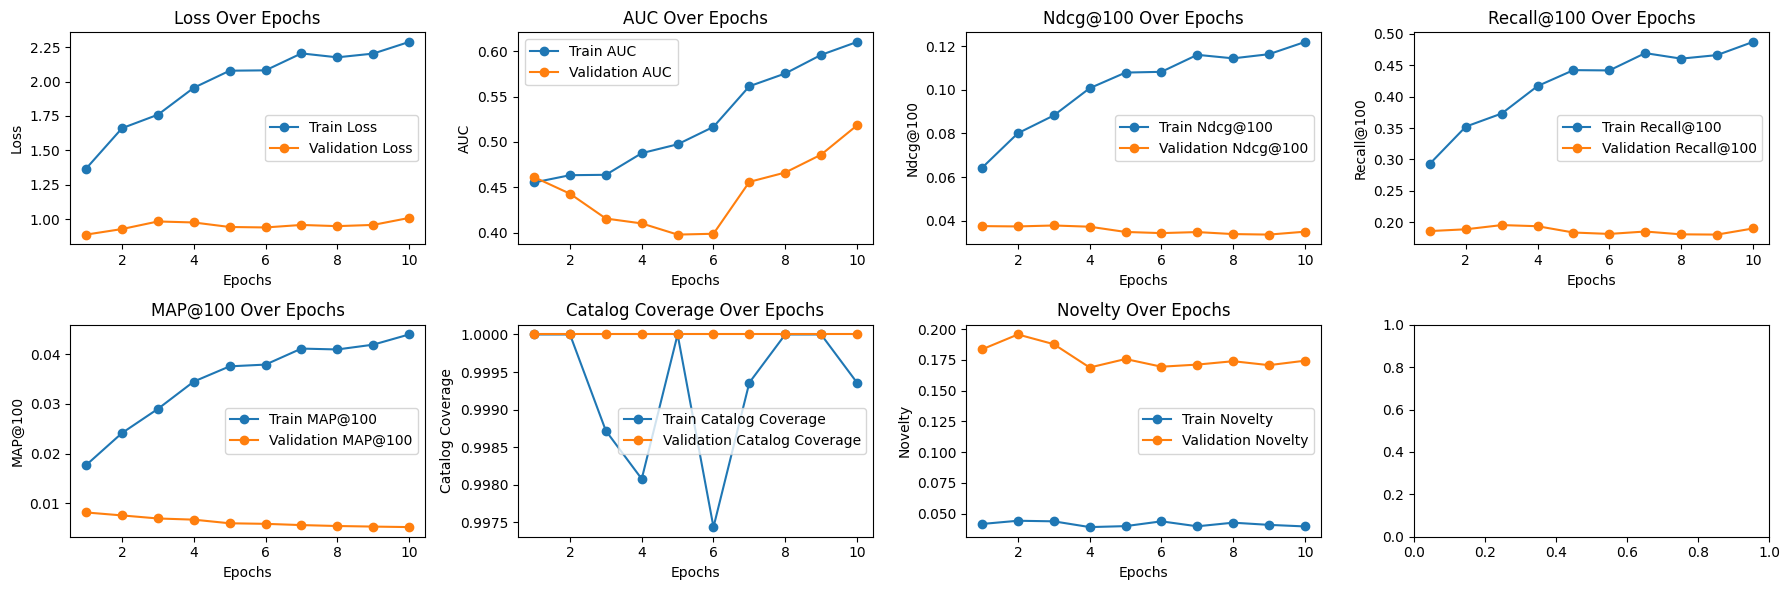

In [ ]:
_history = train_evaluation_clbk.get_records()
_history_val = valid_evaluation_clbk.get_records()
AUC_TERM = [k for k in _history if k.startswith('auc')][0]
_metrics  = {
    'Loss': 'loss',
    'AUC': AUC_TERM,
    'Ndcg@100': 'ndcg_at_100',
    'Recall@100': 'recall_at_100',
    'MAP@100':'map_at_100',
    'Catalog Coverage': 'coverage',
    'Novelty':'novelty'
}
print('Plot for model', VERSION)
plot_metrics(_history, _history_val, _metrics)


Plot for model v10


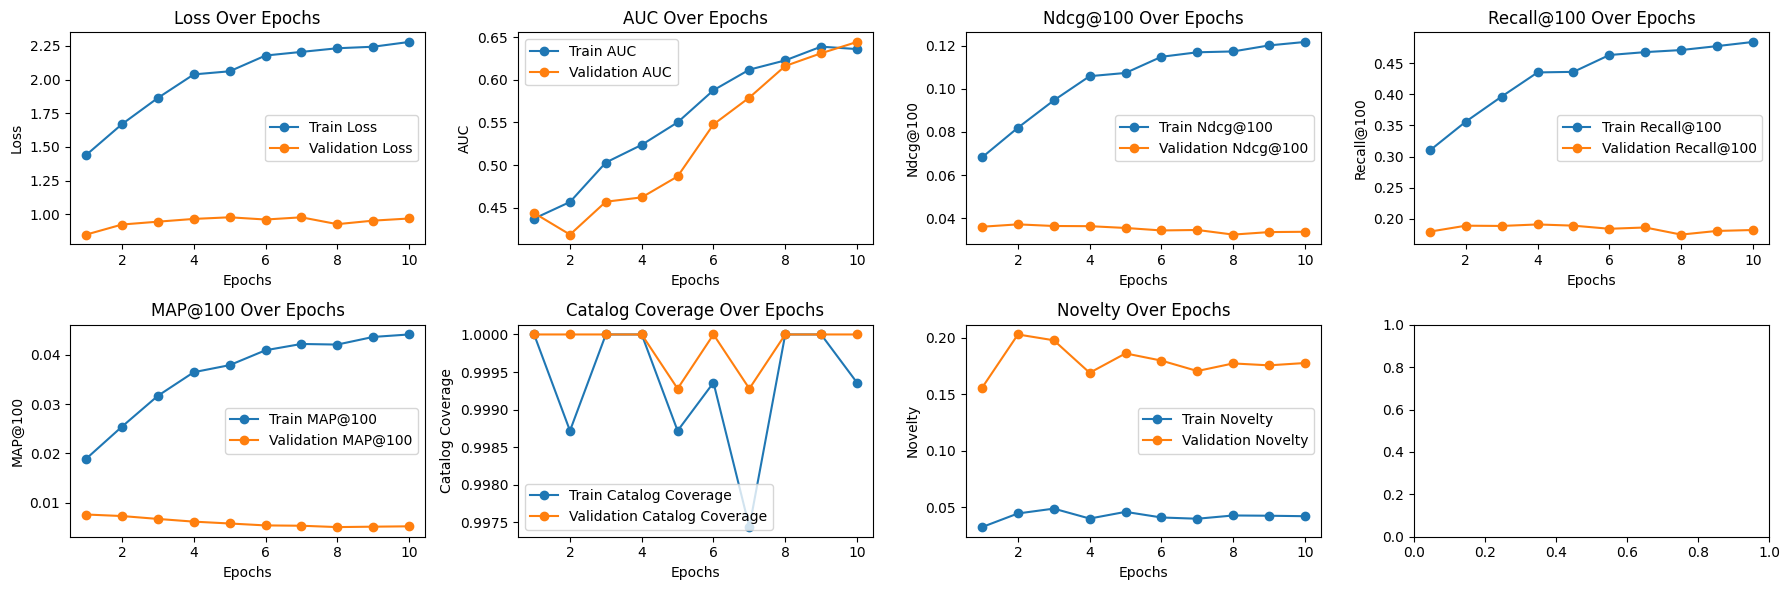

In [ ]:
_history = train_evaluation_clbk.get_records()
_history_val = valid_evaluation_clbk.get_records()
AUC_TERM = [k for k in _history if k.startswith('auc')][0]
_metrics  = {
    'Loss': 'loss',
    'AUC': AUC_TERM,
    'Ndcg@100': 'ndcg_at_100',
    'Recall@100': 'recall_at_100',
    'MAP@100':'map_at_100',
    'Catalog Coverage': 'coverage',
    'Novelty':'novelty'
}
print('Plot for model', VERSION)
plot_metrics(_history, _history_val, _metrics)


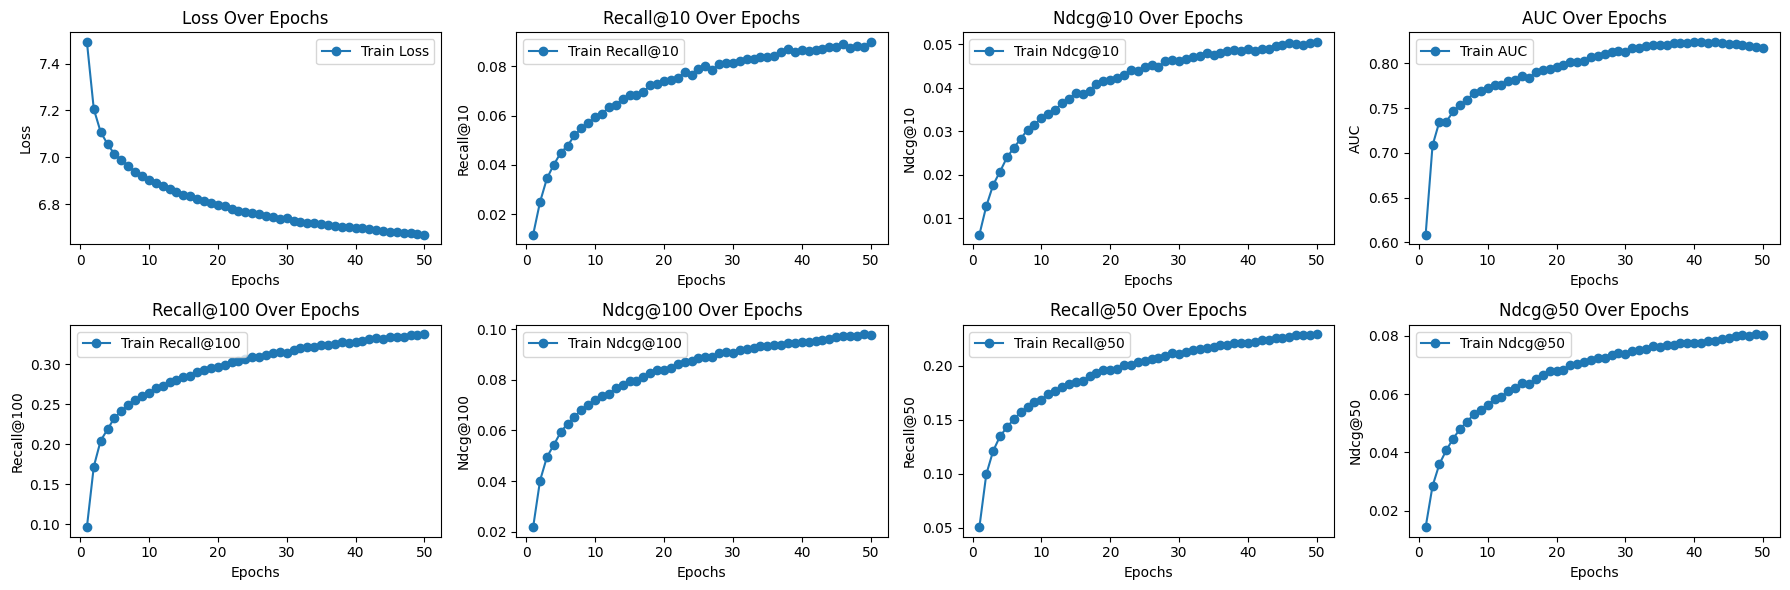

In [ ]:
_history = merge_model_history(*history)
# AUC_TERM = [k for k in _history if k.startswith('auc')][0]
METRIC_AT = {'@'.join([k.split('_')[0].title(), k.split('_')[-1]]):k for k in _history if k.startswith('recall') or k.startswith('ndcg')}
val_history = { k[4:]:v for k,v in _history.items() if k.startswith('val')}
plot_metrics(_history, None, default_plot_metrics | {'AUC': 'auc', **METRIC_AT,})
# {'AUC': AUC_TERM, 'Recall@100': 'recall_at_100','NDCG@10': 'ndcg_at_10',}

### model_v5

In [ ]:
VERSION = 'v5'

_tower_dim = [128, 128] # @param

_learning_rate = 0.01 # @param
_batch_size = 1024 * 2 # @param
_epochs = 50 # @param
_validation_batch_size = 2048 # @param
_sample_neg = _batch_size * 2 # @param
_validation_freq = 5 # @param
# _loss = 'categorical_crossentropy' # @param
_loss = 'bpr-max' # @param

_logq_sampling_correction = False # @param

embedding_dims = {
    'item': {
        'movie_id': 64,
        'genres': 8*2
    },
    'user': {
        'user_id': 64,
        'gender': 8,
        'occupation': 8*2
    }
}

In [ ]:
if VERSION in models:
    raise RuntimeError('Reusing model version: ', VERSION)

In [ ]:
from merlin.models.tf.outputs.sampling.in_batch import InBatchSamplerV2

sampler = [InBatchSamplerV2(_sample_neg)]

models[VERSION] = model = build_towers(
    train,
    tower_dim=_tower_dim,
    neg_sampler=sampler,
    embedding_dims=embedding_dims,
    logq_sampling_correction=_logq_sampling_correction,
    item_categorical=Tags.CATEGORICAL
)

train_evaluation_clbks[VERSION] = EvaluationCallback(period=5, topk=100, data=train, type_='Train', schema=train.schema)
valid_evaluation_clbks[VERSION] = EvaluationCallback(period=5, topk=100, data=valid, type_='Validation', schema=train.schema)
historys[VERSION] = []

TOP_K = [100, 50, 10]
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
    run_eagerly=False,
    metrics=topk_metrics_aggregator(TOP_K),
    loss=_loss,
)

#### model

In [ ]:
history = historys[VERSION]
model = models[VERSION]
train_evaluation_clbk = train_evaluation_clbks[VERSION]
valid_evaluation_clbk = valid_evaluation_clbks[VERSION]

In [ ]:
# %pdb on
history.append(
    model.fit(train, validation_data=valid, batch_size=_batch_size, epochs=_epochs,
                 validation_batch_size=_validation_batch_size, validation_freq=_validation_freq,
                 callbacks=[train_evaluation_clbk,
                            valid_evaluation_clbk],
                  verbose=1)
)

Epoch 1/50
35/35 [==============================] - 23s 297ms/step - loss: 8.4007 - auc: 0.6339 - recall_at_100: 0.0733 - mrr_at_100: 0.0052 - ndcg_at_100: 0.0165 - map_at_100: 0.0052 - precision_at_100: 7.3339e-04 - recall_at_50: 0.0384 - mrr_at_50: 0.0047 - ndcg_at_50: 0.0109 - map_at_50: 0.0047 - precision_at_50: 7.6762e-04 - recall_at_10: 0.0084 - mrr_at_10: 0.0035 - ndcg_at_10: 0.0046 - map_at_10: 0.0035 - precision_at_10: 8.4412e-04 - regularization_loss: 0.0000e+00 - loss_batch: 8.3409
Epoch 2/50
35/35 [==============================] - 5s 116ms/step - loss: 8.3610 - auc: 0.7445 - recall_at_100: 0.1754 - mrr_at_100: 0.0134 - ndcg_at_100: 0.0409 - map_at_100: 0.0134 - precision_at_100: 0.0018 - recall_at_50: 0.1003 - mrr_at_50: 0.0123 - ndcg_at_50: 0.0288 - map_at_50: 0.0123 - precision_at_50: 0.0020 - recall_at_10: 0.0255 - mrr_at_10: 0.0093 - ndcg_at_10: 0.0130 - map_at_10: 0.0093 - precision_at_10: 0.0026 - regularization_loss: 0.0000e+00 - loss_batch: 8.3020
Epoch 3/50
35/35 

69/69 [==============================] - 8s 29ms/step - loss: 1.3264 - auc: 0.5221 - recall_at_100: 0.2868 - mrr_at_100: 0.0179 - ndcg_at_100: 0.0633 - map_at_100: 0.0179 - precision_at_100: 0.0029 - recall_at_10: 0.0368 - mrr_at_10: 0.0113 - ndcg_at_10: 0.0171 - map_at_10: 0.0113 - precision_at_10: 0.0037 - regularization_loss: 0.0000e+00 - loss_batch: 1.3352
Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.3264058828353882, 'auc': 0.5220791101455688, 'recall_at_100': 0.2886669933795929, 'mrr_at_100': 0.018114501610398293, 'ndcg_at_100': 0.06385612487792969, 'map_at_100': 0.018114501610398293, 'precision_at_100': 0.0028866699431091547, 'recall_at_10': 0.03727814182639122, 'mrr_at_10': 0.011390984989702702, 'ndcg_at_10': 0.0173043143004179, 'map_at_10': 0.011390984989702702, 'precision_at_10': 0.0037278137169778347, 'regularization_loss': 0.0, 'loss_batch': 1.7540100812911987, 'coverage': 1.0, 'novelty': 0.03767629549722322}
Candidate set rows: 1387


15/15 [==============================] - 3s 22ms/step - loss: 0.8356 - auc: 0.5228 - recall_at_100: 0.1775 - mrr_at_100: 0.0079 - ndcg_at_100: 0.0358 - map_at_100: 0.0079 - precision_at_100: 0.0018 - recall_at_10: 0.0149 - mrr_at_10: 0.0040 - ndcg_at_10: 0.0065 - map_at_10: 0.0040 - precision_at_10: 0.0015 - regularization_loss: 0.0000e+00 - loss_batch: 0.9036
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.8355849981307983, 'auc': 0.5227566361427307, 'recall_at_100': 0.18068744242191315, 'mrr_at_100': 0.00839339941740036, 'ndcg_at_100': 0.03682909905910492, 'map_at_100': 0.00839339941740036, 'precision_at_100': 0.0018068744102492929, 'recall_at_10': 0.015514243394136429, 'mrr_at_10': 0.004338437225669622, 'ndcg_at_10': 0.006877336651086807, 'map_at_10': 0.004338437225669622, 'precision_at_10': 0.0015514245023950934, 'regularization_loss': 0.0, 'loss_batch': 1.6147170066833496, 'coverage': 0.9971160778658976, 'novelty': 0.16368685992015275}
35/35 [================

69/69 [==============================] - 6s 26ms/step - loss: 1.5820 - auc: 0.5454 - recall_at_100: 0.3431 - mrr_at_100: 0.0246 - ndcg_at_100: 0.0792 - map_at_100: 0.0246 - precision_at_100: 0.0034 - recall_at_10: 0.0507 - mrr_at_10: 0.0163 - ndcg_at_10: 0.0242 - map_at_10: 0.0163 - precision_at_10: 0.0051 - regularization_loss: 0.0000e+00 - loss_batch: 1.5980
Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.5819796323776245, 'auc': 0.5453653335571289, 'recall_at_100': 0.3458590805530548, 'mrr_at_100': 0.024741532281041145, 'ndcg_at_100': 0.07980793714523315, 'map_at_100': 0.024741532281041145, 'precision_at_100': 0.0034585902467370033, 'recall_at_10': 0.05234893411397934, 'mrr_at_10': 0.016464369371533394, 'ndcg_at_10': 0.0246900524944067, 'map_at_10': 0.016464369371533394, 'precision_at_10': 0.005234893877059221, 'regularization_loss': 0.0, 'loss_batch': 2.357438087463379, 'coverage': 1.0, 'novelty': 0.040553907022749754}
Candidate set rows: 1387


15/15 [==============================] - 3s 21ms/step - loss: 0.8531 - auc: 0.5113 - recall_at_100: 0.1762 - mrr_at_100: 0.0069 - ndcg_at_100: 0.0348 - map_at_100: 0.0069 - precision_at_100: 0.0018 - recall_at_10: 0.0123 - mrr_at_10: 0.0028 - ndcg_at_10: 0.0049 - map_at_10: 0.0028 - precision_at_10: 0.0012 - regularization_loss: 0.0000e+00 - loss_batch: 0.9184
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.8531426787376404, 'auc': 0.511329174041748, 'recall_at_100': 0.18396416306495667, 'mrr_at_100': 0.00756926229223609, 'ndcg_at_100': 0.0366818793118, 'map_at_100': 0.00756926229223609, 'precision_at_100': 0.0018396415980532765, 'recall_at_10': 0.01431055273860693, 'mrr_at_10': 0.003348257625475526, 'ndcg_at_10': 0.005840278696268797, 'map_at_10': 0.003348257625475526, 'precision_at_10': 0.0014310553669929504, 'regularization_loss': 0.0, 'loss_batch': 1.6005409955978394, 'coverage': 0.9985580389329488, 'novelty': 0.1783957623912221}
35/35 [=======================

69/69 [==============================] - 25s 17ms/step - loss: 1.6910 - auc: 0.5523 - recall_at_100: 0.3696 - mrr_at_100: 0.0295 - ndcg_at_100: 0.0882 - map_at_100: 0.0295 - precision_at_100: 0.0037 - recall_at_10: 0.0628 - mrr_at_10: 0.0207 - ndcg_at_10: 0.0304 - map_at_10: 0.0207 - precision_at_10: 0.0063 - regularization_loss: 0.0000e+00 - loss_batch: 1.7060
Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.6910250186920166, 'auc': 0.5522711873054504, 'recall_at_100': 0.3706589639186859, 'mrr_at_100': 0.02915828675031662, 'ndcg_at_100': 0.0880507305264473, 'map_at_100': 0.02915828675031662, 'precision_at_100': 0.0037065891083329916, 'recall_at_10': 0.061721887439489365, 'mrr_at_10': 0.02030448615550995, 'ndcg_at_10': 0.02982289530336857, 'map_at_10': 0.02030448615550995, 'precision_at_10': 0.006172187626361847, 'regularization_loss': 0.0, 'loss_batch': 2.417698383331299, 'coverage': 1.0, 'novelty': 0.03804260125867355}
Candidate set rows: 1387


15/15 [==============================] - 4s 30ms/step - loss: 0.8077 - auc: 0.5064 - recall_at_100: 0.1673 - mrr_at_100: 0.0062 - ndcg_at_100: 0.0327 - map_at_100: 0.0062 - precision_at_100: 0.0017 - recall_at_10: 0.0110 - mrr_at_10: 0.0024 - ndcg_at_10: 0.0044 - map_at_10: 0.0024 - precision_at_10: 0.0011 - regularization_loss: 0.0000e+00 - loss_batch: 0.8690
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.8076563477516174, 'auc': 0.5064057111740112, 'recall_at_100': 0.17386652529239655, 'mrr_at_100': 0.006736868526786566, 'ndcg_at_100': 0.034234631806612015, 'map_at_100': 0.006736868526786566, 'precision_at_100': 0.0017386652762070298, 'recall_at_10': 0.011903169564902782, 'mrr_at_10': 0.002722290111705661, 'ndcg_at_10': 0.004791263025254011, 'map_at_10': 0.002722290111705661, 'precision_at_10': 0.0011903168633580208, 'regularization_loss': 0.0, 'loss_batch': 1.510839581489563, 'coverage': 0.9992790194664743, 'novelty': 0.17264738191138776}
35/35 [==============

69/69 [==============================] - 5s 18ms/step - loss: 1.7732 - auc: 0.5554 - recall_at_100: 0.3903 - mrr_at_100: 0.0312 - ndcg_at_100: 0.0934 - map_at_100: 0.0312 - precision_at_100: 0.0039 - recall_at_10: 0.0671 - mrr_at_10: 0.0217 - ndcg_at_10: 0.0322 - map_at_10: 0.0217 - precision_at_10: 0.0067 - regularization_loss: 0.0000e+00 - loss_batch: 1.7901
Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.773201823234558, 'auc': 0.5553628206253052, 'recall_at_100': 0.3893621265888214, 'mrr_at_100': 0.031375642865896225, 'ndcg_at_100': 0.09340032935142517, 'map_at_100': 0.031375642865896225, 'precision_at_100': 0.0038936217315495014, 'recall_at_10': 0.06746246665716171, 'mrr_at_10': 0.02197432890534401, 'ndcg_at_10': 0.032414510846138, 'map_at_10': 0.02197432890534401, 'precision_at_10': 0.006746247876435518, 'regularization_loss': 0.0, 'loss_batch': 2.590970754623413, 'coverage': 1.0, 'novelty': 0.04050339317928013}
Candidate set rows: 1387


15/15 [==============================] - 3s 21ms/step - loss: 0.7945 - auc: 0.4901 - recall_at_100: 0.1641 - mrr_at_100: 0.0063 - ndcg_at_100: 0.0321 - map_at_100: 0.0063 - precision_at_100: 0.0016 - recall_at_10: 0.0095 - mrr_at_10: 0.0025 - ndcg_at_10: 0.0041 - map_at_10: 0.0025 - precision_at_10: 9.4970e-04 - regularization_loss: 0.0000e+00 - loss_batch: 0.8461
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.7944779992103577, 'auc': 0.49010369181632996, 'recall_at_100': 0.17092417180538177, 'mrr_at_100': 0.0065697417594492435, 'ndcg_at_100': 0.0336051844060421, 'map_at_100': 0.0065697417594492435, 'precision_at_100': 0.0017092416528612375, 'recall_at_10': 0.010632606223225594, 'mrr_at_10': 0.0025431958492845297, 'ndcg_at_10': 0.004375780001282692, 'map_at_10': 0.0025431958492845297, 'precision_at_10': 0.001063260599039495, 'regularization_loss': 0.0, 'loss_batch': 1.3857759237289429, 'coverage': 1.0, 'novelty': 0.17593283582089553}
35/35 [======================

69/69 [==============================] - 5s 18ms/step - loss: 1.7978 - auc: 0.5610 - recall_at_100: 0.3966 - mrr_at_100: 0.0324 - ndcg_at_100: 0.0958 - map_at_100: 0.0324 - precision_at_100: 0.0040 - recall_at_10: 0.0714 - mrr_at_10: 0.0228 - ndcg_at_10: 0.0339 - map_at_10: 0.0228 - precision_at_10: 0.0071 - regularization_loss: 0.0000e+00 - loss_batch: 1.8156
Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.7977665662765503, 'auc': 0.560985803604126, 'recall_at_100': 0.3954445719718933, 'mrr_at_100': 0.03277800977230072, 'ndcg_at_100': 0.09586573392152786, 'map_at_100': 0.03277800977230072, 'precision_at_100': 0.003954445477575064, 'recall_at_10': 0.07137973606586456, 'mrr_at_10': 0.023220952600240707, 'ndcg_at_10': 0.03429146111011505, 'map_at_10': 0.023220952600240707, 'precision_at_10': 0.007137973792850971, 'regularization_loss': 0.0, 'loss_batch': 2.661006212234497, 'coverage': 1.0, 'novelty': 0.041287215411558664}
Candidate set rows: 1387


15/15 [==============================] - 3s 22ms/step - loss: 0.7922 - auc: 0.4787 - recall_at_100: 0.1678 - mrr_at_100: 0.0059 - ndcg_at_100: 0.0324 - map_at_100: 0.0059 - precision_at_100: 0.0017 - recall_at_10: 0.0096 - mrr_at_10: 0.0020 - ndcg_at_10: 0.0037 - map_at_10: 0.0020 - precision_at_10: 9.6448e-04 - regularization_loss: 0.0000e+00 - loss_batch: 0.8468
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.7921935319900513, 'auc': 0.478671669960022, 'recall_at_100': 0.1700548380613327, 'mrr_at_100': 0.006174137350171804, 'ndcg_at_100': 0.03301568701863289, 'map_at_100': 0.006174137350171804, 'precision_at_100': 0.0017005483387038112, 'recall_at_10': 0.010097633115947247, 'mrr_at_10': 0.0022681462578475475, 'ndcg_at_10': 0.004035636316984892, 'map_at_10': 0.0022681462578475475, 'precision_at_10': 0.0010097632184624672, 'regularization_loss': 0.0, 'loss_batch': 1.4180774688720703, 'coverage': 0.9992790194664743, 'novelty': 0.17849706606095023}
35/35 [==========

69/69 [==============================] - 5s 19ms/step - loss: 1.8589 - auc: 0.5680 - recall_at_100: 0.4097 - mrr_at_100: 0.0339 - ndcg_at_100: 0.0992 - map_at_100: 0.0339 - precision_at_100: 0.0041 - recall_at_10: 0.0745 - mrr_at_10: 0.0241 - ndcg_at_10: 0.0357 - map_at_10: 0.0241 - precision_at_10: 0.0075 - regularization_loss: 0.0000e+00 - loss_batch: 1.8764
Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.8589383363723755, 'auc': 0.5680277943611145, 'recall_at_100': 0.40901967883110046, 'mrr_at_100': 0.034526754170656204, 'ndcg_at_100': 0.09970109909772873, 'map_at_100': 0.034526754170656204, 'precision_at_100': 0.004090196918696165, 'recall_at_10': 0.07549642771482468, 'mrr_at_10': 0.02473076805472374, 'ndcg_at_10': 0.03639938682317734, 'map_at_10': 0.02473076805472374, 'precision_at_10': 0.007549642585217953, 'regularization_loss': 0.0, 'loss_batch': 2.703737258911133, 'coverage': 1.0, 'novelty': 0.039083222811671085}
Candidate set rows: 1387


15/15 [==============================] - 3s 21ms/step - loss: 0.8090 - auc: 0.4864 - recall_at_100: 0.1633 - mrr_at_100: 0.0059 - ndcg_at_100: 0.0316 - map_at_100: 0.0059 - precision_at_100: 0.0016 - recall_at_10: 0.0084 - mrr_at_10: 0.0022 - ndcg_at_10: 0.0036 - map_at_10: 0.0022 - precision_at_10: 8.4099e-04 - regularization_loss: 0.0000e+00 - loss_batch: 0.8583
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.8090010285377502, 'auc': 0.4864235520362854, 'recall_at_100': 0.1735990345478058, 'mrr_at_100': 0.006448930595070124, 'ndcg_at_100': 0.03378918021917343, 'map_at_100': 0.006448930595070124, 'precision_at_100': 0.0017359904013574123, 'recall_at_10': 0.009295172058045864, 'mrr_at_10': 0.0024029246997088194, 'ndcg_at_10': 0.0039640371687710285, 'map_at_10': 0.0024029246997088194, 'precision_at_10': 0.0009295170893892646, 'regularization_loss': 0.0, 'loss_batch': 1.3732953071594238, 'coverage': 1.0, 'novelty': 0.17293233082706766}
35/35 [=======================

69/69 [==============================] - 4s 18ms/step - loss: 1.8642 - auc: 0.5602 - recall_at_100: 0.4089 - mrr_at_100: 0.0342 - ndcg_at_100: 0.0994 - map_at_100: 0.0342 - precision_at_100: 0.0041 - recall_at_10: 0.0746 - mrr_at_10: 0.0244 - ndcg_at_10: 0.0359 - map_at_10: 0.0244 - precision_at_10: 0.0075 - regularization_loss: 0.0000e+00 - loss_batch: 1.8829
Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.864174485206604, 'auc': 0.5602129697799683, 'recall_at_100': 0.4102732241153717, 'mrr_at_100': 0.034978676587343216, 'ndcg_at_100': 0.10036864131689072, 'map_at_100': 0.034978676587343216, 'precision_at_100': 0.004102732054889202, 'recall_at_10': 0.07618016749620438, 'mrr_at_10': 0.025111624971032143, 'ndcg_at_10': 0.0368490070104599, 'map_at_10': 0.025111624971032143, 'precision_at_10': 0.007618017494678497, 'regularization_loss': 0.0, 'loss_batch': 2.771230697631836, 'coverage': 1.0, 'novelty': 0.03883215285784879}
Candidate set rows: 1387


15/15 [==============================] - 5s 32ms/step - loss: 0.7850 - auc: 0.4682 - recall_at_100: 0.1655 - mrr_at_100: 0.0058 - ndcg_at_100: 0.0318 - map_at_100: 0.0058 - precision_at_100: 0.0017 - recall_at_10: 0.0085 - mrr_at_10: 0.0020 - ndcg_at_10: 0.0035 - map_at_10: 0.0020 - precision_at_10: 8.4821e-04 - regularization_loss: 0.0000e+00 - loss_batch: 0.8318
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.7849575281143188, 'auc': 0.46815258264541626, 'recall_at_100': 0.16844990849494934, 'mrr_at_100': 0.0063272020779550076, 'ndcg_at_100': 0.03284625709056854, 'map_at_100': 0.0063272020779550076, 'precision_at_100': 0.001684499206021428, 'recall_at_10': 0.010030761361122131, 'mrr_at_10': 0.002450822852551937, 'ndcg_at_10': 0.00416937842965126, 'map_at_10': 0.002450822852551937, 'precision_at_10': 0.0010030762059614062, 'regularization_loss': 0.0, 'loss_batch': 1.3218417167663574, 'coverage': 1.0, 'novelty': 0.17955064737242954}
35/35 [========================

69/69 [==============================] - 4s 18ms/step - loss: 1.9131 - auc: 0.5686 - recall_at_100: 0.4174 - mrr_at_100: 0.0347 - ndcg_at_100: 0.1013 - map_at_100: 0.0347 - precision_at_100: 0.0042 - recall_at_10: 0.0767 - mrr_at_10: 0.0246 - ndcg_at_10: 0.0366 - map_at_10: 0.0246 - precision_at_10: 0.0077 - regularization_loss: 0.0000e+00 - loss_batch: 1.9309
Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.9131065607070923, 'auc': 0.5686045289039612, 'recall_at_100': 0.42094242572784424, 'mrr_at_100': 0.03564112260937691, 'ndcg_at_100': 0.10274453461170197, 'map_at_100': 0.03564112260937691, 'precision_at_100': 0.004209424369037151, 'recall_at_10': 0.07808894664049149, 'mrr_at_10': 0.025524821132421494, 'ndcg_at_10': 0.03760232403874397, 'map_at_10': 0.025524821132421494, 'precision_at_10': 0.007808895315974951, 'regularization_loss': 0.0, 'loss_batch': 2.7749788761138916, 'coverage': 1.0, 'novelty': 0.042922166590805645}
Candidate set rows: 1387


15/15 [==============================] - 4s 30ms/step - loss: 0.7640 - auc: 0.4845 - recall_at_100: 0.1624 - mrr_at_100: 0.0052 - ndcg_at_100: 0.0307 - map_at_100: 0.0052 - precision_at_100: 0.0016 - recall_at_10: 0.0080 - mrr_at_10: 0.0016 - ndcg_at_10: 0.0030 - map_at_10: 0.0016 - precision_at_10: 8.0180e-04 - regularization_loss: 0.0000e+00 - loss_batch: 0.8100
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.7640267014503479, 'auc': 0.48447293043136597, 'recall_at_100': 0.16383576393127441, 'mrr_at_100': 0.005852480884641409, 'ndcg_at_100': 0.03165719658136368, 'map_at_100': 0.005852480884641409, 'precision_at_100': 0.001638357643969357, 'recall_at_10': 0.009562659077346325, 'mrr_at_10': 0.0021646807435899973, 'ndcg_at_10': 0.003826332511380315, 'map_at_10': 0.0021646807435899973, 'precision_at_10': 0.0009562658960931003, 'regularization_loss': 0.0, 'loss_batch': 1.2911494970321655, 'coverage': 0.9992790194664743, 'novelty': 0.18421566712248486}
35/35 [========

69/69 [==============================] - 4s 18ms/step - loss: 1.9059 - auc: 0.5709 - recall_at_100: 0.4186 - mrr_at_100: 0.0365 - ndcg_at_100: 0.1032 - map_at_100: 0.0365 - precision_at_100: 0.0042 - recall_at_10: 0.0795 - mrr_at_10: 0.0265 - ndcg_at_10: 0.0387 - map_at_10: 0.0265 - precision_at_10: 0.0080 - regularization_loss: 0.0000e+00 - loss_batch: 1.9249
Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.9059466123580933, 'auc': 0.5708969235420227, 'recall_at_100': 0.41994529962539673, 'mrr_at_100': 0.03643917292356491, 'ndcg_at_100': 0.10341310501098633, 'map_at_100': 0.03643917292356491, 'precision_at_100': 0.004199452698230743, 'recall_at_10': 0.07958462834358215, 'mrr_at_10': 0.026303021237254143, 'ndcg_at_10': 0.03856746479868889, 'map_at_10': 0.026303021237254143, 'precision_at_10': 0.007958462461829185, 'regularization_loss': 0.0, 'loss_batch': 2.8236377239227295, 'coverage': 0.9993593850096092, 'novelty': 0.04123125355253377}
Candidate set rows: 1387


15/15 [==============================] - 3s 31ms/step - loss: 0.7386 - auc: 0.4658 - recall_at_100: 0.1527 - mrr_at_100: 0.0052 - ndcg_at_100: 0.0292 - map_at_100: 0.0052 - precision_at_100: 0.0015 - recall_at_10: 0.0078 - mrr_at_10: 0.0018 - ndcg_at_10: 0.0032 - map_at_10: 0.0018 - precision_at_10: 7.7795e-04 - regularization_loss: 0.0000e+00 - loss_batch: 0.7825
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.7386467456817627, 'auc': 0.4658207595348358, 'recall_at_100': 0.15828540921211243, 'mrr_at_100': 0.0054872967302799225, 'ndcg_at_100': 0.030414443463087082, 'map_at_100': 0.0054872967302799225, 'precision_at_100': 0.0015828540781512856, 'recall_at_10': 0.008358967490494251, 'mrr_at_10': 0.001879149116575718, 'ndcg_at_10': 0.00334717845544219, 'map_at_10': 0.001879149116575718, 'precision_at_10': 0.0008358967606909573, 'regularization_loss': 0.0, 'loss_batch': 1.2413694858551025, 'coverage': 0.9985580389329488, 'novelty': 0.17802529733811592}
35/35 [========

69/69 [==============================] - 6s 22ms/step - loss: 1.9152 - auc: 0.5754 - recall_at_100: 0.4208 - mrr_at_100: 0.0352 - ndcg_at_100: 0.1025 - map_at_100: 0.0352 - precision_at_100: 0.0042 - recall_at_10: 0.0780 - mrr_at_10: 0.0250 - ndcg_at_10: 0.0372 - map_at_10: 0.0250 - precision_at_10: 0.0078 - regularization_loss: 0.0000e+00 - loss_batch: 1.9334
Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.9152450561523438, 'auc': 0.5753905177116394, 'recall_at_100': 0.4219822883605957, 'mrr_at_100': 0.03655857592821121, 'ndcg_at_100': 0.10389042645692825, 'map_at_100': 0.03655857592821121, 'precision_at_100': 0.004219822585582733, 'recall_at_10': 0.07988376170396805, 'mrr_at_10': 0.02631722018122673, 'ndcg_at_10': 0.03863616660237312, 'map_at_10': 0.02631722018122673, 'precision_at_10': 0.00798837747424841, 'regularization_loss': 0.0, 'loss_batch': 2.7972304821014404, 'coverage': 1.0, 'novelty': 0.04059056473829201}
Candidate set rows: 1387


15/15 [==============================] - 5s 20ms/step - loss: 0.7376 - auc: 0.4741 - recall_at_100: 0.1523 - mrr_at_100: 0.0053 - ndcg_at_100: 0.0292 - map_at_100: 0.0053 - precision_at_100: 0.0015 - recall_at_10: 0.0091 - mrr_at_10: 0.0019 - ndcg_at_10: 0.0035 - map_at_10: 0.0019 - precision_at_10: 9.0907e-04 - regularization_loss: 0.0000e+00 - loss_batch: 0.7928
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.7375985980033875, 'auc': 0.4741288721561432, 'recall_at_100': 0.15808479487895966, 'mrr_at_100': 0.00576480757445097, 'ndcg_at_100': 0.03068637289106846, 'map_at_100': 0.00576480757445097, 'precision_at_100': 0.001580847892910242, 'recall_at_10': 0.010298248380422592, 'mrr_at_10': 0.0022421935573220253, 'ndcg_at_10': 0.004057964310050011, 'map_at_10': 0.0022421935573220253, 'precision_at_10': 0.0010298247216269374, 'regularization_loss': 0.0, 'loss_batch': 1.3696810007095337, 'coverage': 0.9971160778658976, 'novelty': 0.1716105550500455}
35/35 [============

#### analysis

In [ ]:
history = historys[VERSION]
model = models[VERSION]
train_evaluation_clbk = train_evaluation_clbks[VERSION]
valid_evaluation_clbk = valid_evaluation_clbks[VERSION]

Plot for model v5


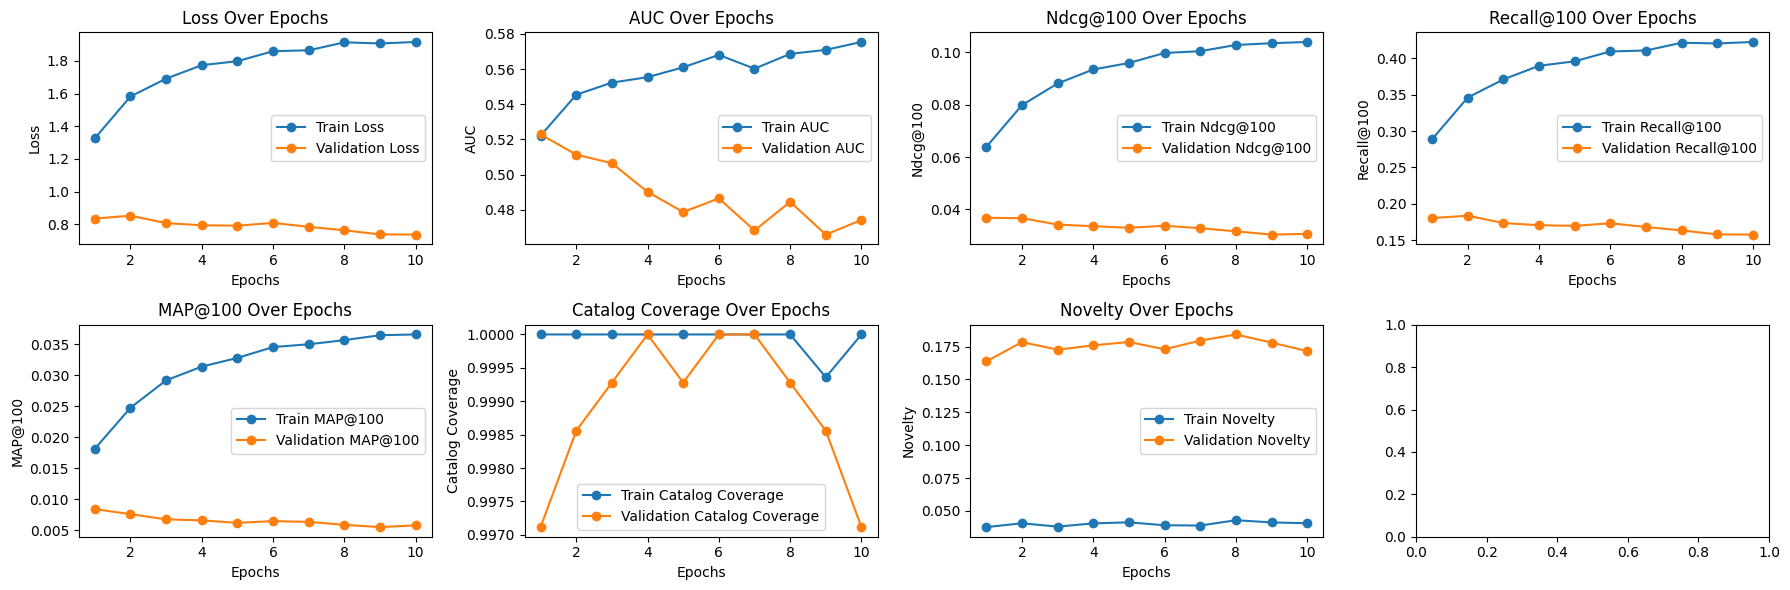

In [ ]:
_history = train_evaluation_clbk.get_records()
_history_val = valid_evaluation_clbk.get_records()
AUC_TERM = [k for k in _history if k.startswith('auc')][0]
_metrics  = {
    'Loss': 'loss',
    'AUC': AUC_TERM,
    'Ndcg@100': 'ndcg_at_100',
    'Recall@100': 'recall_at_100',
    'MAP@100':'map_at_100',
    'Catalog Coverage': 'coverage',
    'Novelty':'novelty'
}
print('Plot for model', VERSION)
plot_metrics(_history, _history_val, _metrics)


Plot for model v10


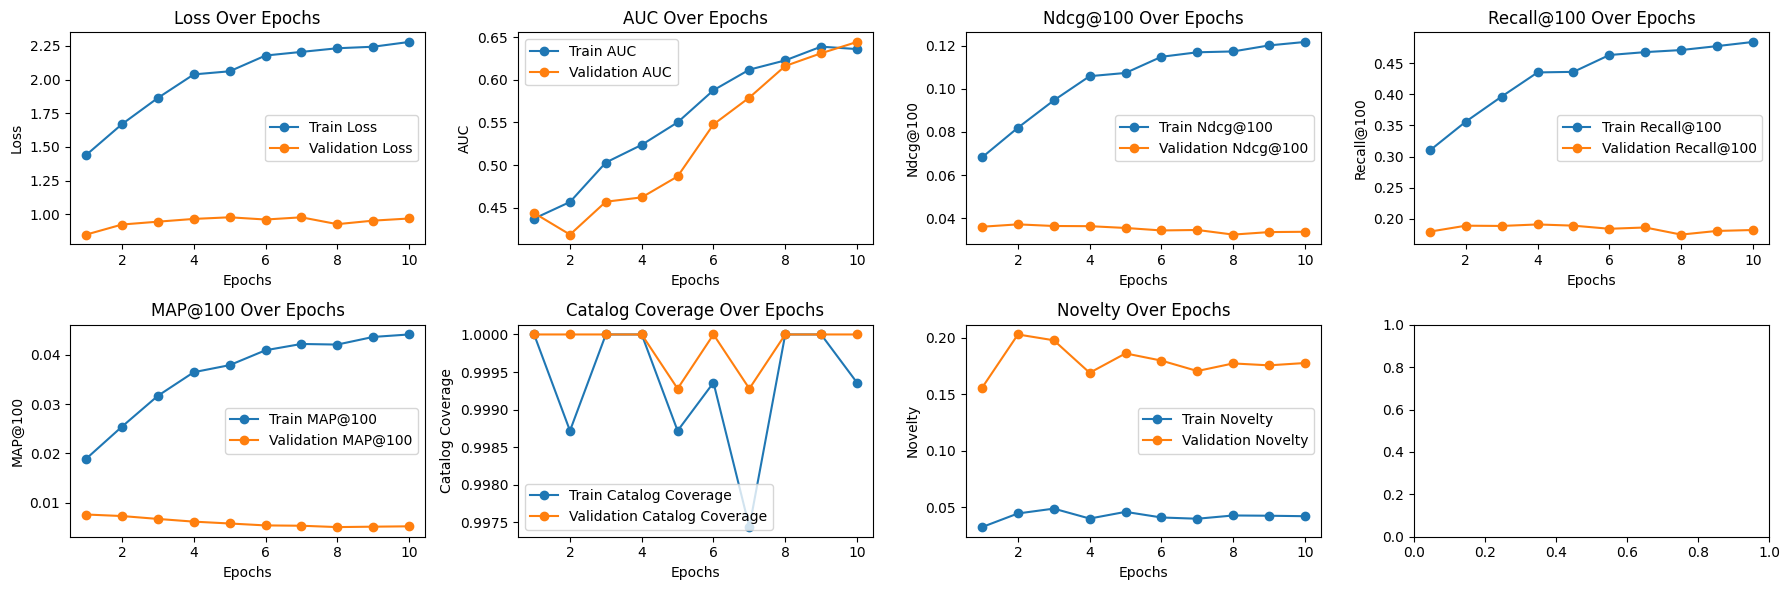

In [ ]:
_history = train_evaluation_clbk.get_records()
_history_val = valid_evaluation_clbk.get_records()
AUC_TERM = [k for k in _history if k.startswith('auc')][0]
_metrics  = {
    'Loss': 'loss',
    'AUC': AUC_TERM,
    'Ndcg@100': 'ndcg_at_100',
    'Recall@100': 'recall_at_100',
    'MAP@100':'map_at_100',
    'Catalog Coverage': 'coverage',
    'Novelty':'novelty'
}
print('Plot for model', VERSION)
plot_metrics(_history, _history_val, _metrics)


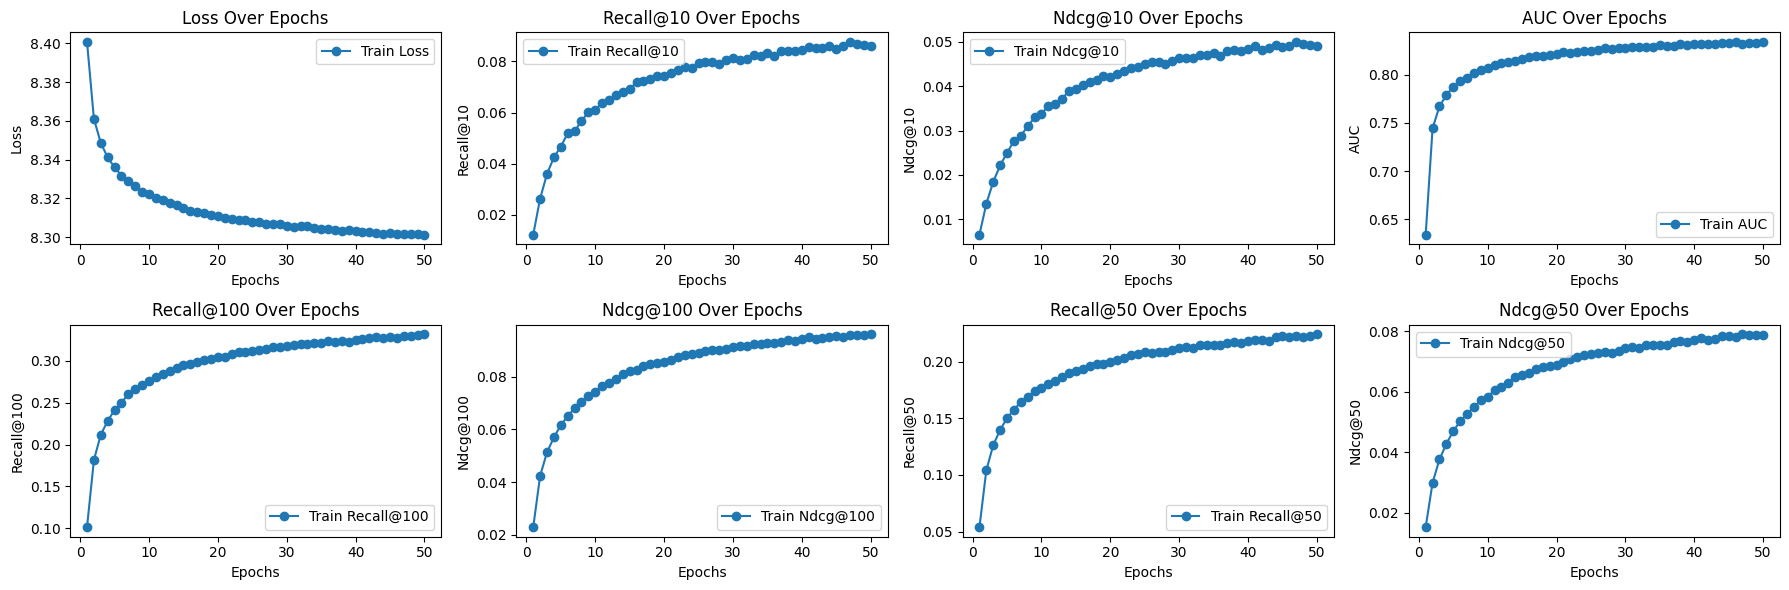

In [ ]:
_history = merge_model_history(*history)
# AUC_TERM = [k for k in _history if k.startswith('auc')][0]
METRIC_AT = {'@'.join([k.split('_')[0].title(), k.split('_')[-1]]):k for k in _history if k.startswith('recall') or k.startswith('ndcg')}
val_history = { k[4:]:v for k,v in _history.items() if k.startswith('val')}
plot_metrics(_history, None, default_plot_metrics | {'AUC': 'auc', **METRIC_AT,})
# {'AUC': AUC_TERM, 'Recall@100': 'recall_at_100','NDCG@10': 'ndcg_at_10',}

# Analysis

In [155]:
train_df = train.to_ddf().compute()
valid_df = valid.to_ddf().compute()
test_df = test.to_ddf().compute()

data = valid
data_df = valid.to_ddf().compute()

model = models['v1']

In [156]:
from model_helper import to_top_k_encoder
from model_helper import get_candidates

topk = 100
batch_size = 2048
# candiate set needs to be train + data
candidate_features = get_candidates(
    Dataset(
        pd.concat((train_df, valid_df, test_df), axis=0),
        schema=train.schema
    )
)

topk_model = to_top_k_encoder(model, candidate_features, k=topk, batch_size=batch_size)
topk_model.compile(run_eagerly=False, metrics=[
    mm.RecallAt(topk), mm.NDCGAt(topk), mm.MRRAt(topk)
])

Candidate set rows: 1664


### Collect cold candidate

In [157]:
# load the original data
synopsis_df = pd.read_parquet(os.path.join(DATA_DIR, 'movielens_100k_synopsis_raw.parquet')).rename({
    'movie_id':'movie_id_raw'
}, axis=1)
# synopsis_df.head()

In [158]:
# cold movies
cold_movies = list(set(data_df['movie_id_raw'].unique()).difference(set(train_df['movie_id_raw'].unique())))
cold_movies_df = synopsis_df[synopsis_df['movie_id_raw'].isin(cold_movies)]
# cold_movies_df

In [159]:
assert train_df[train_df['movie_id_raw'].isin(cold_movies_df['movie_id_raw'].values)].empty

### Generate dataset embedding space

In [160]:
from model_helper import get_candidates
from model_helper import batch_predict

In [161]:
def collect_embeddings(model, candidates, batch_size=512):
    candidate_id=Tags.ITEM_ID
    output_schema = model.schema.select_by_tag(candidate_id)

    return batch_predict(
            model.candidate_encoder,
            candidates,
            batch_size=batch_size,
            output_schema=output_schema,
            index=candidate_id,
            output_concat_func=np.concatenate,
    )

In [162]:
%%time
if 'train_embeddings' not in globals():
    candidate_features = get_candidates(train, [Tags.ITEM, Tags.ITEM_ID])
    train_embeddings = collect_embeddings(model, candidate_features)
    train_embeddings.head()

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 10.7 µs


In [163]:
%%time
from merlin.io import Dataset
cold_movies_ds = Dataset(
    data_df[data_df['movie_id_raw'].isin(cold_movies_df['movie_id_raw'])],
    schema = data.schema
)
candidate_features = get_candidates(cold_movies_ds, [Tags.ITEM, Tags.ITEM_ID])

# convert cold movies to embeddings
cold_movies_embeddings = collect_embeddings(model, candidate_features)
cold_movies_embeddings.head()

Candidate set rows: 50


CPU times: user 3.99 s, sys: 32.8 ms, total: 4.03 s
Wall time: 4.18 s


,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
movie_id,,,,,,,,,,,,,,,,,,,,,
1346,-0.009850,-0.034172,0.032142,0.075612,0.061384,0.003212,-0.046372,0.037191,-0.322096,0.167202,...,-0.036262,0.055184,-0.102059,0.177214,0.008312,-0.155086,-0.015507,0.162260,0.025434,-0.133612
1551,-0.019768,-0.021268,-0.006824,0.053284,0.041568,0.016133,0.008234,0.017885,-0.380272,0.091652,...,-0.026317,0.042855,-0.096127,0.195349,-0.038892,-0.215550,-0.016266,0.108425,0.011580,-0.107217
1380,0.021343,-0.007727,-0.011132,0.110192,0.089838,-0.019133,-0.101639,0.017469,-0.278976,0.129959,...,0.039146,0.024475,-0.117251,0.154457,0.016382,-0.237711,-0.059462,0.159895,-0.007549,-0.124257
1436,0.003895,0.013709,-0.004933,0.091023,0.065706,0.023547,0.009434,0.035453,-0.379478,0.127101,...,-0.047475,0.026815,-0.082161,0.187289,-0.028838,-0.325585,-0.063874,0.131651,-0.054592,-0.025835
1516,-0.000122,-0.040869,0.103427,0.037296,0.117107,0.008687,-0.047479,0.020924,-0.321926,0.168570,...,-0.006521,0.041660,-0.079337,0.188607,-0.034844,-0.293253,-0.050877,0.157948,-0.023204,-0.189769


### Search Vector Space, find similar items

In [164]:
train_embeddings_df = train_embeddings.to_ddf().compute()
cold_movies_embeddings_df = cold_movies_embeddings.to_ddf().compute()

In [165]:
cold_movies_df

,movie_id_raw,title,synopsis,cast
597,1398,Anna (1996),Anna is a 1996 mystery thriller film about a y...,"Sally Kirkland, Paulina Porizkova, Robert Fiel..."
777,626,So Dear to My Heart (1949),"""So Dear to My Heart"" is a heartwarming family...","Bobby Driscoll, Beulah Bondi, Burl Ives"
874,1453,Angel on My Shoulder (1946),"After being taken to Hell, gangster Eddie Kagl...","Paul Muni, Anne Baxter, Claude Rains"
876,1452,Lady of Burlesque (1943),Lady of Burlesque is a 1943 mystery film cente...,"Barbara Stanwyck, Michael O'Shea,"
878,1460,Sleepover (1995),Sleepover (1995) is a comedy film that tells t...,Unknown
1140,1189,Prefontaine (1997),Prefontaine is a biographical sports drama fil...,"Jared Leto, Ed O'Neill, R. Lee Ermey, Breckin ..."
1215,1327,Captives (1994),Captives (1994) is a suspense thriller film th...,"Julia Ormond, Tim Roth, Keith Allen, Peter Cap..."
1289,1365,Johnny 100 Pesos (1993),Johnny 100 Pesos is a 1993 Chilean crime drama...,"Armando Araiza, Patricia Rivera, Willy Semler,..."
1310,1436,Mr. Jones (1993),"In the thrilling drama ""Mr. Jones"" (1993), a m...","Richard Gere, Lena Olin, Anne Bancroft"
1328,1275,Killer (Bulletproof Heart) (1994),Killer (Bulletproof Heart) is a 1994 crime thr...,"Anthony LaPaglia, Mimi Rogers, Peter Boyle, Ma..."


In [166]:
movie_id_raw = 1189
# movie_id_raw = 626
# movie_id_raw = 1365

movie_id = data_df[data_df['movie_id_raw'] == movie_id_raw]['movie_id'].values[0]
movie_id

1423

In [167]:
# data_df[data_df['movie_id'] == 1392]

In [168]:
# select a single cold movie
cold_movie_embeddings_df = cold_movies_embeddings_df.loc[[movie_id]]
cold_movie_embeddings_df

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
movie_id,,,,,,,,,,,,,,,,,,,,,
1423,-0.008108,-0.030349,0.03537,0.062176,0.029574,0.030083,-0.040968,0.02813,-0.296896,0.157371,...,-0.034047,0.042186,-0.084349,0.220234,-0.017833,-0.161442,-0.074445,0.173966,0.024923,-0.180301


In [169]:
from sklearn.metrics.pairwise import cosine_similarity

target_vector = cold_movie_embeddings_df.values[0]

# Calculate the cosine similarity between the target vector and all other item vectors
item_vectors = np.vstack(train_embeddings_df.values)
similarities = cosine_similarity([target_vector], item_vectors)[0]

# Create a new DataFrame with item IDs and their similarity scores
similar_items_df = pd.DataFrame({'movie_id': train_embeddings_df.index, 'similarity_score': similarities})

# Sort the DataFrame by similarity score in descending order to get most similar items first
similar_items_df = similar_items_df.sort_values(by='similarity_score', ascending=False)

# merge movie_id_raw
similar_items_df = pd.merge(
    similar_items_df,
    train_df[['movie_id', 'movie_id_raw']].groupby(['movie_id', 'movie_id_raw'], as_index=False).count(),
         on='movie_id')

In [170]:
cold_movies_df[cold_movies_df['movie_id_raw'] == movie_id_raw][['synopsis', 'cast']].values

array([["Prefontaine is a biographical sports drama film that tells the story of Steve Prefontaine, a legendary long-distance runner. Set in the 1970s, the film explores his rise to fame as one of America's top athletes, his rebellious nature, and his intense rivalry with other runners. It showcases his determination, charisma, and controversial personality, as well as the impact he had on the sport.",
        "Jared Leto, Ed O'Neill, R. Lee Ermey, Breckin Meyer, Lindsay Crouse"]],
      dtype=object)

In [171]:
# check top 10 similar movies
# synopsis_df

pd.merge(similar_items_df.iloc[:10], synopsis_df, on='movie_id_raw')


,movie_id,similarity_score,movie_id_raw,title,synopsis,cast
0,6,0.910096,286,"English Patient, The (1996)","Set during World War II, ""The English Patient""...","Ralph Fiennes, Juliette Binoche, Kristin Scott..."
1,60,0.885341,289,Evita (1996),Evita is a 1996 musical drama film that follow...,"Madonna, Antonio Banderas, Jonathan Pryce"
2,3,0.856183,100,Fargo (1996),Fargo is a dark comedy crime film directed by ...,"Frances McDormand, William H. Macy, Steve Busc..."
3,30,0.850788,269,"Full Monty, The (1997)","""Full Monty"" is a comedy-drama film set in She...","Robert Carlyle, Tom Wilkinson, Mark Addy, Will..."
4,15,0.850052,98,"Silence of the Lambs, The (1991)",FBI trainee Clarice Starling seeks the help of...,"Jodie Foster, Anthony Hopkins, Scott Glenn, An..."
5,12,0.849055,127,"Godfather, The (1972)",The Godfather (1972) is a crime drama film dir...,"Marlon Brando, Al Pacino, James Caan, Robert D"
6,35,0.845669,276,Leaving Las Vegas (1995),Leaving Las Vegas (1995) is a drama film cente...,"Nicolas Cage, Elisabeth Shue"
7,1,0.845175,50,Star Wars (1977),"In a galaxy far, far away, a young farm boy na...","Mark Hamill, Harrison Ford, Carrie Fisher, Ale..."
8,2,0.841103,258,Contact (1997),"""Contact"" is a science fiction drama where sci...","Jodie Foster, Matthew McConaughey, Tom Skerrit..."
9,7,0.834072,288,Scream (1996),Scream (1996) is a horror film directed by Wes...,"Neve Campbell, Courteney Cox, David Arquette, ..."


### Validate Recommendations

In [172]:
# movie_id_raw = 1189
movie_id_raw = 626
# movie_id_raw = 1365

movie_id = data_df[data_df['movie_id_raw'] == movie_id_raw]['movie_id'].values[0]
movie_id

1392

In [173]:
# select a single cold movie
cold_movie_embeddings_df = cold_movies_embeddings_df.loc[[movie_id]]
cold_movie_embeddings_df

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
movie_id,,,,,,,,,,,,,,,,,,,,,
1392,0.078982,-0.08114,0.052329,0.044808,0.06175,-0.029761,0.004599,0.003895,-0.257727,0.168617,...,0.05165,0.094007,-0.114967,0.23788,-0.064655,-0.349441,-0.272168,0.15104,0.108238,-0.115265


In [174]:
cold_movies_df[cold_movies_df['movie_id_raw'] == movie_id_raw][['synopsis', 'cast']].values

array([['"So Dear to My Heart" is a heartwarming family film set in 1903. It tells the story of a young boy named Jeremiah, who dreams of raising his own prize-winning sheep. With the help of his kindly grandmother and an orphaned black lamb, Jeremiah learns the value of hard work, determination, and the importance of believing in oneself. The movie emphasizes the bond between humans and animals, and the power of dreams.',
        'Bobby Driscoll, Beulah Bondi, Burl Ives']], dtype=object)

In [175]:
from sklearn.metrics.pairwise import cosine_similarity

target_vector = cold_movie_embeddings_df.values[0]

# Calculate the cosine similarity between the target vector and all other item vectors
item_vectors = np.vstack(train_embeddings_df.values)
similarities = cosine_similarity([target_vector], item_vectors)[0]

# Create a new DataFrame with item IDs and their similarity scores
similar_items_df = pd.DataFrame({'movie_id': train_embeddings_df.index, 'similarity_score': similarities})

# Sort the DataFrame by similarity score in descending order to get most similar items first
similar_items_df = similar_items_df.sort_values(by='similarity_score', ascending=False)

# merge movie_id_raw
similar_items_df = pd.merge(
    similar_items_df,
    train_df[['movie_id', 'movie_id_raw']].groupby(['movie_id', 'movie_id_raw'], as_index=False).count(),
         on='movie_id')
pd.merge(similar_items_df.iloc[:10], synopsis_df, on='movie_id_raw')


,movie_id,similarity_score,movie_id_raw,title,synopsis,cast
0,1,0.857054,50,Star Wars (1977),"In a galaxy far, far away, a young farm boy na...","Mark Hamill, Harrison Ford, Carrie Fisher, Ale..."
1,5,0.856260,294,Liar Liar (1997),Fletcher Reede is a successful lawyer who has ...,"Jim Carrey, Maura Tierney, Justin Cooper, Cary..."
2,4,0.840736,181,Return of the Jedi (1983),In this third installment of the original Star...,"Mark Hamill, Harrison Ford, Carrie Fisher, Bil..."
3,60,0.840481,289,Evita (1996),Evita is a 1996 musical drama film that follow...,"Madonna, Antonio Banderas, Jonathan Pryce"
4,2,0.840217,258,Contact (1997),"""Contact"" is a science fiction drama where sci...","Jodie Foster, Matthew McConaughey, Tom Skerrit..."
5,6,0.840161,286,"English Patient, The (1996)","Set during World War II, ""The English Patient""...","Ralph Fiennes, Juliette Binoche, Kristin Scott..."
6,193,0.828715,500,Fly Away Home (1996),Fly Away Home (1996) is a heartwarming drama a...,"Jeff Daniels, Anna Paquin, Dana Delany, Terry ..."
7,7,0.815174,288,Scream (1996),Scream (1996) is a horror film directed by Wes...,"Neve Campbell, Courteney Cox, David Arquette, ..."
8,28,0.807306,748,"Saint, The (1997)","An ex-thief named Simon, known as ""The Saint"" ...","Val Kilmer, Elisabeth Shue, Rade Serbedzija, V..."
9,9,0.804489,300,Air Force One (1997),Air Force One (1997) is an action thriller fil...,"Harrison Ford, Gary Oldman, Glenn Close, Wendy..."


In [176]:
top10_similar_movies = list(similar_items_df.iloc[:10]['movie_id'].values)
top10_similar_movies

[1, 5, 4, 60, 2, 6, 193, 7, 28, 9]

In [177]:
eval_loader = mm.Loader(train, batch_size=2048, shuffle=False)
_iter = iter(eval_loader)

from collections import defaultdict
movie_count = defaultdict(set)

for batch, _ in _iter:
    r = topk_model(batch)[1].numpy()
    for mid in (top10_similar_movies + [movie_id]):
        mask = np.any(r == mid, axis=1)
        movie_count[mid] |= set(tf.boolean_mask(batch['user_id'], mask).numpy())
    # count_user_recommended += np.sum(np.any(np.isin(r, target_movies), axis=1))

In [183]:
map_df = pd.DataFrame(columns=movie_count.keys(), index=movie_count.keys())
for mid in movie_count:
    for o_mid in movie_count:
        map_df.loc[mid, o_mid] = len(movie_count[mid].intersection(movie_count[o_mid])) /len(movie_count[mid])
        if mid == o_mid:
            map_df.loc[mid, o_mid] = 0
map_df

,1,5,4,60,2,6,193,7,28,9,1392
1,0,0.372197,0.784753,0.313901,0.443946,0.336323,0.210762,0.349776,0.426009,0.372197,0.278027
5,0.345833,0,0.291667,0.7875,0.904167,0.741667,0.5,0.808333,0.808333,0.8875,0.1375
4,0.972222,0.388889,0,0.3,0.5,0.322222,0.183333,0.355556,0.488889,0.4,0.294444
60,0.27027,0.72973,0.208494,0,0.822394,0.872587,0.474903,0.702703,0.65251,0.795367,0.11583
2,0.342561,0.750865,0.311419,0.737024,0,0.771626,0.453287,0.761246,0.705882,0.875433,0.134948
6,0.269784,0.640288,0.208633,0.81295,0.802158,0,0.442446,0.665468,0.579137,0.755396,0.111511
193,0.279762,0.714286,0.196429,0.732143,0.779762,0.732143,0,0.678571,0.696429,0.797619,0.202381
7,0.3,0.746154,0.246154,0.7,0.846154,0.711538,0.438462,0,0.676923,0.8,0.103846
28,0.387755,0.791837,0.359184,0.689796,0.832653,0.657143,0.477551,0.718367,0,0.816327,0.146939
9,0.296429,0.760714,0.257143,0.735714,0.903571,0.75,0.478571,0.742857,0.714286,0,0.114286


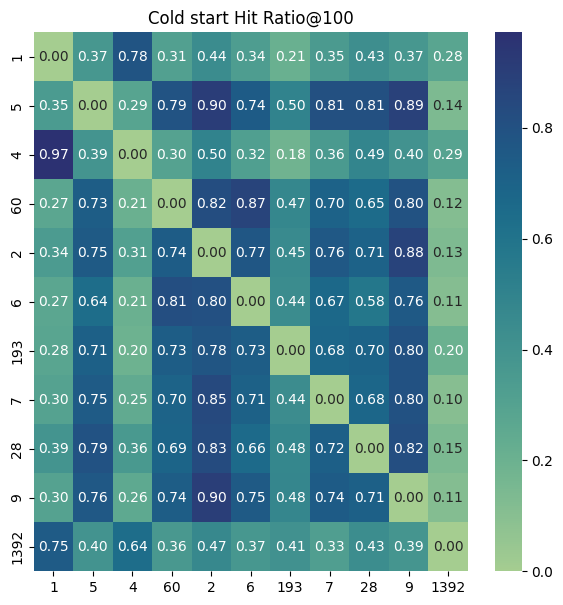

In [191]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7,7))

sns.heatmap(map_df.astype(np.float32),
            cmap="crest",
            fmt=".2f",
            annot=True
            #vmax=1.0, vmin=0
            )
plt.title(f'Cold start Hit Ratio@{topk}')
plt.show()

### tmp

In [ ]:
_tmp_movies = set(data_df[data_df['movie_id_raw'].isin(cold_movies_df['movie_id_raw'].values)]['movie_id'].values)
len(_tmp_movies)

50

In [ ]:
eval_loader = mm.Loader(train, batch_size=2048, shuffle=False)
_iter = iter(eval_loader)

from collections import defaultdict
movie_count = defaultdict(set)

for batch, _ in _iter:
    r = topk_model(batch)[1].numpy()
    for mid in _tmp_movies:
        mask = np.any(r == mid, axis=1)
        movie_count[mid] |= set(tf.boolean_mask(batch['user_id'], mask).numpy())
    # count_user_recommended += np.sum(np.any(np.isin(r, target_movies), axis=1))

In [ ]:
for k,v in movie_count.items():
    print(k, len(v))

1536 0
1540 0
1414 0
1549 0
1551 6
1423 0
1560 0
1436 6
1565 0
1567 0
1570 0
1571 0
1572 2
1574 0
1575 0
1579 3
1584 0
1457 0
1336 0
1467 0
1595 0
1597 0
1469 0
1470 0
1346 0
1603 0
1347 0
1349 0
1607 0
1610 4
1482 0
1485 0
1486 0
1617 0
1619 0
1498 0
1627 0
1634 0
1635 0
1380 0
1516 0
1517 0
1645 0
1644 1
1392 17
1395 0
1396 0
1657 0
1531 0
1663 0
